In [1]:
import json
import os
import pickle
import keras
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.signal import savgol_filter
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, BatchNormalization, Dense, Dropout, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [2]:



def trim_start_end_nans(df):
    """
    Removes rows at the start and end of a DataFrame that have NaN values in any column.
    """
    # Initialize start_idx and end_idx based on the DataFrame's index type
    if isinstance(df.index, pd.DatetimeIndex):
        start_idx = df.index[0]  # Assume first index is earliest; adjust if necessary
        end_idx = df.index[-1]  # Assume last index is latest; adjust if necessary
    else:
        start_idx = 0
        end_idx = len(df) - 1

    for column in df.columns:
        # Find the first non-NaN index in the current column
        first_valid_index = df[column].first_valid_index()
        if first_valid_index is not None and df.index.get_loc(
            first_valid_index
        ) > df.index.get_loc(start_idx):
            start_idx = first_valid_index

        # Find the last non-NaN index in the current column
        last_valid_index = df[column].last_valid_index()
        if last_valid_index is not None and df.index.get_loc(
            last_valid_index
        ) < df.index.get_loc(end_idx):
            end_idx = last_valid_index

    # Trim the DataFrame
    return df.loc[start_idx:end_idx]




def process_data_for_plot(
    plot_number,
    target_columns,
    continuous_columns,
    start_date="2023-07-20",
    end_date="2023-09-03",
    rolling_windows=[3, 7], 
):
    """
    Process data for a given plot number within a specified date range. This includes:
    * Spike Detection (up and down) for VWC columns
    * Time since last significant precipitation
    * Cumulative precipitation within a time window
    * Rolling window statistics
    * Time Encoding
    """

    # Database connection
    conn = sqlite3.connect("processed_data.db")
    query = "SELECT * FROM data_table"
    df = pd.read_sql_query(query, conn)
    conn.close()

    # Filter by plot_number and date range
    df = df[
        (df["plot_number"] == plot_number)
        & (df["TIMESTAMP"] >= start_date)
        & (df["TIMESTAMP"] <= end_date)
    ]

    # Convert TIMESTAMP to datetime
    df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
    df.set_index("TIMESTAMP", inplace=True)

    # Sort by TIMESTAMP 
    df.sort_values(by="TIMESTAMP", inplace=True)

    # Select relevant columns
    df = df[continuous_columns + target_columns]

    # Resample to daily frequency 
    df = df.resample("D").mean()

    # Spike detection for VWC columns
    for col in df.columns:
        if "VWC" in col:
            df[f"{col}_spike_up"] = (df[col] > df[col].shift(1) * 1.15).astype(int)  # 15% increase
            df[f"{col}_spike_down"] = (df[col] < df[col].shift(1) * 0.85).astype(int)  # 15% decrease

    # Time since precipitation (modify thresholds as needed)
    significant_precip_threshold = 0.5  
    max_precip_value = df['precip_irrig'].max()
    df['time_since_last_significant_precip'] = (df['precip_irrig'] > significant_precip_threshold).astype(int)
    df['time_since_last_significant_precip'] = df['time_since_last_significant_precip'].replace(to_replace=0, value=np.nan).ffill()
    df['time_since_last_half_max_precip'] = (df['precip_irrig'] > (max_precip_value / 2)).astype(int)
    df['time_since_last_half_max_precip'] = df['time_since_last_half_max_precip'].replace(to_replace=0, value=np.nan).ffill()


    # Cumulative precipitation (replace 4 with the desired window)
    df['precip_irrig_cumulative_4day'] = df['precip_irrig'].rolling(4).sum() 

    # Preprocessing 
    df = df.interpolate(method="pchip")

    # Rolling window features
    for window in rolling_windows:
        for col in continuous_columns:
            df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window).mean()
            df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window).std()

    return df

In [3]:
def subtract_mean(df, target_columns, continuous_columns):
    # Subtract mean from each column (append new columns with suffix "_mean_subtracted")
    df_mean_subtracted = df.copy()
    mean_values = {}
    for col in df_mean_subtracted.columns:
        if col in [target_columns + continuous_columns]:
            mean_values[col] = df_mean_subtracted[col].mean()
            df_mean_subtracted[col] = df_mean_subtracted[col] - mean_values[col]
    return df_mean_subtracted, mean_values

def create_derivative_columns(df, target_columns, continuous_columns):
    initial_values = {}
    for col in df.columns:  # Change to apply to all columns
        if col in [target_columns + continuous_columns]:
            initial_values[col] = df[col].iloc[0]
        deriv_col_name = f"{col}_deriv" 
        df[deriv_col_name] = df[col].diff().fillna(0)  # Fill NaN with 0 for initial diff
    return df, initial_values


def transform_and_scale_data(df, target_columns, continuous_columns):
    df_transformed = df.copy()
    df_transformed, mean_values = subtract_mean(df_transformed, target_columns, continuous_columns)  # Change here to apply to all
    df_transformed, initial_values = create_derivative_columns(df_transformed, target_columns, continuous_columns)
    df_transformed["precip_irrig_bool"] = df_transformed["precip_irrig"].apply(
        lambda x: 1 if x > 0 else 0
    )
    
    
    return df_transformed



In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def perform_feature_importance_analysis(model, X_train, y_train, X_val, y_val, features):
    """
    Perform feature importance analysis using RFECV and plots the results.

    Parameters:
    - model: The regression model to be used for feature selection and importance analysis.
    - X_train: Training data features.
    - y_train: Training data target variable.
    - X_val: Validation data features.
    - y_val: Validation data target variable.
    - features: List of feature names in the dataset.

    Returns:
    None
    """

    # Instantiate RFECV
    selector = RFECV(
        estimator=model,
        step=1,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    # Fit RFECV on the training data
    selector.fit(X_train, y_train)

    # Transform the data to keep only the selected features
    X_train_selected = selector.transform(X_train)
    X_val_selected = selector.transform(X_val)

    # Train the model on the selected features
    model.fit(X_train_selected, y_train)

    # Get feature importances
    feature_importances = model.feature_importances_

    # Create a DataFrame for feature importances
    features_selected = [features[i] for i in selector.get_support(indices=True)]
    importances_df = pd.DataFrame({'Feature': features_selected, 'Importance': feature_importances})

    # Sort the DataFrame
    importances_df = importances_df.sort_values(by='Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importances_df['Feature'], importances_df['Importance'])
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
    plt.show()

In [5]:
import os
import pickle
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error

def train_and_save_models_with_time_series_validation(X, y_target, plot_number, target_column, model_save_path, features):
    
    
    forecast_day = 1  # Only train for forecast day 1

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    # Shift y forward by forecast_day
    y_shifted = np.roll(y_target, -forecast_day)
    # The last 'forecast_day' values in y_shifted will be incorrect due to the roll, so we remove them
    X_adjusted = X[:-forecast_day, :]
    y_adjusted = y_shifted[:-forecast_day]

    best_model = None
    best_rmse = float("inf")

    # Iterate over each train-test split
    for train_index, val_index in tscv.split(X_adjusted):
        # Split data
        X_train, X_val = X_adjusted[train_index], X_adjusted[val_index]
        y_train, y_val = y_adjusted[train_index], y_adjusted[val_index]
        
        print(f"Number of features during training: {X_train.shape[1]}")

        # Initialize XGBRegressor with parameters
        model = xgb.XGBRegressor(
            max_depth=3,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=1,
            reg_lambda=1,
            reg_alpha=0.2,
            gamma=0.2,
            n_estimators=2000,
            early_stopping_rounds=200,
            objective='reg:squarederror',
            eval_metric='rmse'
        )

        # Train XGBRegressor model with early stopping
        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],

            verbose=False
        )

        # Predict on validation set
        y_val_pred = model.predict(X_val)

        # Calculate RMSE for the current split
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

        # Update best model if improvement
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_model = model

    # After finding the best model, perform feature importance analysis
    #perform_feature_importance_analysis(best_model, X_train, y_train, X_val, y_val, features)

    # Save the best model
    best_model_save_path = os.path.join(model_save_path, f"best_model_{target_column}_{plot_number}.pkl")
    os.makedirs(os.path.dirname(best_model_save_path), exist_ok=True)

    with open(best_model_save_path, 'wb') as file:
        pickle.dump(best_model, file)


Number of features during training: 180
Number of features during training: 180
Number of features during training: 180
Number of features during training: 180
Number of features during training: 180
Number of features during training: 180
Number of features during training: 180
Number of features during training: 180
Number of features during training: 180
Number of features during training: 180
Number of features during training: 180
Number of features during training: 180
Number of features during training: 180
Number of features during training: 180
Number of features during training: 180
Number of features during training: 180
Number of features during training: 180
Number of features during training: 180
Number of features during training: 180
Number of features during training: 180
Number of features during training: 180
Number of features during training: 180
Number of features during training: 180
Number of features during training: 180
Number of features during training: 180


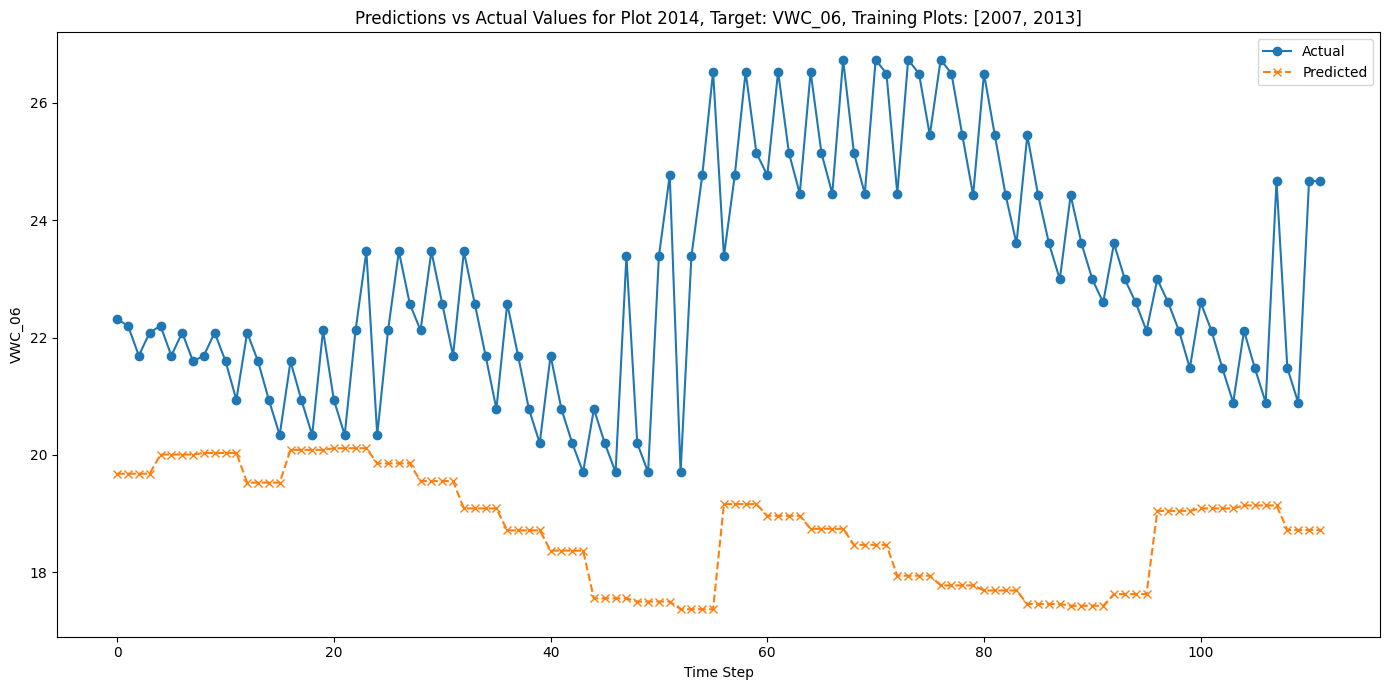

[[19.6796751  19.6796751  19.6796751  19.6796751 ]
 [20.00605965 20.00605965 20.00605965 20.00605965]
 [20.03222466 20.03222466 20.03222466 20.03222466]
 [19.52705002 19.52705002 19.52705002 19.52705002]
 [20.08624554 20.08624554 20.08624554 20.08624554]
 [20.11272621 20.11272621 20.11272621 20.11272621]
 [19.85558414 19.85558414 19.85558414 19.85558414]
 [19.55298901 19.55298901 19.55298901 19.55298901]
 [19.08699894 19.08699894 19.08699894 19.08699894]
 [18.71299458 18.71299458 18.71299458 18.71299458]
 [18.36815548 18.36815548 18.36815548 18.36815548]
 [17.55429268 17.55429268 17.55429268 17.55429268]
 [17.50035858 17.50035858 17.50035858 17.50035858]
 [17.36896896 17.36896896 17.36896896 17.36896896]
 [19.16121197 19.16121197 19.16121197 19.16121197]
 [18.96113396 18.96113396 18.96113396 18.96113396]
 [18.74063683 18.74063683 18.74063683 18.74063683]
 [18.46681118 18.46681118 18.46681118 18.46681118]
 [17.9401741  17.9401741  17.9401741  17.9401741 ]
 [17.77484798 17.77484798 17.77

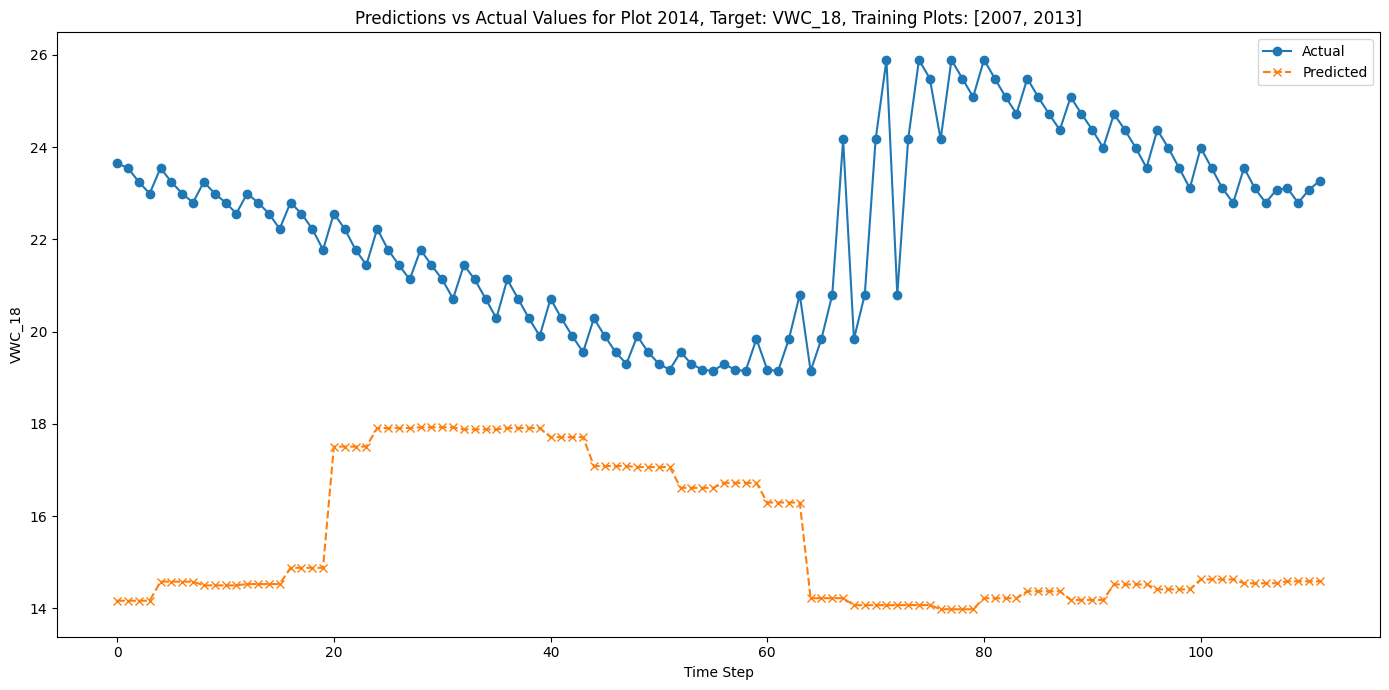

[[14.16740704 14.16740704 14.16740704 14.16740704]
 [14.5811305  14.5811305  14.5811305  14.5811305 ]
 [14.50034189 14.50034189 14.50034189 14.50034189]
 [14.52819586 14.52819586 14.52819586 14.52819586]
 [14.88067198 14.88067198 14.88067198 14.88067198]
 [17.50860357 17.50860357 17.50860357 17.50860357]
 [17.91005564 17.91005564 17.91005564 17.91005564]
 [17.92545271 17.92545271 17.92545271 17.92545271]
 [17.88091803 17.88091803 17.88091803 17.88091803]
 [17.90956736 17.90956736 17.90956736 17.90956736]
 [17.71299887 17.71299887 17.71299887 17.71299887]
 [17.08691311 17.08691311 17.08691311 17.08691311]
 [17.06456089 17.06456089 17.06456089 17.06456089]
 [16.61412382 16.61412382 16.61412382 16.61412382]
 [16.72217607 16.72217607 16.72217607 16.72217607]
 [16.29621601 16.29621601 16.29621601 16.29621601]
 [14.2225461  14.2225461  14.2225461  14.2225461 ]
 [14.07093859 14.07093859 14.07093859 14.07093859]
 [14.07231522 14.07231522 14.07231522 14.07231522]
 [13.98260117 13.98260117 13.98

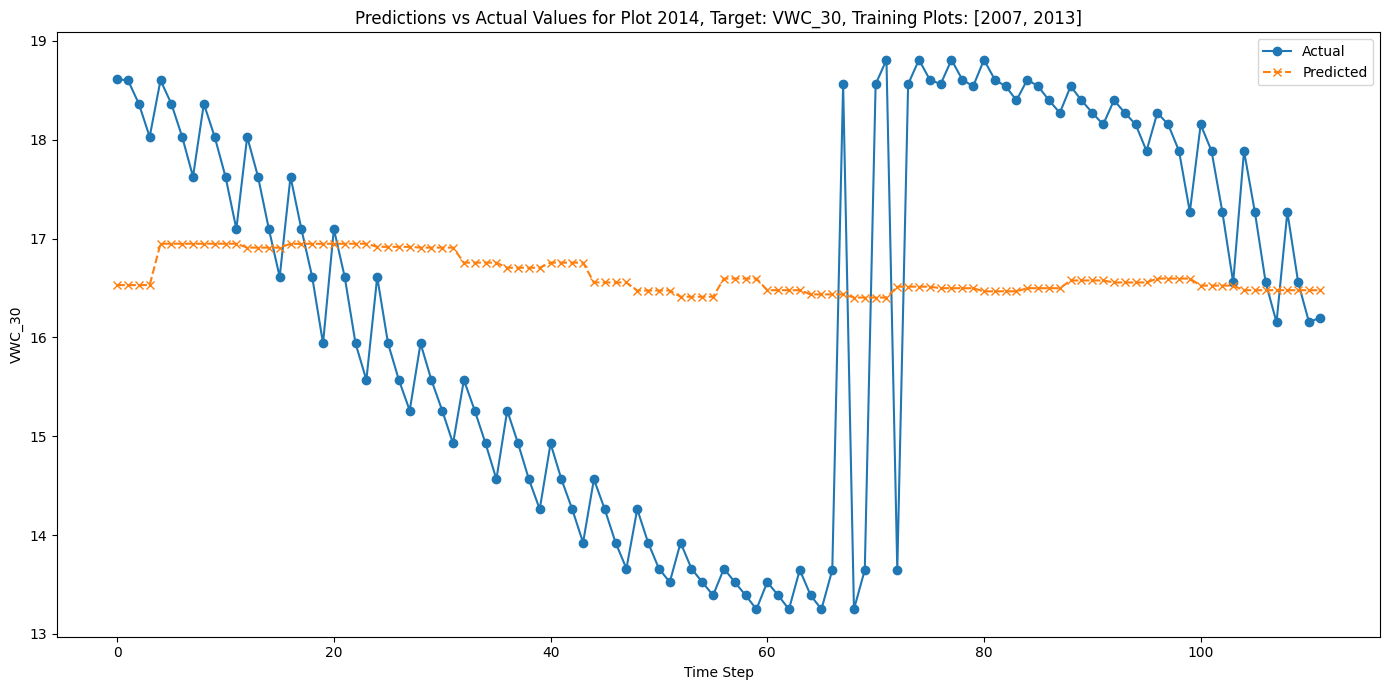

[[16.52980471 16.52980471 16.52980471 16.52980471]
 [16.94846296 16.94846296 16.94846296 16.94846296]
 [16.94846296 16.94846296 16.94846296 16.94846296]
 [16.90899515 16.90899515 16.90899515 16.90899515]
 [16.94787931 16.94787931 16.94787931 16.94787931]
 [16.94846296 16.94846296 16.94846296 16.94846296]
 [16.91693068 16.91693068 16.91693068 16.91693068]
 [16.90899515 16.90899515 16.90899515 16.90899515]
 [16.75711393 16.75711393 16.75711393 16.75711393]
 [16.70542192 16.70542192 16.70542192 16.70542192]
 [16.75711393 16.75711393 16.75711393 16.75711393]
 [16.55642843 16.55642843 16.55642843 16.55642843]
 [16.47483492 16.47483492 16.47483492 16.47483492]
 [16.4118495  16.4118495  16.4118495  16.4118495 ]
 [16.59589624 16.59589624 16.59589624 16.59589624]
 [16.4781127  16.4781127  16.4781127  16.4781127 ]
 [16.43569994 16.43569994 16.43569994 16.43569994]
 [16.40416765 16.40416765 16.40416765 16.40416765]
 [16.51401567 16.51401567 16.51401567 16.51401567]
 [16.49835157 16.49835157 16.49

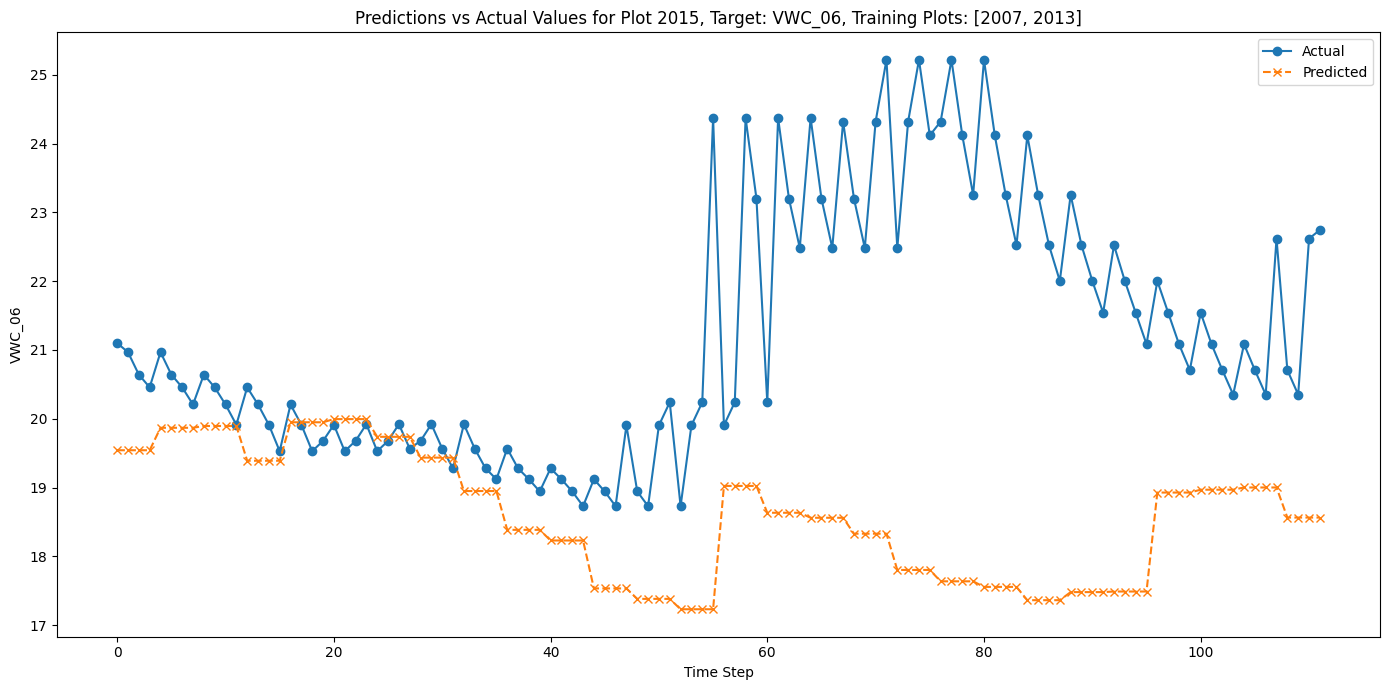

[[19.5427227  19.5427227  19.5427227  19.5427227 ]
 [19.86910725 19.86910725 19.86910725 19.86910725]
 [19.89527225 19.89527225 19.89527225 19.89527225]
 [19.39009762 19.39009762 19.39009762 19.39009762]
 [19.94929314 19.94929314 19.94929314 19.94929314]
 [19.99519348 19.99519348 19.99519348 19.99519348]
 [19.73805141 19.73805141 19.73805141 19.73805141]
 [19.43545628 19.43545628 19.43545628 19.43545628]
 [18.95004654 18.95004654 18.95004654 18.95004654]
 [18.38607693 18.38607693 18.38607693 18.38607693]
 [18.23120308 18.23120308 18.23120308 18.23120308]
 [17.53487301 17.53487301 17.53487301 17.53487301]
 [17.38282585 17.38282585 17.38282585 17.38282585]
 [17.23201656 17.23201656 17.23201656 17.23201656]
 [19.02425957 19.02425957 19.02425957 19.02425957]
 [18.63421631 18.63421631 18.63421631 18.63421631]
 [18.56144047 18.56144047 18.56144047 18.56144047]
 [18.32985878 18.32985878 18.32985878 18.32985878]
 [17.8032217  17.8032217  17.8032217  17.8032217 ]
 [17.63789558 17.63789558 17.63

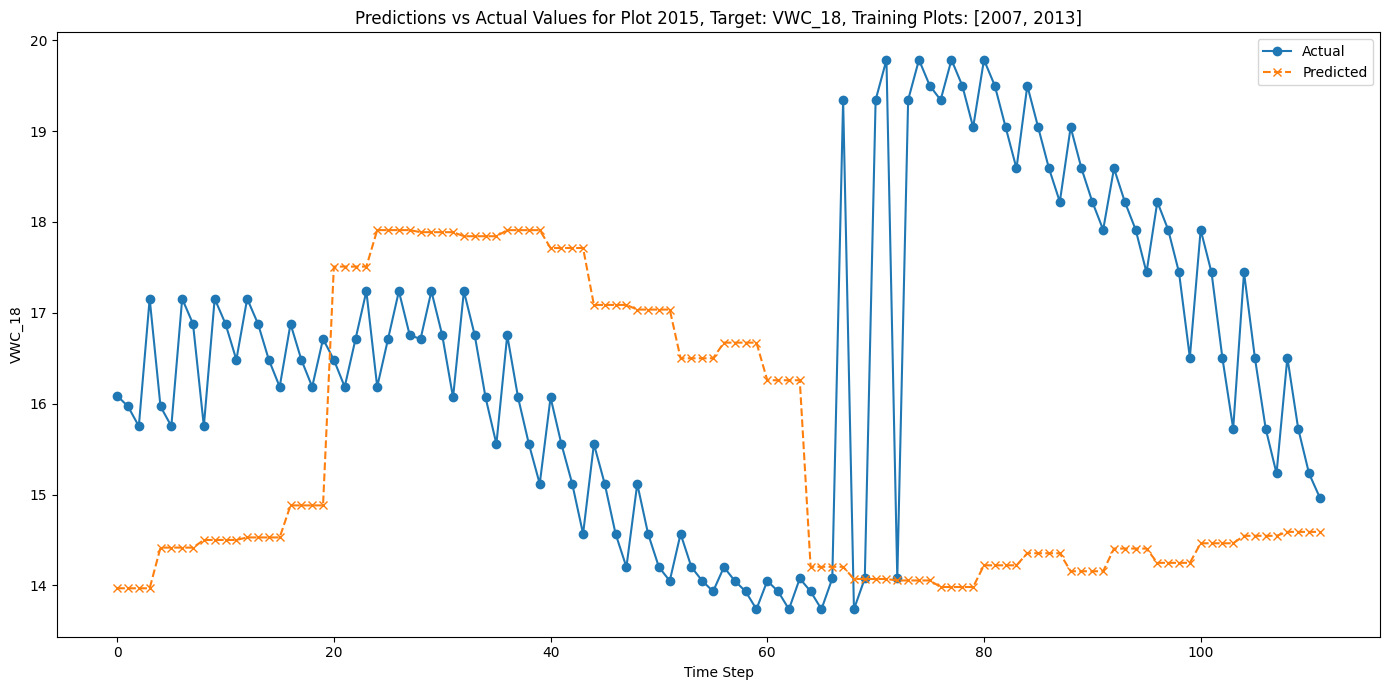

[[13.96867132 13.96867132 13.96867132 13.96867132]
 [14.41629362 14.41629362 14.41629362 14.41629362]
 [14.50034189 14.50034189 14.50034189 14.50034189]
 [14.52819586 14.52819586 14.52819586 14.52819586]
 [14.88067198 14.88067198 14.88067198 14.88067198]
 [17.50860357 17.50860357 17.50860357 17.50860357]
 [17.91005564 17.91005564 17.91005564 17.91005564]
 [17.88715839 17.88715839 17.88715839 17.88715839]
 [17.84262371 17.84262371 17.84262371 17.84262371]
 [17.90956736 17.90956736 17.90956736 17.90956736]
 [17.71299887 17.71299887 17.71299887 17.71299887]
 [17.08691311 17.08691311 17.08691311 17.08691311]
 [17.0355854  17.0355854  17.0355854  17.0355854 ]
 [16.49966526 16.49966526 16.49966526 16.49966526]
 [16.67179775 16.67179775 16.67179775 16.67179775]
 [16.2579217  16.2579217  16.2579217  16.2579217 ]
 [14.20490074 14.20490074 14.20490074 14.20490074]
 [14.07093859 14.07093859 14.07093859 14.07093859]
 [14.05466986 14.05466986 14.05466986 14.05466986]
 [13.98260117 13.98260117 13.98

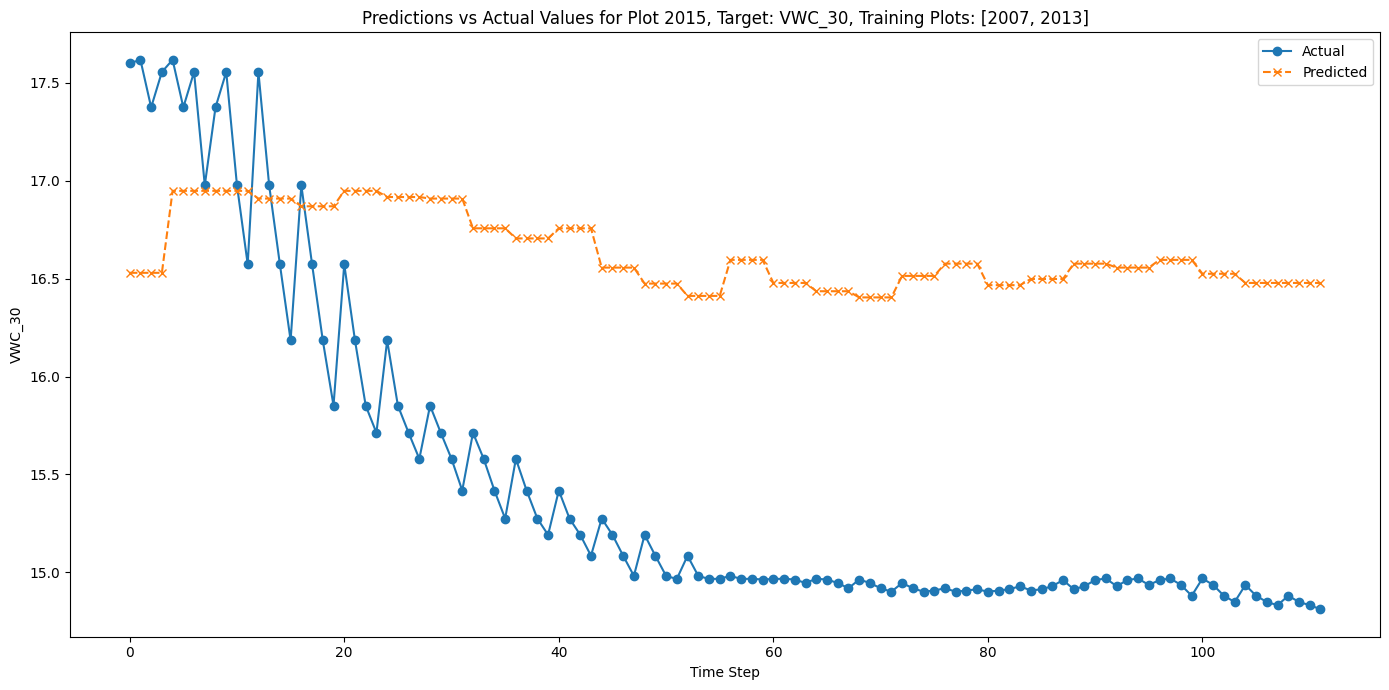

[[16.52980471 16.52980471 16.52980471 16.52980471]
 [16.94846296 16.94846296 16.94846296 16.94846296]
 [16.94846296 16.94846296 16.94846296 16.94846296]
 [16.90899515 16.90899515 16.90899515 16.90899515]
 [16.86956358 16.86956358 16.86956358 16.86956358]
 [16.94846296 16.94846296 16.94846296 16.94846296]
 [16.91693068 16.91693068 16.91693068 16.91693068]
 [16.90899515 16.90899515 16.90899515 16.90899515]
 [16.75711393 16.75711393 16.75711393 16.75711393]
 [16.70542192 16.70542192 16.70542192 16.70542192]
 [16.75711393 16.75711393 16.75711393 16.75711393]
 [16.55642843 16.55642843 16.55642843 16.55642843]
 [16.47483492 16.47483492 16.47483492 16.47483492]
 [16.4118495  16.4118495  16.4118495  16.4118495 ]
 [16.59589624 16.59589624 16.59589624 16.59589624]
 [16.4781127  16.4781127  16.4781127  16.4781127 ]
 [16.43569994 16.43569994 16.43569994 16.43569994]
 [16.40416765 16.40416765 16.40416765 16.40416765]
 [16.51401567 16.51401567 16.51401567 16.51401567]
 [16.57666731 16.57666731 16.57

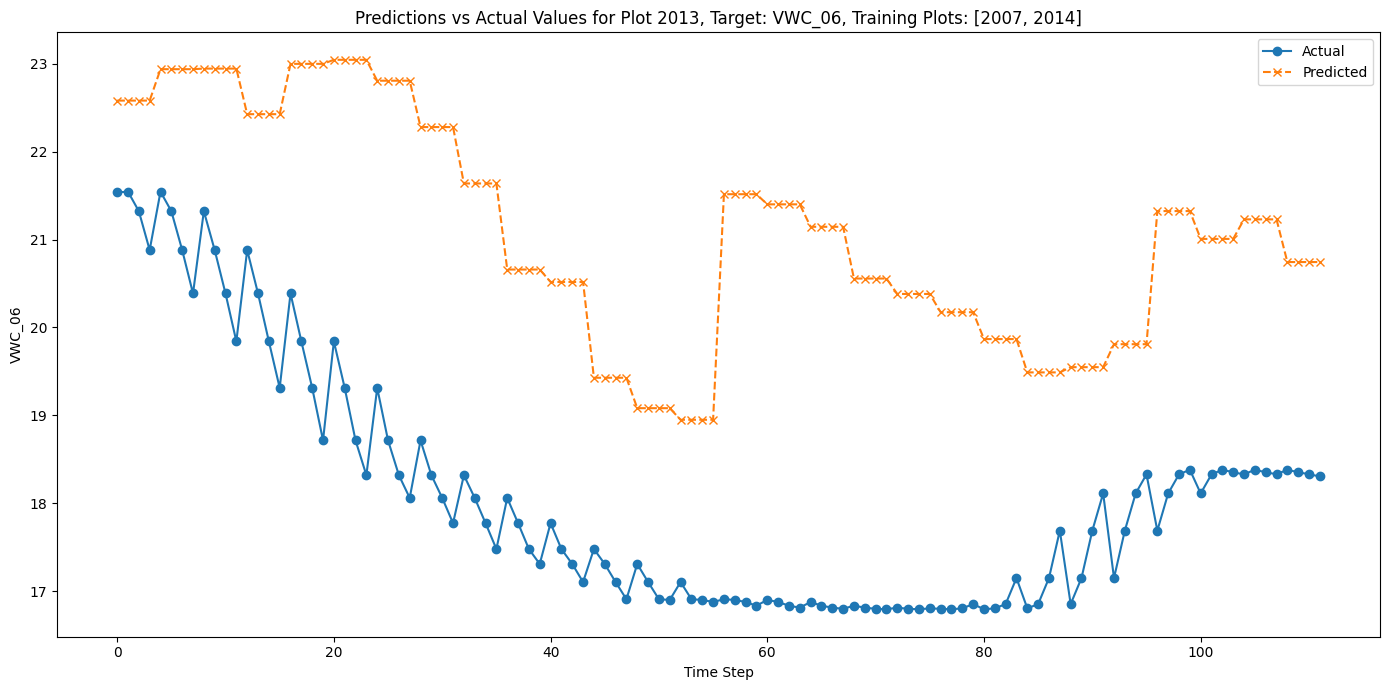

[[22.58096504 22.58096504 22.58096504 22.58096504]
 [22.93812466 22.93812466 22.93812466 22.93812466]
 [22.94487    22.94487    22.94487    22.94487   ]
 [22.42632294 22.42632294 22.42632294 22.42632294]
 [22.99889088 22.99889088 22.99889088 22.99889088]
 [23.04479122 23.04479122 23.04479122 23.04479122]
 [22.80706882 22.80706882 22.80706882 22.80706882]
 [22.27969742 22.27969742 22.27969742 22.27969742]
 [21.63834858 21.63834858 21.63834858 21.63834858]
 [20.6594162  20.6594162  20.6594162  20.6594162 ]
 [20.51770687 20.51770687 20.51770687 20.51770687]
 [19.42844582 19.42844582 19.42844582 19.42844582]
 [19.08225822 19.08225822 19.08225822 19.08225822]
 [18.95027828 18.95027828 18.95027828 18.95027828]
 [21.51609612 21.51609612 21.51609612 21.51609612]
 [21.40074158 21.40074158 21.40074158 21.40074158]
 [21.14543343 21.14543343 21.14543343 21.14543343]
 [20.55702877 20.55702877 20.55702877 20.55702877]
 [20.38155174 20.38155174 20.38155174 20.38155174]
 [20.17398262 20.17398262 20.17

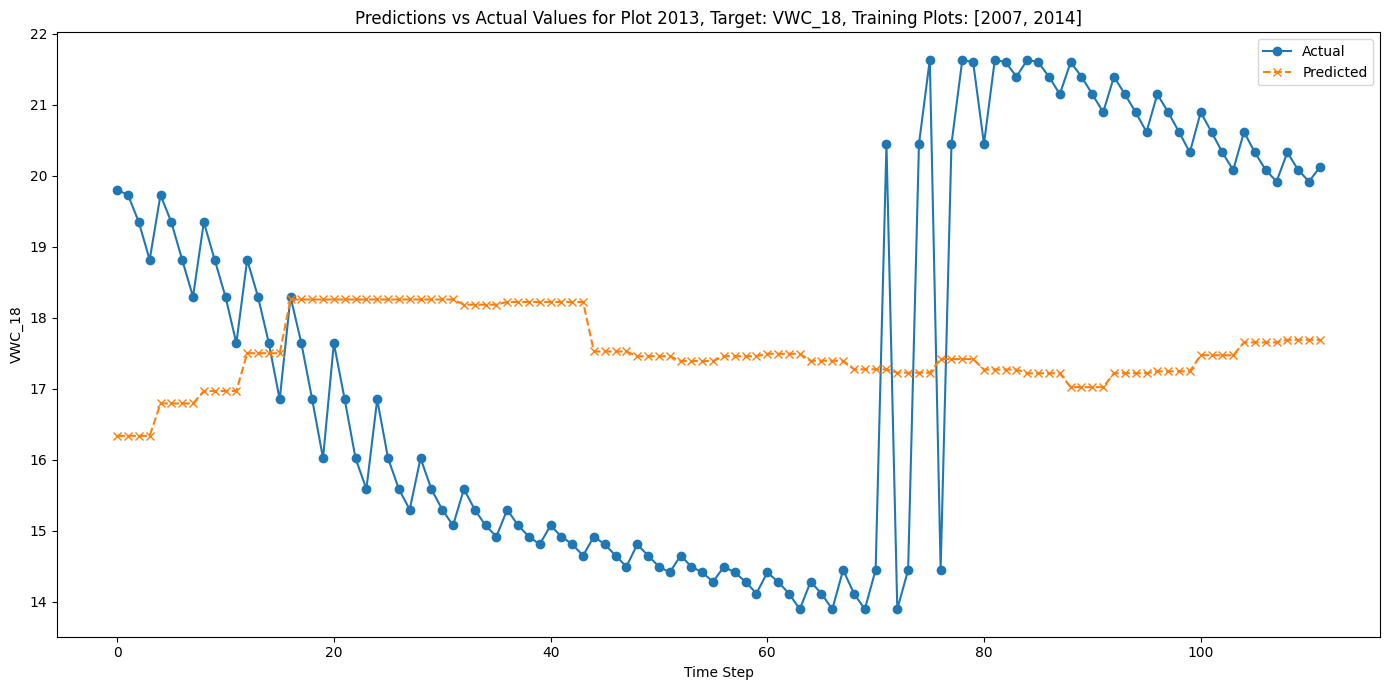

[[16.3351841  16.3351841  16.3351841  16.3351841 ]
 [16.79081535 16.79081535 16.79081535 16.79081535]
 [16.96648073 16.96648073 16.96648073 16.96648073]
 [17.49866819 17.49866819 17.49866819 17.49866819]
 [18.25564766 18.25564766 18.25564766 18.25564766]
 [18.25564766 18.25564766 18.25564766 18.25564766]
 [18.25564766 18.25564766 18.25564766 18.25564766]
 [18.25564766 18.25564766 18.25564766 18.25564766]
 [18.18277311 18.18277311 18.18277311 18.18277311]
 [18.22106743 18.22106743 18.22106743 18.22106743]
 [18.22106743 18.22106743 18.22106743 18.22106743]
 [17.52358389 17.52358389 17.52358389 17.52358389]
 [17.45695066 17.45695066 17.45695066 17.45695066]
 [17.3889513  17.3889513  17.3889513  17.3889513 ]
 [17.45695066 17.45695066 17.45695066 17.45695066]
 [17.4915309  17.4915309  17.4915309  17.4915309 ]
 [17.39292097 17.39292097 17.39292097 17.39292097]
 [17.27204561 17.27204561 17.27204561 17.27204561]
 [17.22425222 17.22425222 17.22425222 17.22425222]
 [17.41601467 17.41601467 17.41

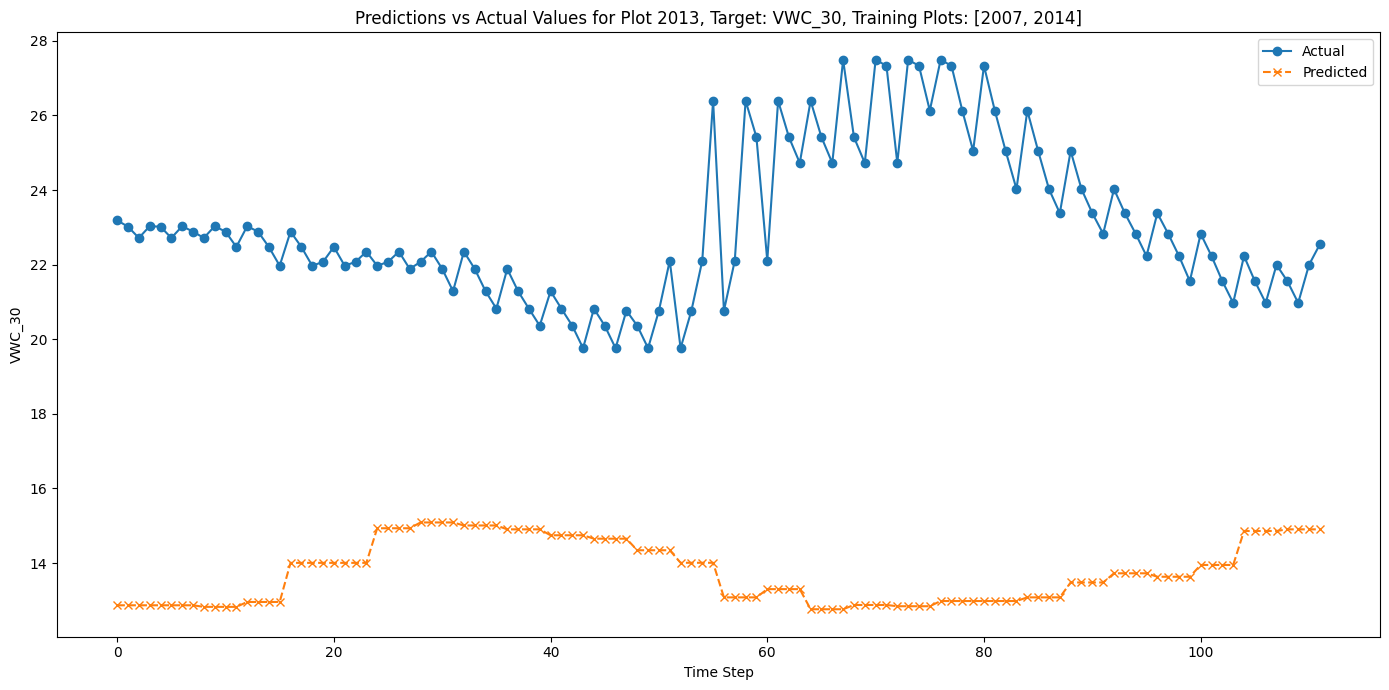

[[12.86712599 12.86712599 12.86712599 12.86712599]
 [12.86712599 12.86712599 12.86712599 12.86712599]
 [12.82504272 12.82504272 12.82504272 12.82504272]
 [12.95604229 12.95604229 12.95604229 12.95604229]
 [14.00484419 14.00484419 14.00484419 14.00484419]
 [14.00484419 14.00484419 14.00484419 14.00484419]
 [14.93257856 14.93257856 14.93257856 14.93257856]
 [15.08837652 15.08837652 15.08837652 15.08837652]
 [15.00729322 15.00729322 15.00729322 15.00729322]
 [14.90323305 14.90323305 14.90323305 14.90323305]
 [14.74450541 14.74450541 14.74450541 14.74450541]
 [14.65263033 14.65263033 14.65263033 14.65263033]
 [14.34282541 14.34282541 14.34282541 14.34282541]
 [14.0072813  14.0072813  14.0072813  14.0072813 ]
 [13.07954502 13.07954502 13.07954502 13.07954502]
 [13.30021954 13.30021954 13.30021954 13.30021954]
 [12.76088476 12.76088476 12.76088476 12.76088476]
 [12.87575674 12.87575674 12.87575674 12.87575674]
 [12.84177303 12.84177303 12.84177303 12.84177303]
 [12.98140335 12.98140335 12.98

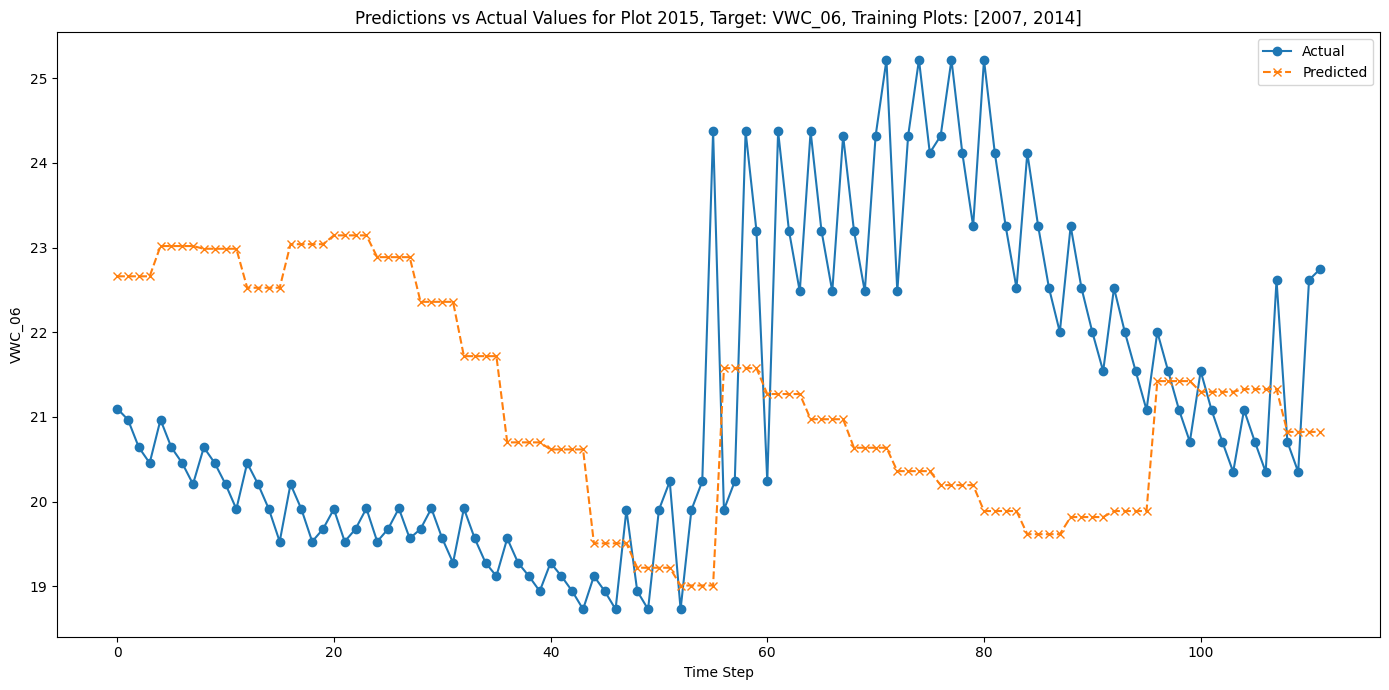

[[22.66087627 22.66087627 22.66087627 22.66087627]
 [23.01803589 23.01803589 23.01803589 23.01803589]
 [22.98596191 22.98596191 22.98596191 22.98596191]
 [22.52565384 22.52565384 22.52565384 22.52565384]
 [23.0399828  23.0399828  23.0399828  23.0399828 ]
 [23.14412212 23.14412212 23.14412212 23.14412212]
 [22.88698006 22.88698006 22.88698006 22.88698006]
 [22.35960865 22.35960865 22.35960865 22.35960865]
 [21.71825981 21.71825981 21.71825981 21.71825981]
 [20.70050812 20.70050812 20.70050812 20.70050812]
 [20.61703777 20.61703777 20.61703777 20.61703777]
 [19.50835705 19.50835705 19.50835705 19.50835705]
 [19.22040844 19.22040844 19.22040844 19.22040844]
 [19.01076984 19.01076984 19.01076984 19.01076984]
 [21.57658768 21.57658768 21.57658768 21.57658768]
 [21.27126789 21.27126789 21.27126789 21.27126789]
 [20.97371578 20.97371578 20.97371578 20.97371578]
 [20.63694    20.63694    20.63694    20.63694   ]
 [20.36098099 20.36098099 20.36098099 20.36098099]
 [20.19565487 20.19565487 20.19

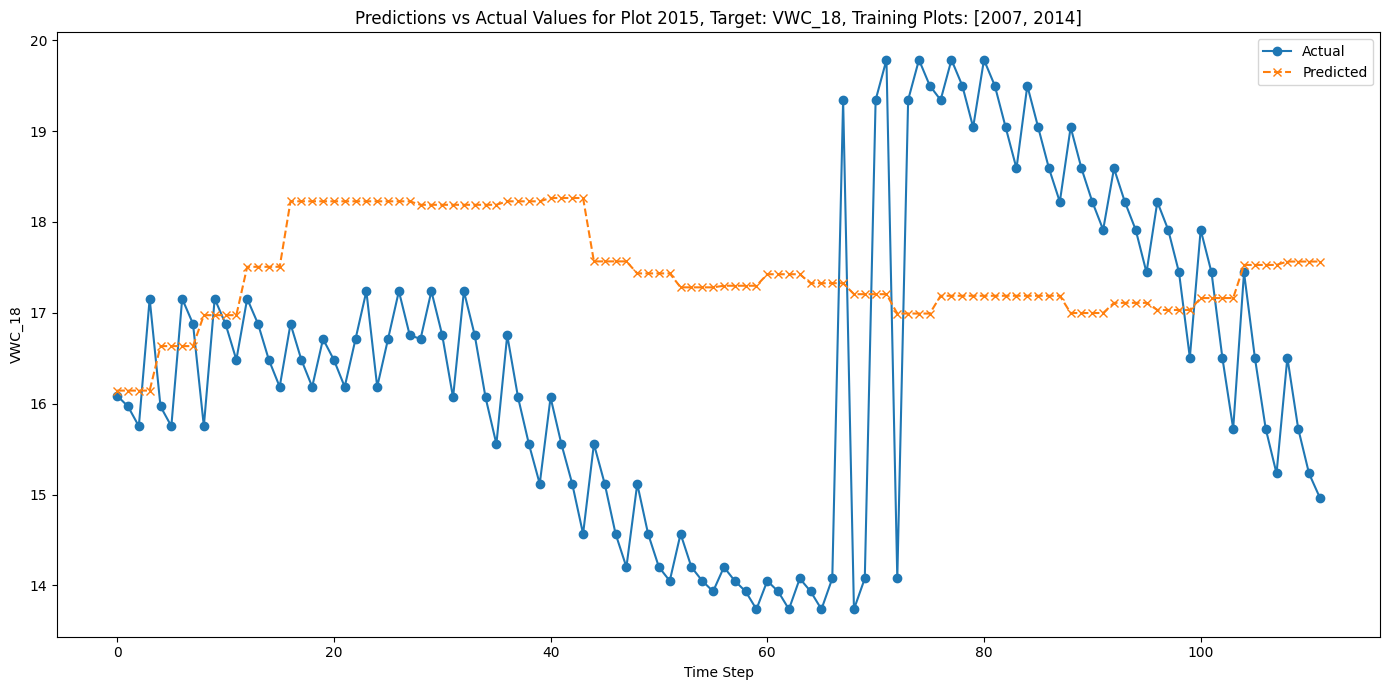

[[16.14404774 16.14404774 16.14404774 16.14404774]
 [16.63357782 16.63357782 16.63357782 16.63357782]
 [16.97408009 16.97408009 16.97408009 16.97408009]
 [17.50626755 17.50626755 17.50626755 17.50626755]
 [18.22679663 18.22679663 18.22679663 18.22679663]
 [18.22679663 18.22679663 18.22679663 18.22679663]
 [18.22679663 18.22679663 18.22679663 18.22679663]
 [18.18850231 18.18850231 18.18850231 18.18850231]
 [18.18850231 18.18850231 18.18850231 18.18850231]
 [18.22679663 18.22679663 18.22679663 18.22679663]
 [18.26324701 18.26324701 18.26324701 18.26324701]
 [17.56576347 17.56576347 17.56576347 17.56576347]
 [17.43370438 17.43370438 17.43370438 17.43370438]
 [17.28022194 17.28022194 17.28022194 17.28022194]
 [17.29784298 17.29784298 17.29784298 17.29784298]
 [17.42438555 17.42438555 17.42438555 17.42438555]
 [17.32577562 17.32577562 17.32577562 17.32577562]
 [17.20490026 17.20490026 17.20490026 17.20490026]
 [16.99195433 16.99195433 16.99195433 16.99195433]
 [17.18743086 17.18743086 17.18

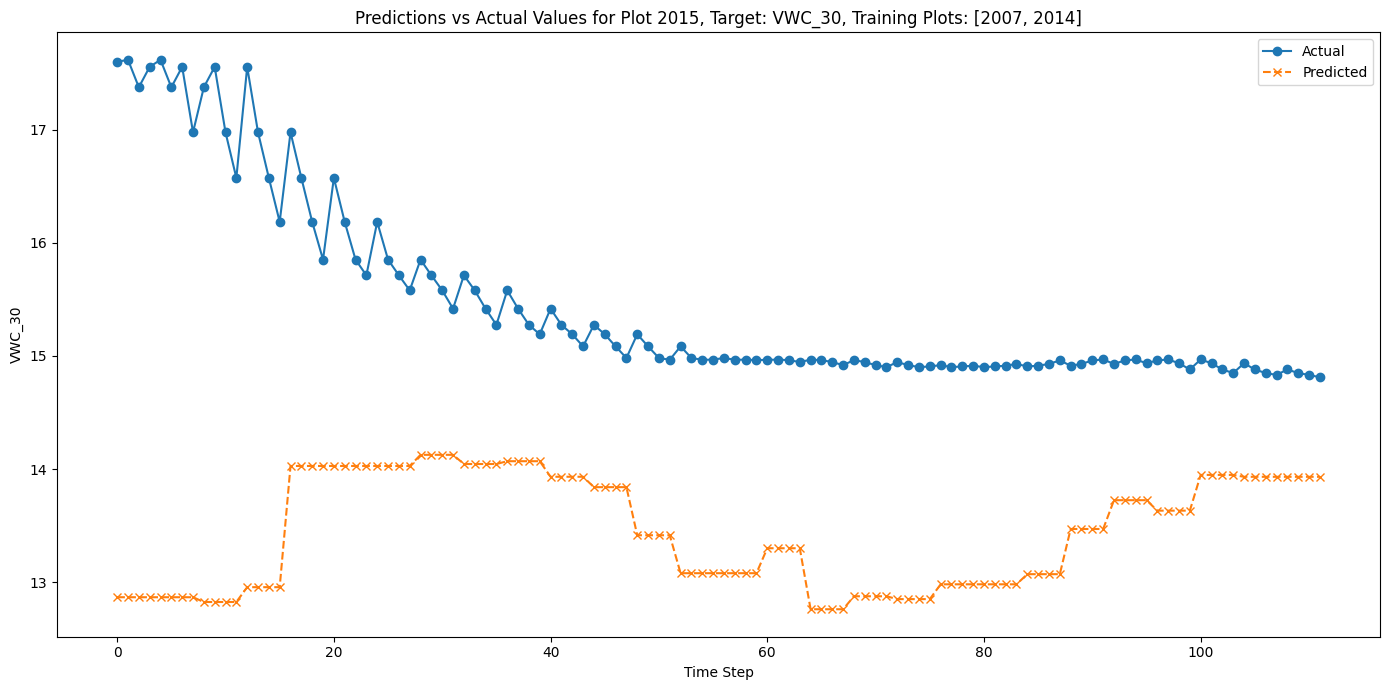

[[12.86712599 12.86712599 12.86712599 12.86712599]
 [12.86712599 12.86712599 12.86712599 12.86712599]
 [12.82504272 12.82504272 12.82504272 12.82504272]
 [12.95604229 12.95604229 12.95604229 12.95604229]
 [14.02741098 14.02741098 14.02741098 14.02741098]
 [14.02741098 14.02741098 14.02741098 14.02741098]
 [14.02741098 14.02741098 14.02741098 14.02741098]
 [14.1259799  14.1259799  14.1259799  14.1259799 ]
 [14.04489565 14.04489565 14.04489565 14.04489565]
 [14.06950951 14.06950951 14.06950951 14.06950951]
 [13.93207073 13.93207073 13.93207073 13.93207073]
 [13.84019756 13.84019756 13.84019756 13.84019756]
 [13.41509151 13.41509151 13.41509151 13.41509151]
 [13.07954502 13.07954502 13.07954502 13.07954502]
 [13.07954502 13.07954502 13.07954502 13.07954502]
 [13.30021954 13.30021954 13.30021954 13.30021954]
 [12.76088476 12.76088476 12.76088476 12.76088476]
 [12.87575674 12.87575674 12.87575674 12.87575674]
 [12.85040379 12.85040379 12.85040379 12.85040379]
 [12.98140335 12.98140335 12.98

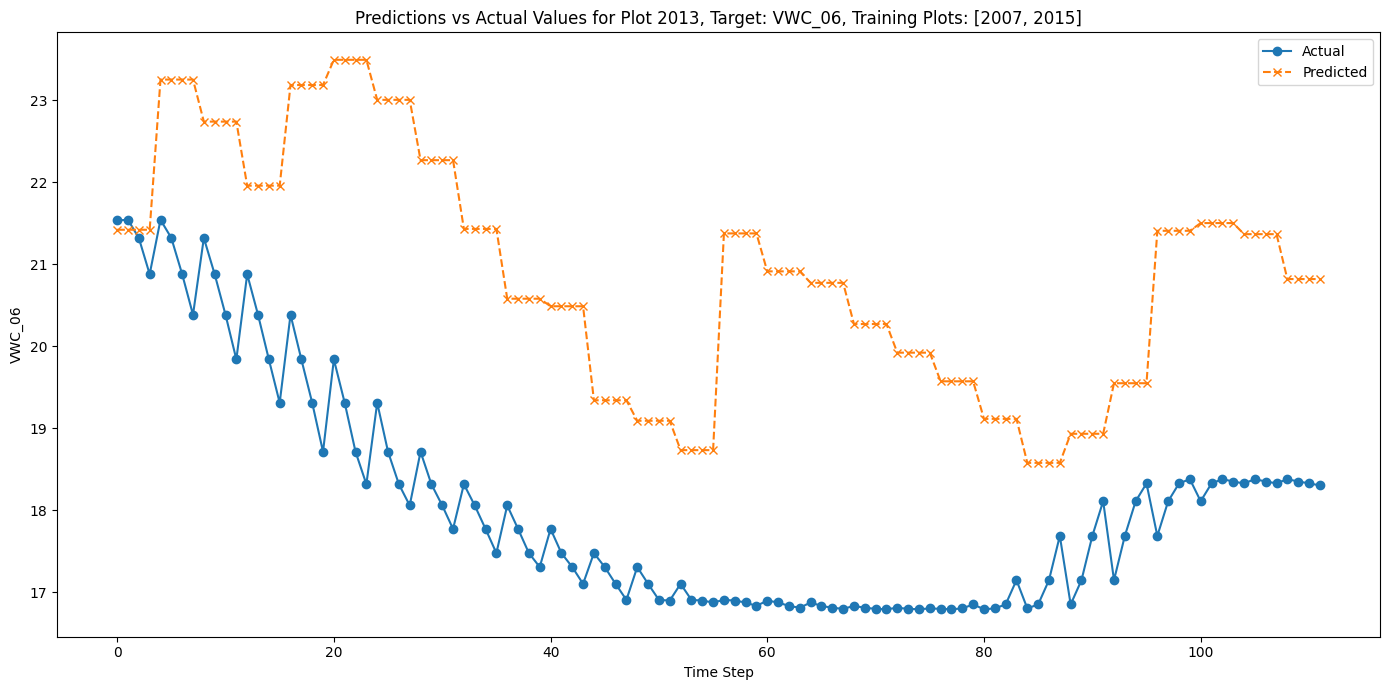

[[21.42350006 21.42350006 21.42350006 21.42350006]
 [23.25527096 23.25527096 23.25527096 23.25527096]
 [22.74232769 22.74232769 22.74232769 22.74232769]
 [21.9609108  21.9609108  21.9609108  21.9609108 ]
 [23.18863964 23.18863964 23.18863964 23.18863964]
 [23.49603081 23.49603081 23.49603081 23.49603081]
 [23.00780582 23.00780582 23.00780582 23.00780582]
 [22.2719593  22.2719593  22.2719593  22.2719593 ]
 [21.43378258 21.43378258 21.43378258 21.43378258]
 [20.58241177 20.58241177 20.58241177 20.58241177]
 [20.49042034 20.49042034 20.49042034 20.49042034]
 [19.34378624 19.34378624 19.34378624 19.34378624]
 [19.09400749 19.09400749 19.09400749 19.09400749]
 [18.73570251 18.73570251 18.73570251 18.73570251]
 [21.37890625 21.37890625 21.37890625 21.37890625]
 [20.9160862  20.9160862  20.9160862  20.9160862 ]
 [20.77624226 20.77624226 20.77624226 20.77624226]
 [20.27374172 20.27374172 20.27374172 20.27374172]
 [19.92444324 19.92444324 19.92444324 19.92444324]
 [19.57500553 19.57500553 19.57

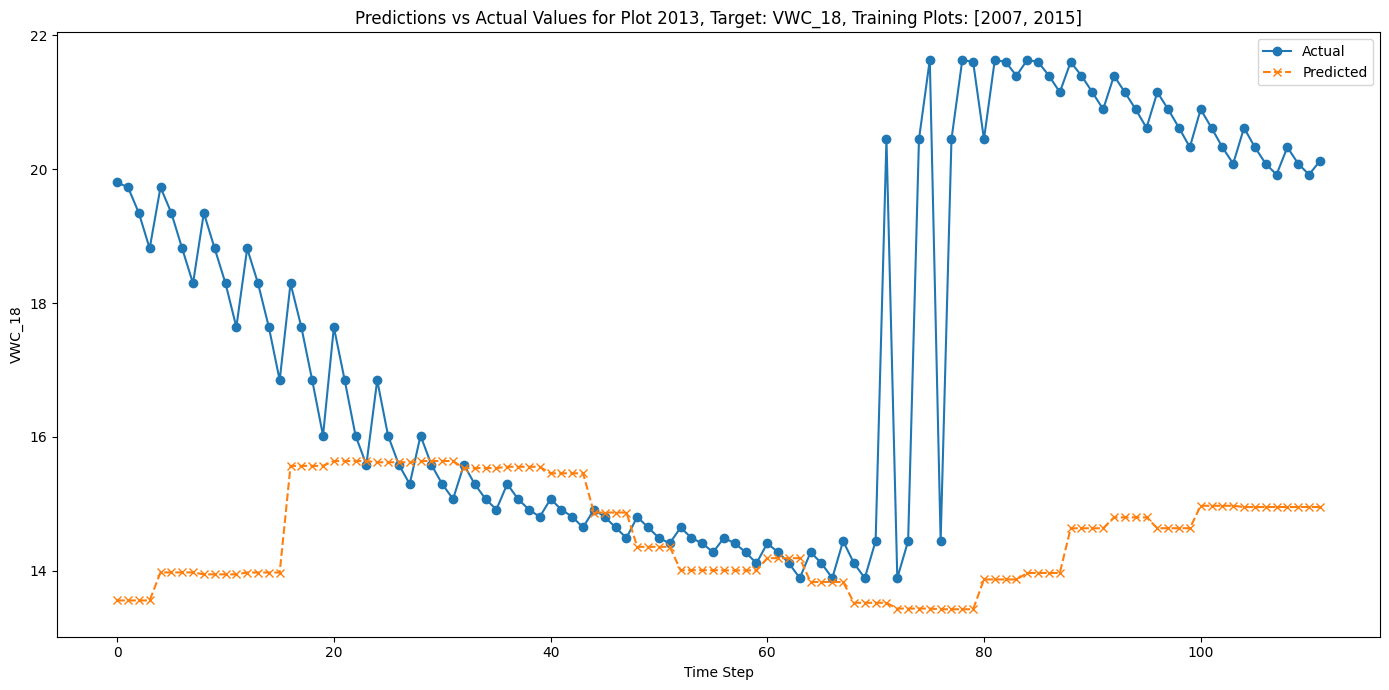

[[13.55822754 13.55822754 13.55822754 13.55822754]
 [13.97677708 13.97677708 13.97677708 13.97677708]
 [13.94763231 13.94763231 13.94763231 13.94763231]
 [13.97555304 13.97555304 13.97555304 13.97555304]
 [15.56808376 15.56808376 15.56808376 15.56808376]
 [15.64033318 15.64033318 15.64033318 15.64033318]
 [15.62205791 15.62205791 15.62205791 15.62205791]
 [15.64033318 15.64033318 15.64033318 15.64033318]
 [15.53480577 15.53480577 15.53480577 15.53480577]
 [15.55429363 15.55429363 15.55429363 15.55429363]
 [15.4573431  15.4573431  15.4573431  15.4573431 ]
 [14.87131548 14.87131548 14.87131548 14.87131548]
 [14.35886574 14.35886574 14.35886574 14.35886574]
 [14.0101552  14.0101552  14.0101552  14.0101552 ]
 [14.00699425 14.00699425 14.00699425 14.00699425]
 [14.18966389 14.18966389 14.18966389 14.18966389]
 [13.83380222 13.83380222 13.83380222 13.83380222]
 [13.5234313  13.5234313  13.5234313  13.5234313 ]
 [13.43718576 13.43718576 13.43718576 13.43718576]
 [13.42681217 13.42681217 13.42

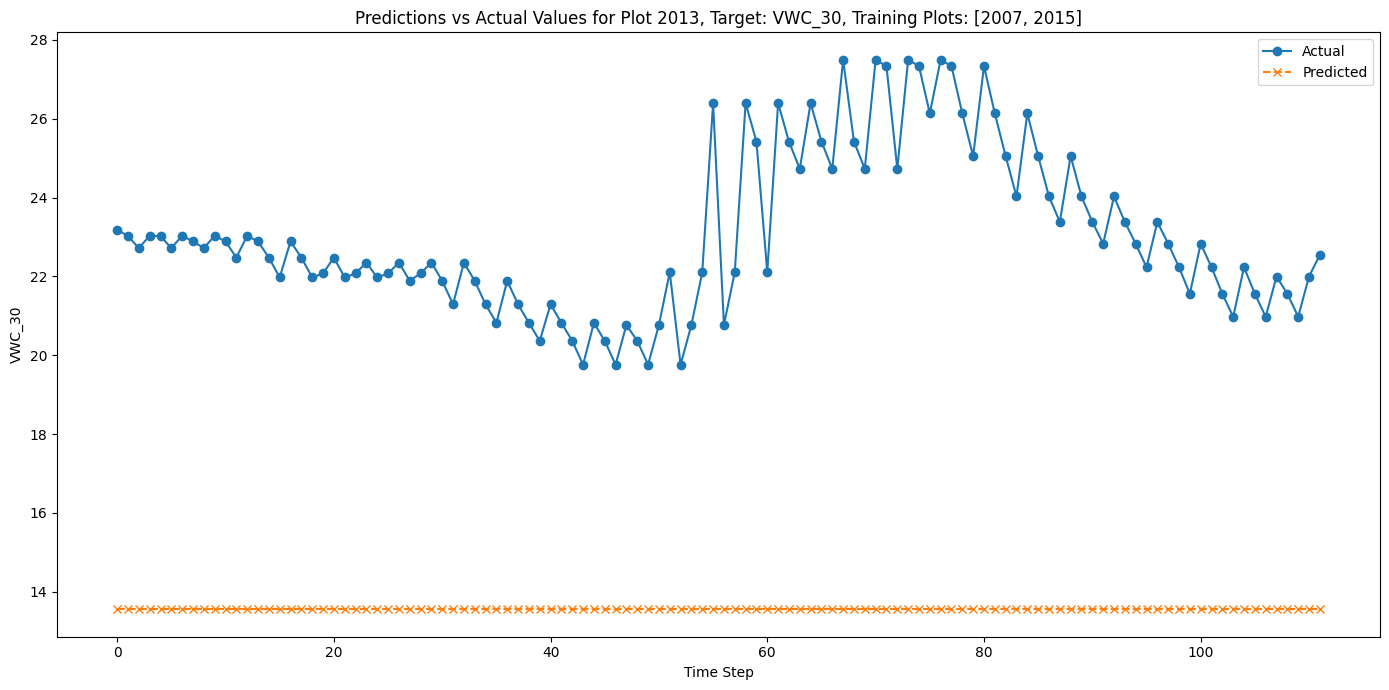

[[13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55

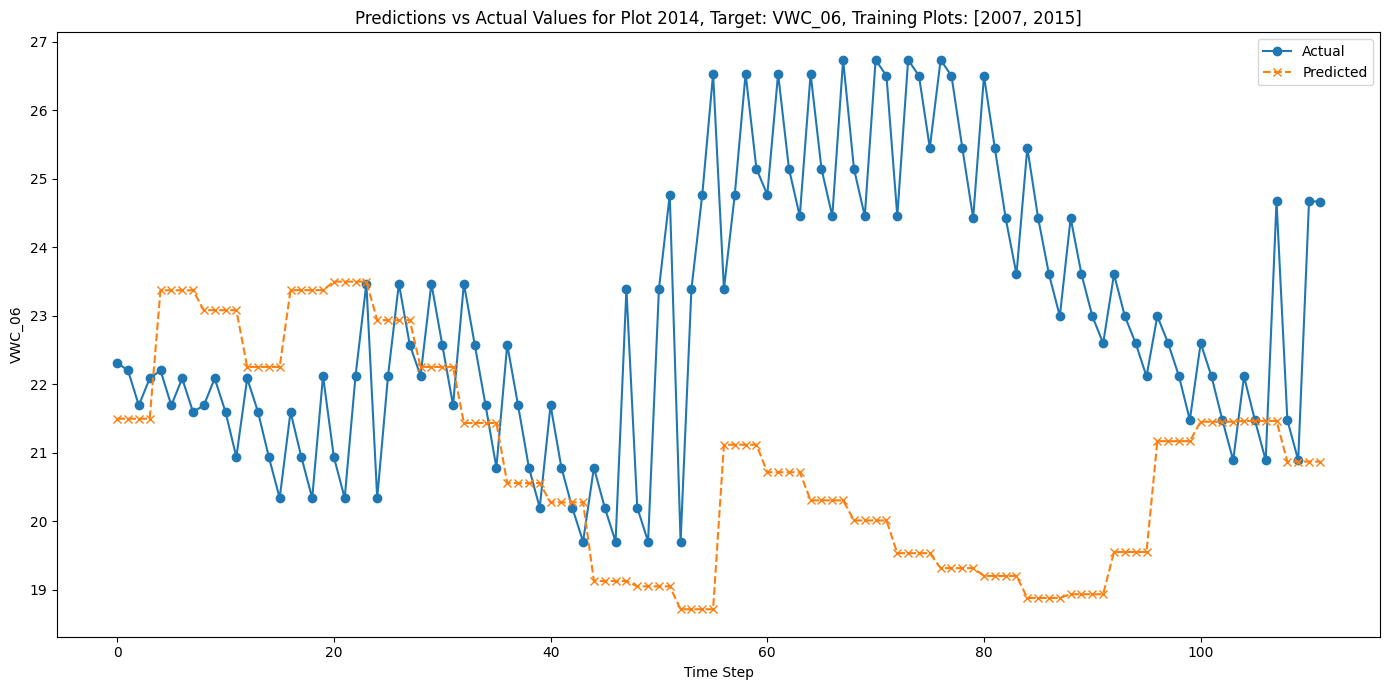

[[21.4961462  21.4961462  21.4961462  21.4961462 ]
 [23.37007141 23.37007141 23.37007141 23.37007141]
 [23.08016109 23.08016109 23.08016109 23.08016109]
 [22.25244141 22.25244141 22.25244141 22.25244141]
 [23.37235355 23.37235355 23.37235355 23.37235355]
 [23.4966898  23.4966898  23.4966898  23.4966898 ]
 [22.9348259  22.9348259  22.9348259  22.9348259 ]
 [22.25253963 22.25253963 22.25253963 22.25253963]
 [21.43378258 21.43378258 21.43378258 21.43378258]
 [20.5576334  20.5576334  20.5576334  20.5576334 ]
 [20.27567673 20.27567673 20.27567673 20.27567673]
 [19.12904263 19.12904263 19.12904263 19.12904263]
 [19.05036259 19.05036259 19.05036259 19.05036259]
 [18.71628284 18.71628284 18.71628284 18.71628284]
 [21.11727619 21.11727619 21.11727619 21.11727619]
 [20.71623707 20.71623707 20.71623707 20.71623707]
 [20.30502033 20.30502033 20.30502033 20.30502033]
 [20.01190472 20.01190472 20.01190472 20.01190472]
 [19.5346241  19.5346241  19.5346241  19.5346241 ]
 [19.31622219 19.31622219 19.31

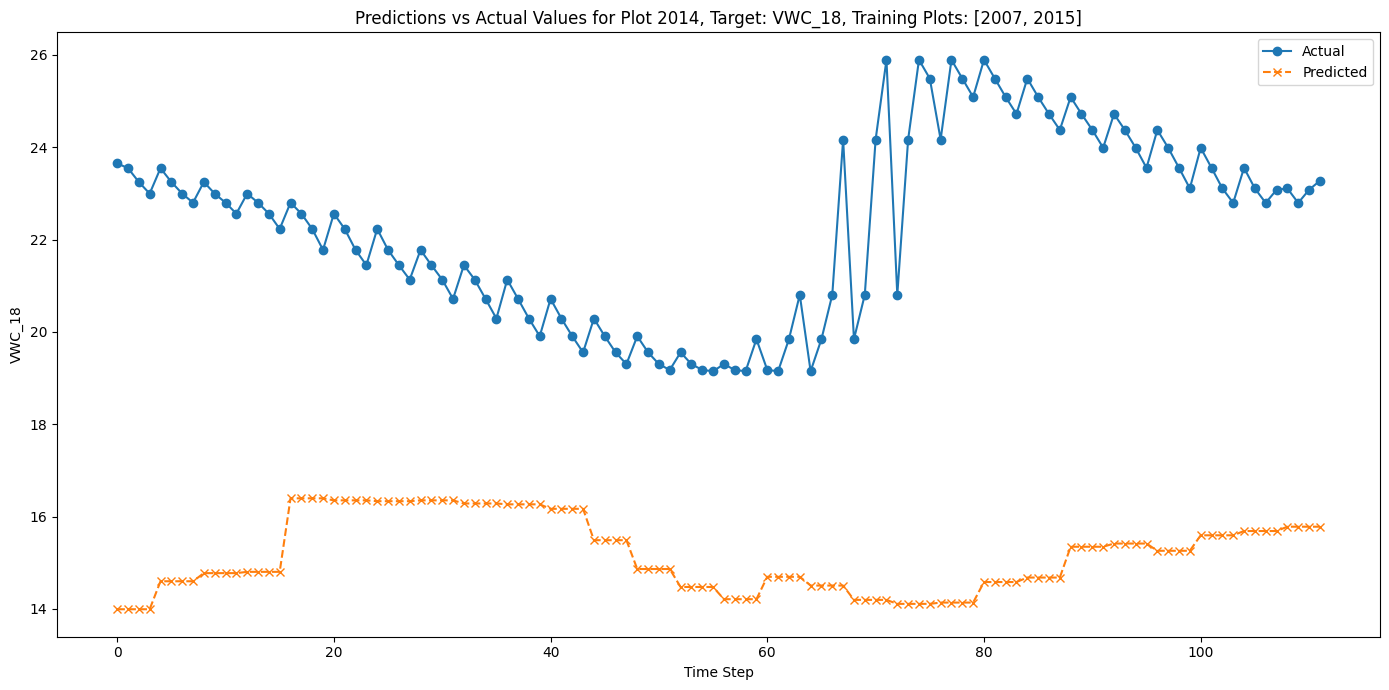

[[13.99224854 13.99224854 13.99224854 13.99224854]
 [14.59839249 14.59839249 14.59839249 14.59839249]
 [14.77445841 14.77445841 14.77445841 14.77445841]
 [14.80237818 14.80237818 14.80237818 14.80237818]
 [16.39491129 16.39491129 16.39491129 16.39491129]
 [16.35050726 16.35050726 16.35050726 16.35050726]
 [16.332232   16.332232   16.332232   16.332232  ]
 [16.35050726 16.35050726 16.35050726 16.35050726]
 [16.28327417 16.28327417 16.28327417 16.28327417]
 [16.26446772 16.26446772 16.26446772 16.26446772]
 [16.16751528 16.16751528 16.16751528 16.16751528]
 [15.48782921 15.48782921 15.48782921 15.48782921]
 [14.8638258  14.8638258  14.8638258  14.8638258 ]
 [14.47471476 14.47471476 14.47471476 14.47471476]
 [14.21003675 14.21003675 14.21003675 14.21003675]
 [14.6946249  14.6946249  14.6946249  14.6946249 ]
 [14.50567961 14.50567961 14.50567961 14.50567961]
 [14.19530869 14.19530869 14.19530869 14.19530869]
 [14.10906315 14.10906315 14.10906315 14.10906315]
 [14.13698292 14.13698292 14.13

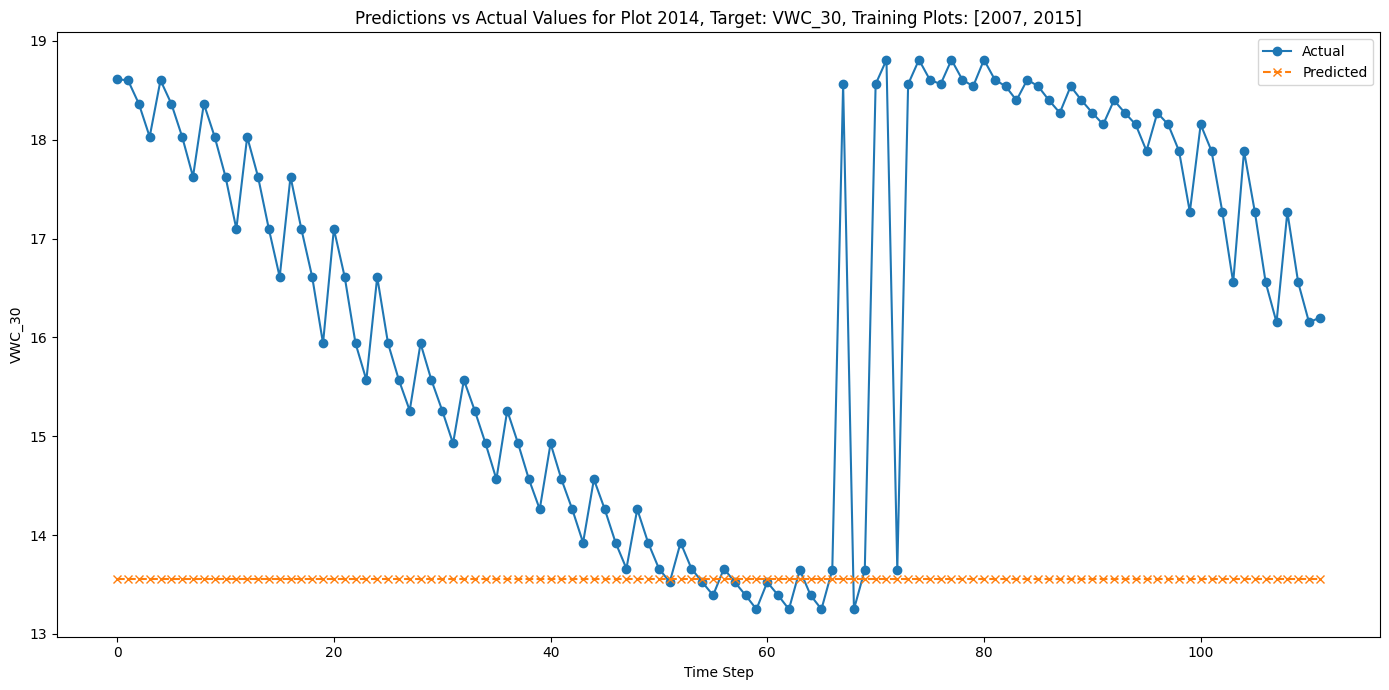

[[13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55

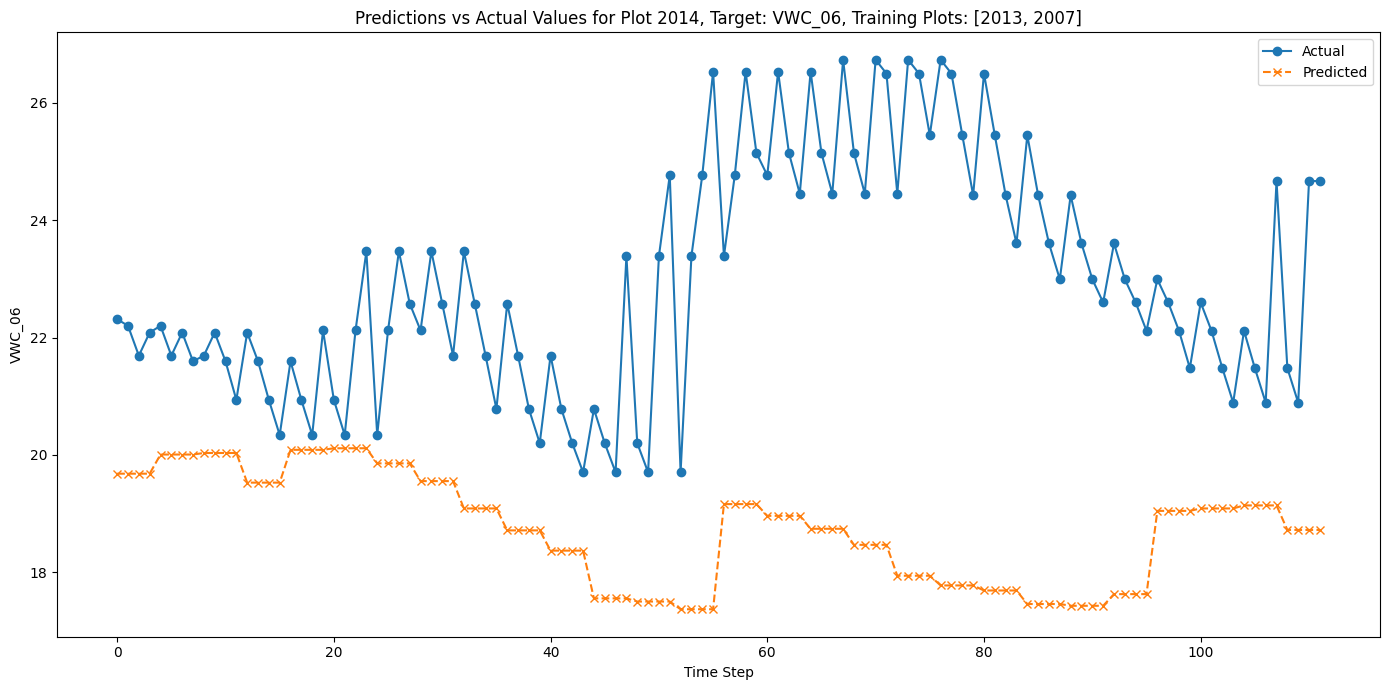

[[19.6796751  19.6796751  19.6796751  19.6796751 ]
 [20.00605965 20.00605965 20.00605965 20.00605965]
 [20.03222466 20.03222466 20.03222466 20.03222466]
 [19.52705002 19.52705002 19.52705002 19.52705002]
 [20.08624554 20.08624554 20.08624554 20.08624554]
 [20.11272621 20.11272621 20.11272621 20.11272621]
 [19.85558414 19.85558414 19.85558414 19.85558414]
 [19.55298901 19.55298901 19.55298901 19.55298901]
 [19.08699894 19.08699894 19.08699894 19.08699894]
 [18.71299458 18.71299458 18.71299458 18.71299458]
 [18.36815548 18.36815548 18.36815548 18.36815548]
 [17.55429268 17.55429268 17.55429268 17.55429268]
 [17.50035858 17.50035858 17.50035858 17.50035858]
 [17.36896896 17.36896896 17.36896896 17.36896896]
 [19.16121197 19.16121197 19.16121197 19.16121197]
 [18.96113396 18.96113396 18.96113396 18.96113396]
 [18.74063683 18.74063683 18.74063683 18.74063683]
 [18.46681118 18.46681118 18.46681118 18.46681118]
 [17.9401741  17.9401741  17.9401741  17.9401741 ]
 [17.77484798 17.77484798 17.77

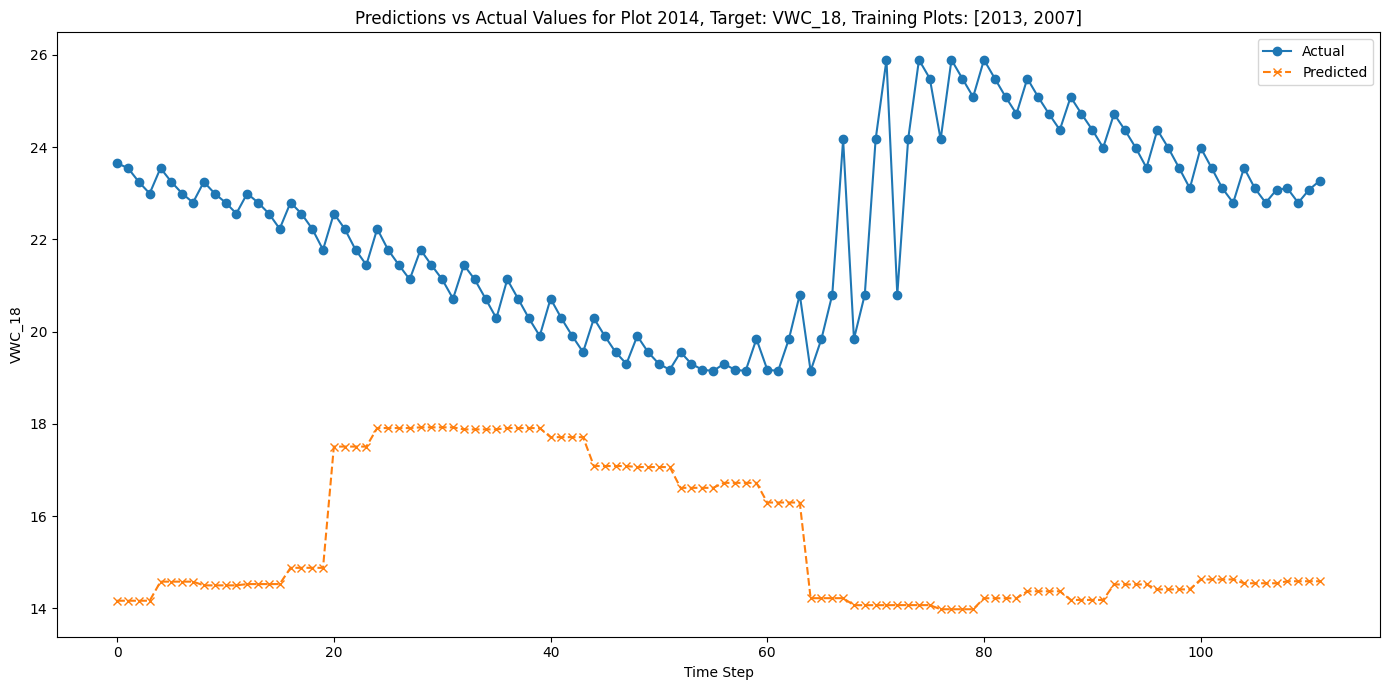

[[14.16740704 14.16740704 14.16740704 14.16740704]
 [14.5811305  14.5811305  14.5811305  14.5811305 ]
 [14.50034189 14.50034189 14.50034189 14.50034189]
 [14.52819586 14.52819586 14.52819586 14.52819586]
 [14.88067198 14.88067198 14.88067198 14.88067198]
 [17.50860357 17.50860357 17.50860357 17.50860357]
 [17.91005564 17.91005564 17.91005564 17.91005564]
 [17.92545271 17.92545271 17.92545271 17.92545271]
 [17.88091803 17.88091803 17.88091803 17.88091803]
 [17.90956736 17.90956736 17.90956736 17.90956736]
 [17.71299887 17.71299887 17.71299887 17.71299887]
 [17.08691311 17.08691311 17.08691311 17.08691311]
 [17.06456089 17.06456089 17.06456089 17.06456089]
 [16.61412382 16.61412382 16.61412382 16.61412382]
 [16.72217607 16.72217607 16.72217607 16.72217607]
 [16.29621601 16.29621601 16.29621601 16.29621601]
 [14.2225461  14.2225461  14.2225461  14.2225461 ]
 [14.07093859 14.07093859 14.07093859 14.07093859]
 [14.07231522 14.07231522 14.07231522 14.07231522]
 [13.98260117 13.98260117 13.98

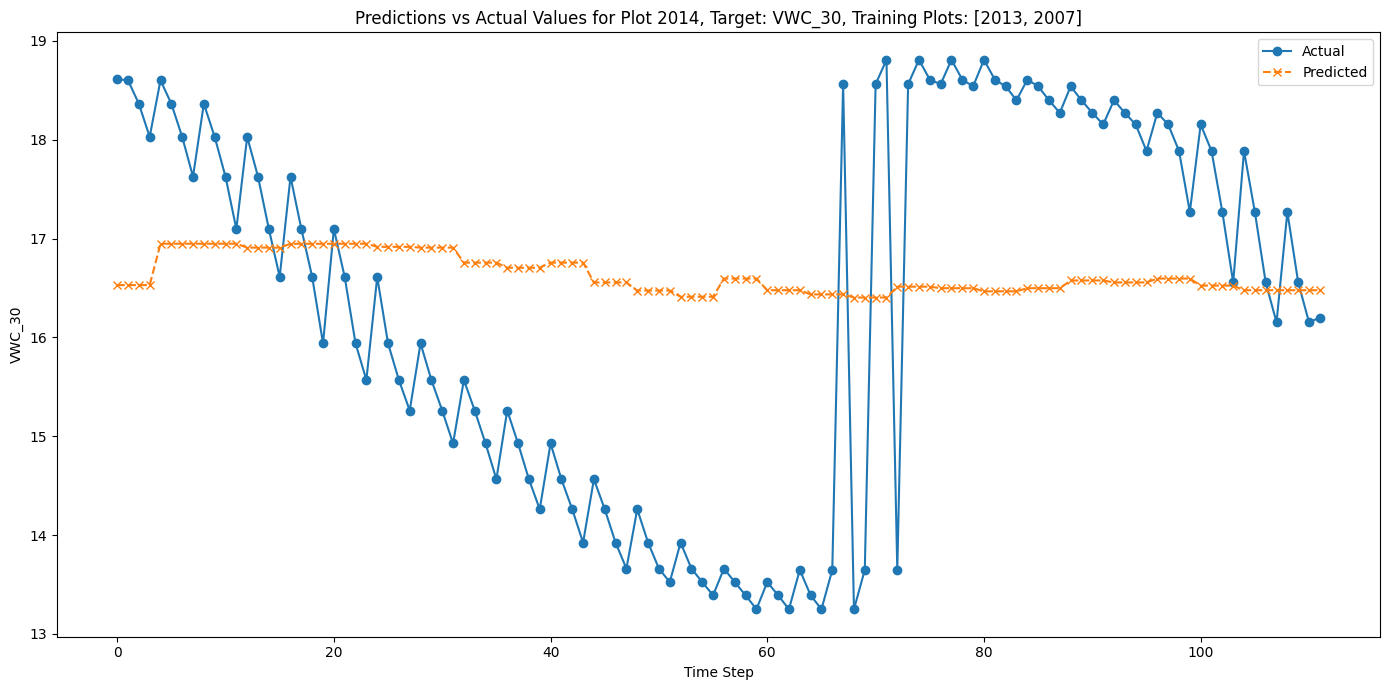

[[16.52980471 16.52980471 16.52980471 16.52980471]
 [16.94846296 16.94846296 16.94846296 16.94846296]
 [16.94846296 16.94846296 16.94846296 16.94846296]
 [16.90899515 16.90899515 16.90899515 16.90899515]
 [16.94787931 16.94787931 16.94787931 16.94787931]
 [16.94846296 16.94846296 16.94846296 16.94846296]
 [16.91693068 16.91693068 16.91693068 16.91693068]
 [16.90899515 16.90899515 16.90899515 16.90899515]
 [16.75711393 16.75711393 16.75711393 16.75711393]
 [16.70542192 16.70542192 16.70542192 16.70542192]
 [16.75711393 16.75711393 16.75711393 16.75711393]
 [16.55642843 16.55642843 16.55642843 16.55642843]
 [16.47483492 16.47483492 16.47483492 16.47483492]
 [16.4118495  16.4118495  16.4118495  16.4118495 ]
 [16.59589624 16.59589624 16.59589624 16.59589624]
 [16.4781127  16.4781127  16.4781127  16.4781127 ]
 [16.43569994 16.43569994 16.43569994 16.43569994]
 [16.40416765 16.40416765 16.40416765 16.40416765]
 [16.51401567 16.51401567 16.51401567 16.51401567]
 [16.49835157 16.49835157 16.49

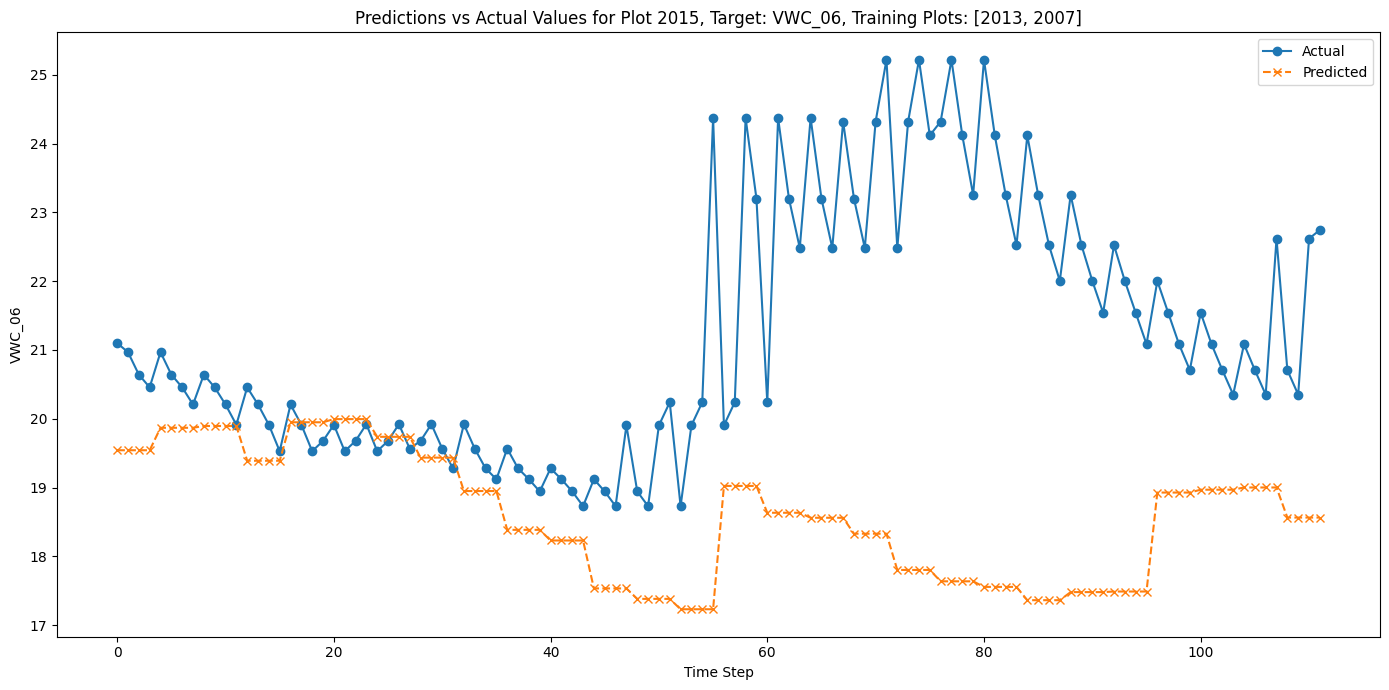

[[19.5427227  19.5427227  19.5427227  19.5427227 ]
 [19.86910725 19.86910725 19.86910725 19.86910725]
 [19.89527225 19.89527225 19.89527225 19.89527225]
 [19.39009762 19.39009762 19.39009762 19.39009762]
 [19.94929314 19.94929314 19.94929314 19.94929314]
 [19.99519348 19.99519348 19.99519348 19.99519348]
 [19.73805141 19.73805141 19.73805141 19.73805141]
 [19.43545628 19.43545628 19.43545628 19.43545628]
 [18.95004654 18.95004654 18.95004654 18.95004654]
 [18.38607693 18.38607693 18.38607693 18.38607693]
 [18.23120308 18.23120308 18.23120308 18.23120308]
 [17.53487301 17.53487301 17.53487301 17.53487301]
 [17.38282585 17.38282585 17.38282585 17.38282585]
 [17.23201656 17.23201656 17.23201656 17.23201656]
 [19.02425957 19.02425957 19.02425957 19.02425957]
 [18.63421631 18.63421631 18.63421631 18.63421631]
 [18.56144047 18.56144047 18.56144047 18.56144047]
 [18.32985878 18.32985878 18.32985878 18.32985878]
 [17.8032217  17.8032217  17.8032217  17.8032217 ]
 [17.63789558 17.63789558 17.63

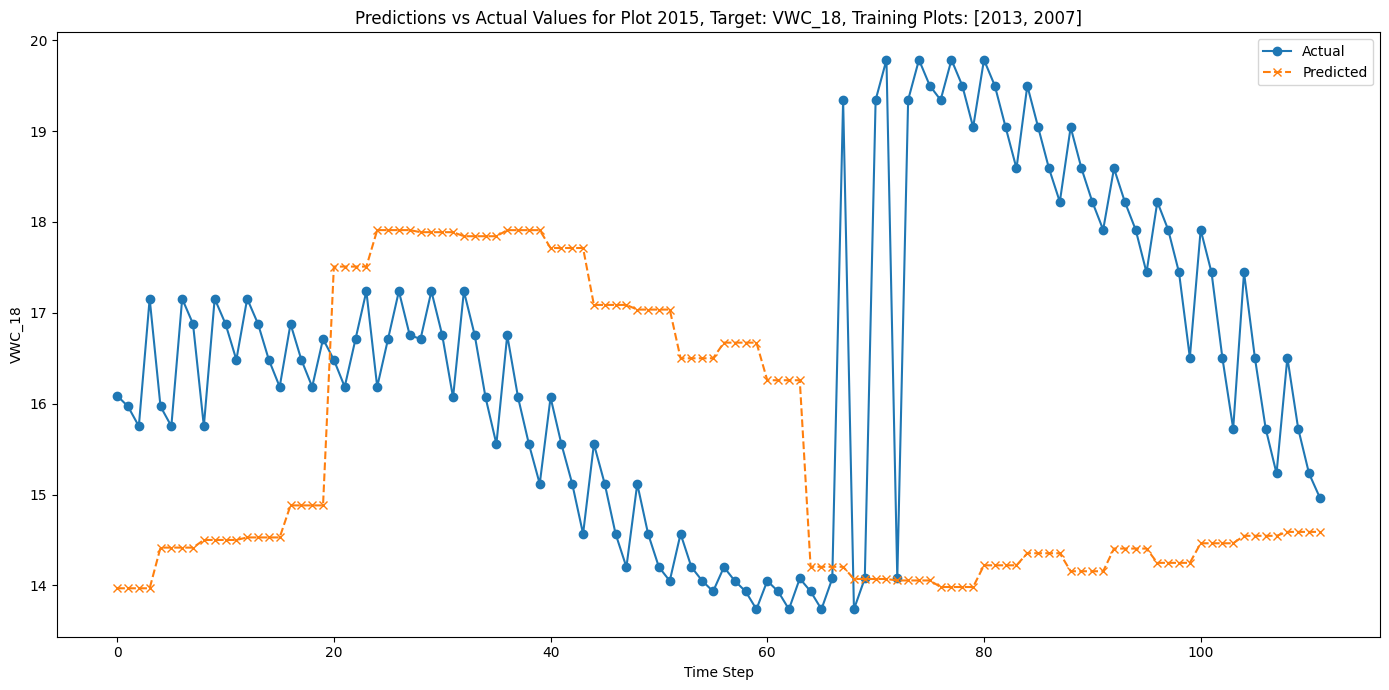

[[13.96867132 13.96867132 13.96867132 13.96867132]
 [14.41629362 14.41629362 14.41629362 14.41629362]
 [14.50034189 14.50034189 14.50034189 14.50034189]
 [14.52819586 14.52819586 14.52819586 14.52819586]
 [14.88067198 14.88067198 14.88067198 14.88067198]
 [17.50860357 17.50860357 17.50860357 17.50860357]
 [17.91005564 17.91005564 17.91005564 17.91005564]
 [17.88715839 17.88715839 17.88715839 17.88715839]
 [17.84262371 17.84262371 17.84262371 17.84262371]
 [17.90956736 17.90956736 17.90956736 17.90956736]
 [17.71299887 17.71299887 17.71299887 17.71299887]
 [17.08691311 17.08691311 17.08691311 17.08691311]
 [17.0355854  17.0355854  17.0355854  17.0355854 ]
 [16.49966526 16.49966526 16.49966526 16.49966526]
 [16.67179775 16.67179775 16.67179775 16.67179775]
 [16.2579217  16.2579217  16.2579217  16.2579217 ]
 [14.20490074 14.20490074 14.20490074 14.20490074]
 [14.07093859 14.07093859 14.07093859 14.07093859]
 [14.05466986 14.05466986 14.05466986 14.05466986]
 [13.98260117 13.98260117 13.98

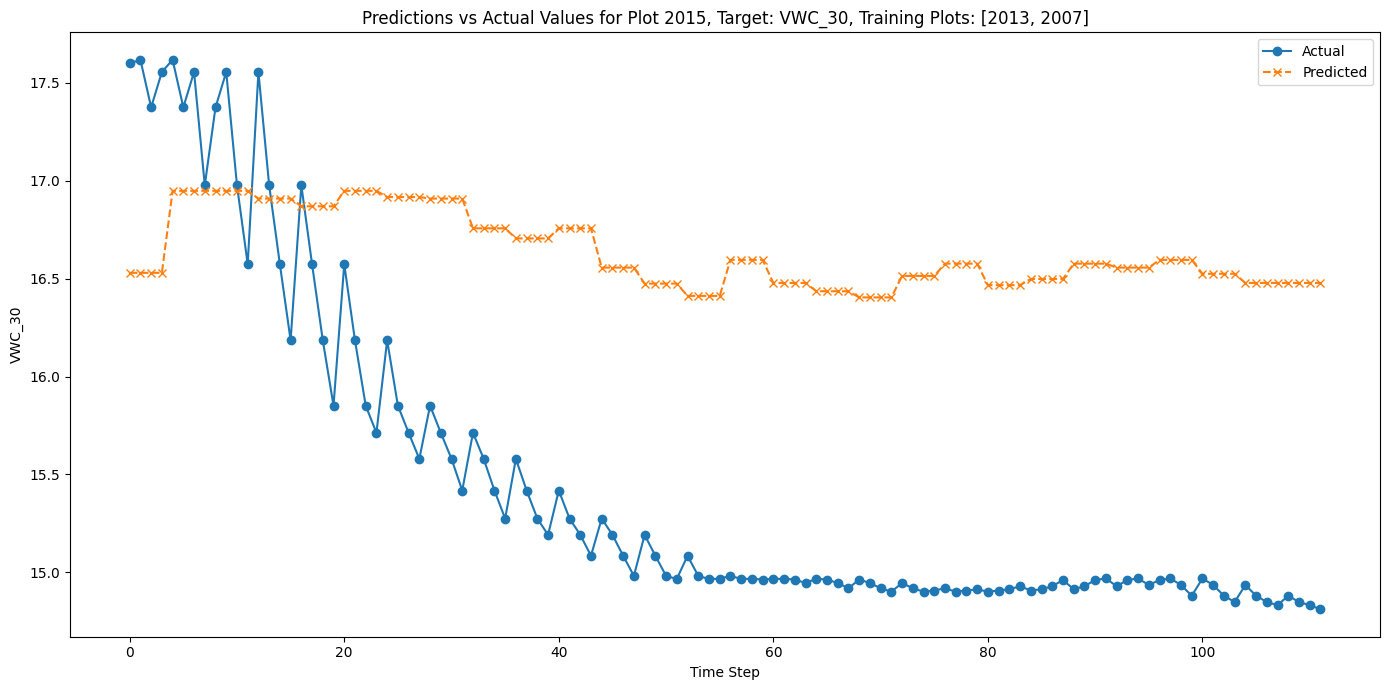

[[16.52980471 16.52980471 16.52980471 16.52980471]
 [16.94846296 16.94846296 16.94846296 16.94846296]
 [16.94846296 16.94846296 16.94846296 16.94846296]
 [16.90899515 16.90899515 16.90899515 16.90899515]
 [16.86956358 16.86956358 16.86956358 16.86956358]
 [16.94846296 16.94846296 16.94846296 16.94846296]
 [16.91693068 16.91693068 16.91693068 16.91693068]
 [16.90899515 16.90899515 16.90899515 16.90899515]
 [16.75711393 16.75711393 16.75711393 16.75711393]
 [16.70542192 16.70542192 16.70542192 16.70542192]
 [16.75711393 16.75711393 16.75711393 16.75711393]
 [16.55642843 16.55642843 16.55642843 16.55642843]
 [16.47483492 16.47483492 16.47483492 16.47483492]
 [16.4118495  16.4118495  16.4118495  16.4118495 ]
 [16.59589624 16.59589624 16.59589624 16.59589624]
 [16.4781127  16.4781127  16.4781127  16.4781127 ]
 [16.43569994 16.43569994 16.43569994 16.43569994]
 [16.40416765 16.40416765 16.40416765 16.40416765]
 [16.51401567 16.51401567 16.51401567 16.51401567]
 [16.57666731 16.57666731 16.57

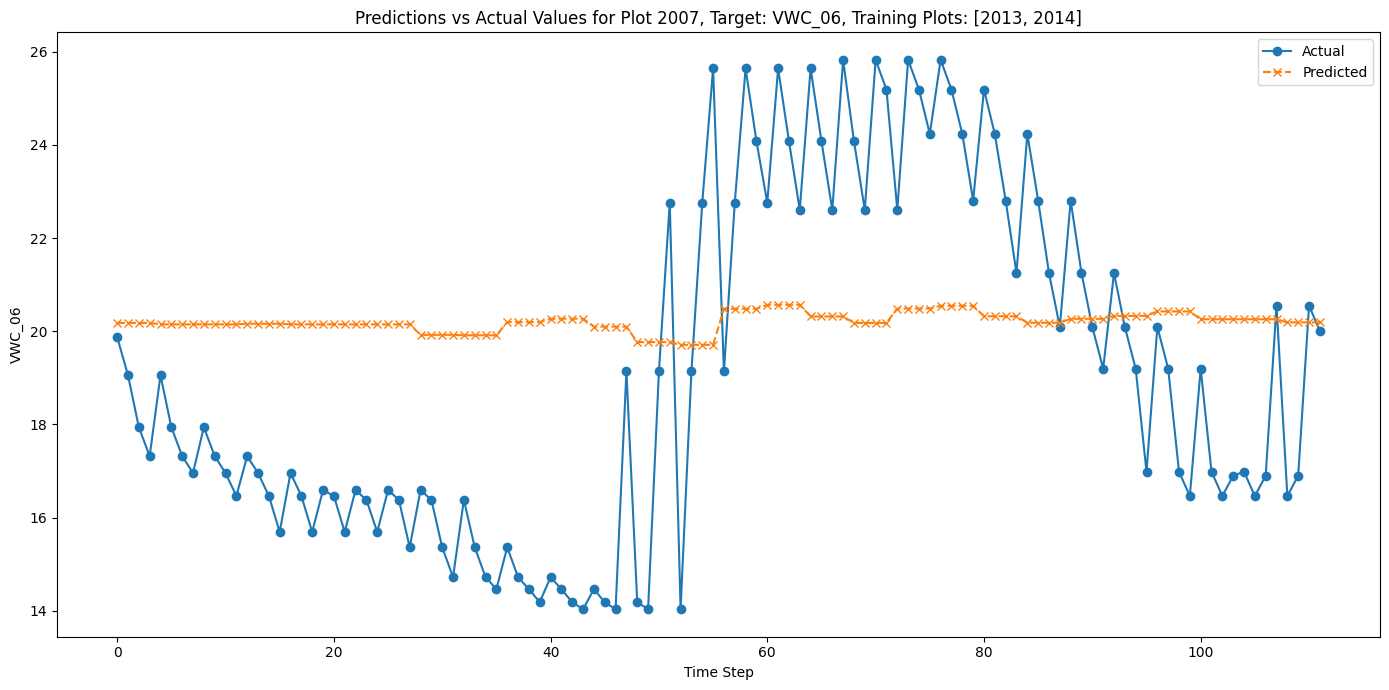

[[20.17885876 20.17885876 20.17885876 20.17885876]
 [20.14808369 20.14808369 20.14808369 20.14808369]
 [20.14808369 20.14808369 20.14808369 20.14808369]
 [20.16145611 20.16145611 20.16145611 20.16145611]
 [20.14808369 20.14808369 20.14808369 20.14808369]
 [20.14808369 20.14808369 20.14808369 20.14808369]
 [20.14808369 20.14808369 20.14808369 20.14808369]
 [19.92330742 19.92330742 19.92330742 19.92330742]
 [19.91332245 19.91332245 19.91332245 19.91332245]
 [20.1969099  20.1969099  20.1969099  20.1969099 ]
 [20.26831341 20.26831341 20.26831341 20.26831341]
 [20.09861851 20.09861851 20.09861851 20.09861851]
 [19.76752567 19.76752567 19.76752567 19.76752567]
 [19.70869637 19.70869637 19.70869637 19.70869637]
 [20.48227119 20.48227119 20.48227119 20.48227119]
 [20.56699467 20.56699467 20.56699467 20.56699467]
 [20.31678963 20.31678963 20.31678963 20.31678963]
 [20.17878532 20.17878532 20.17878532 20.17878532]
 [20.48770237 20.48770237 20.48770237 20.48770237]
 [20.54594135 20.54594135 20.54

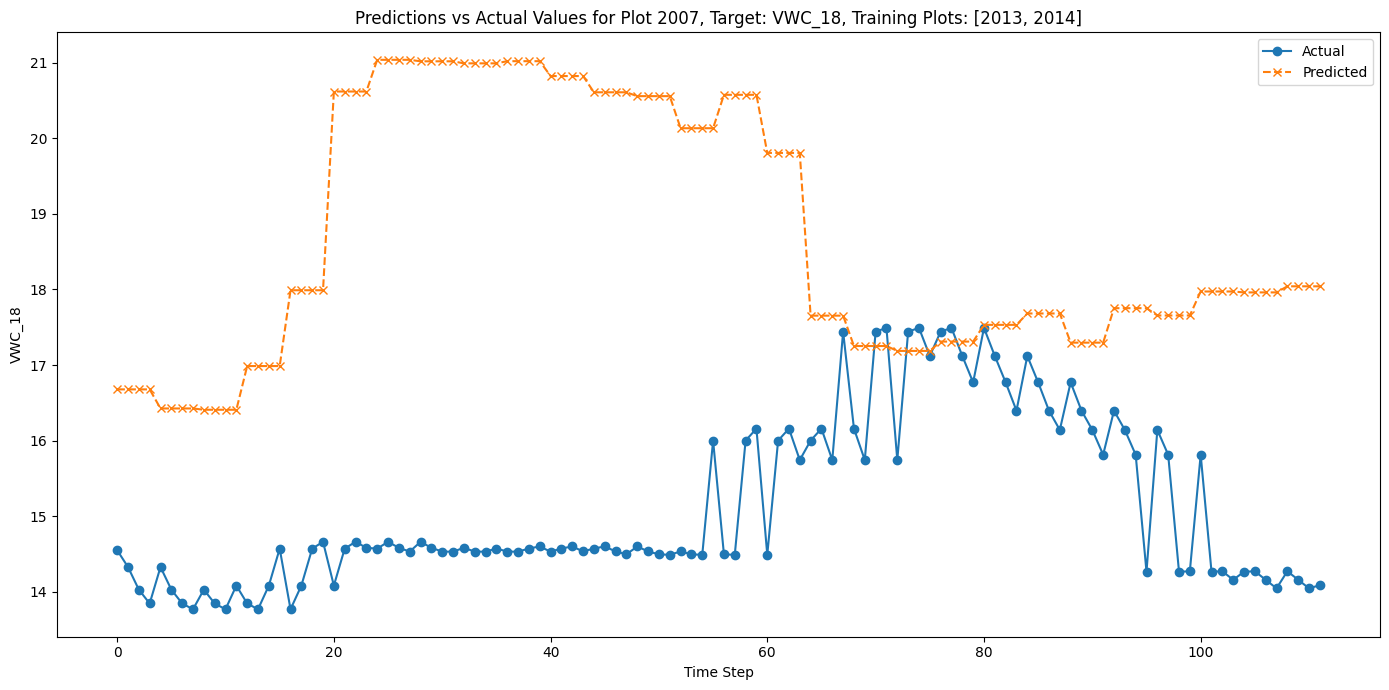

[[16.67810154 16.67810154 16.67810154 16.67810154]
 [16.42585897 16.42585897 16.42585897 16.42585897]
 [16.40885639 16.40885639 16.40885639 16.40885639]
 [16.98654222 16.98654222 16.98654222 16.98654222]
 [17.98904228 17.98904228 17.98904228 17.98904228]
 [20.61697388 20.61697388 20.61697388 20.61697388]
 [21.03607178 21.03607178 21.03607178 21.03607178]
 [21.01617718 21.01617718 21.01617718 21.01617718]
 [20.98928833 20.98928833 20.98928833 20.98928833]
 [21.01793766 21.01793766 21.01793766 21.01793766]
 [20.82136917 20.82136917 20.82136917 20.82136917]
 [20.60645485 20.60645485 20.60645485 20.60645485]
 [20.55556774 20.55556774 20.55556774 20.55556774]
 [20.13136578 20.13136578 20.13136578 20.13136578]
 [20.57326698 20.57326698 20.57326698 20.57326698]
 [19.8048687  19.8048687  19.8048687  19.8048687 ]
 [17.65323782 17.65323782 17.65323782 17.65323782]
 [17.25169468 17.25169468 17.25169468 17.25169468]
 [17.186831   17.186831   17.186831   17.186831  ]
 [17.31023884 17.31023884 17.31

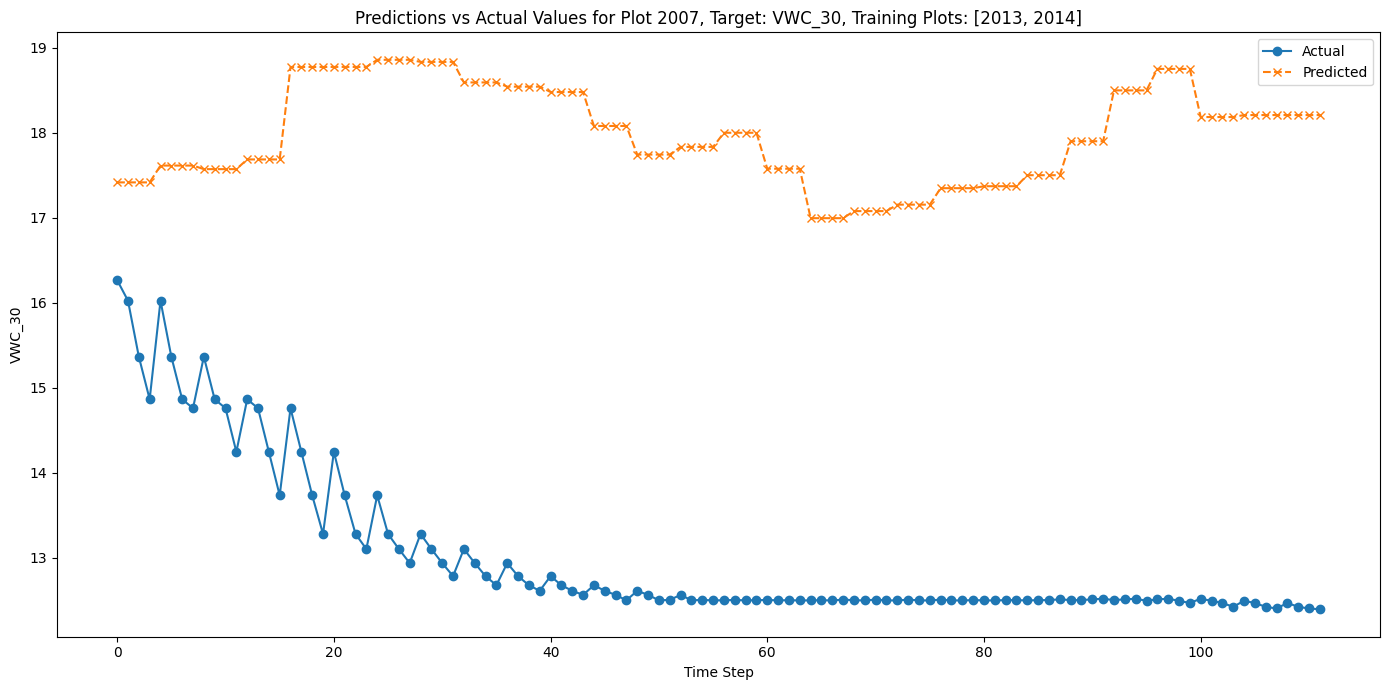

[[17.41818047 17.41818047 17.41818047 17.41818047]
 [17.61612892 17.61612892 17.61612892 17.61612892]
 [17.57404566 17.57404566 17.57404566 17.57404566]
 [17.68814421 17.68814421 17.68814421 17.68814421]
 [18.77583027 18.77583027 18.77583027 18.77583027]
 [18.77641392 18.77641392 18.77641392 18.77641392]
 [18.86018181 18.86018181 18.86018181 18.86018181]
 [18.83551502 18.83551502 18.83551502 18.83551502]
 [18.5939188  18.5939188  18.5939188  18.5939188 ]
 [18.54427385 18.54427385 18.54427385 18.54427385]
 [18.48109388 18.48109388 18.48109388 18.48109388]
 [18.08186626 18.08186626 18.08186626 18.08186626]
 [17.74513578 17.74513578 17.74513578 17.74513578]
 [17.83566713 17.83566713 17.83566713 17.83566713]
 [18.00200701 18.00200701 18.00200701 18.00200701]
 [17.5788722  17.5788722  17.5788722  17.5788722 ]
 [16.99712467 16.99712467 16.99712467 16.99712467]
 [17.08046436 17.08046436 17.08046436 17.08046436]
 [17.15632868 17.15632868 17.15632868 17.15632868]
 [17.34997988 17.34997988 17.34

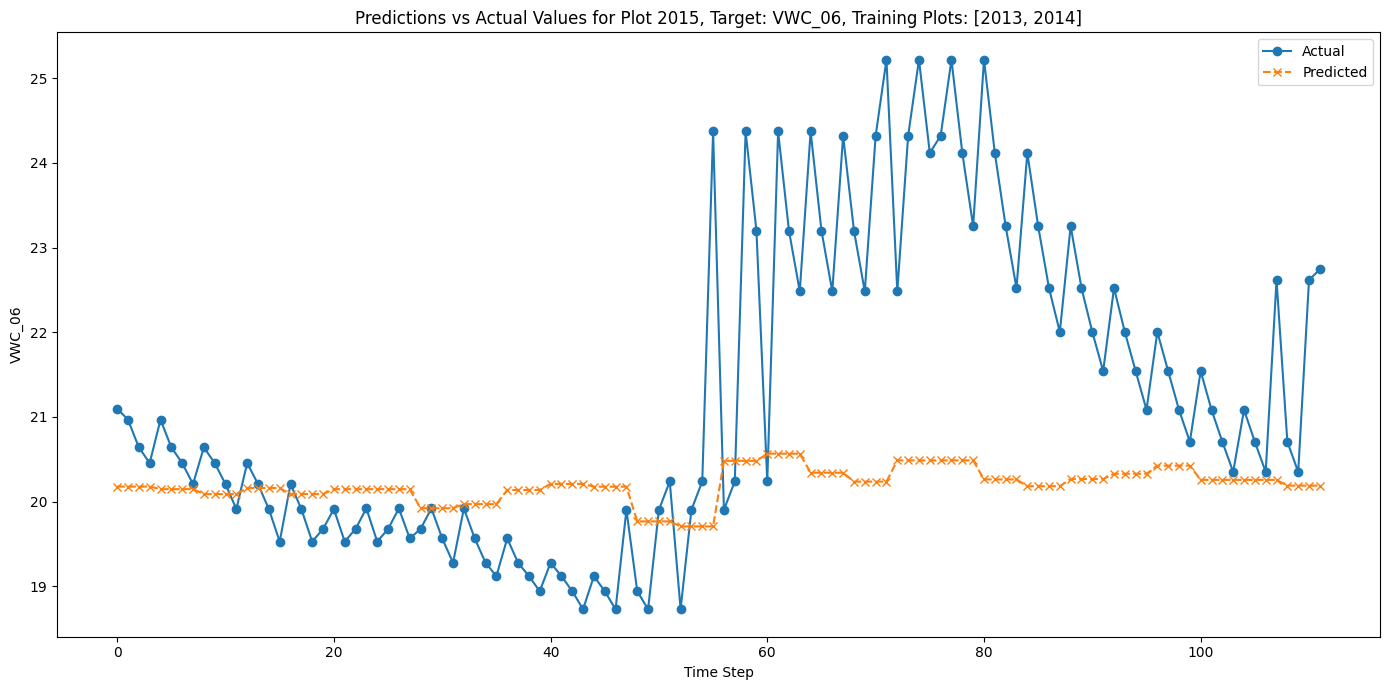

[[20.17885876 20.17885876 20.17885876 20.17885876]
 [20.14808369 20.14808369 20.14808369 20.14808369]
 [20.0898447  20.0898447  20.0898447  20.0898447 ]
 [20.16145611 20.16145611 20.16145611 20.16145611]
 [20.0898447  20.0898447  20.0898447  20.0898447 ]
 [20.14808369 20.14808369 20.14808369 20.14808369]
 [20.14808369 20.14808369 20.14808369 20.14808369]
 [19.92330742 19.92330742 19.92330742 19.92330742]
 [19.97156143 19.97156143 19.97156143 19.97156143]
 [20.13867092 20.13867092 20.13867092 20.13867092]
 [20.21007442 20.21007442 20.21007442 20.21007442]
 [20.17733192 20.17733192 20.17733192 20.17733192]
 [19.76752567 19.76752567 19.76752567 19.76752567]
 [19.70869637 19.70869637 19.70869637 19.70869637]
 [20.48227119 20.48227119 20.48227119 20.48227119]
 [20.56699467 20.56699467 20.56699467 20.56699467]
 [20.3422184  20.3422184  20.3422184  20.3422184 ]
 [20.23702431 20.23702431 20.23702431 20.23702431]
 [20.48770237 20.48770237 20.48770237 20.48770237]
 [20.48770237 20.48770237 20.48

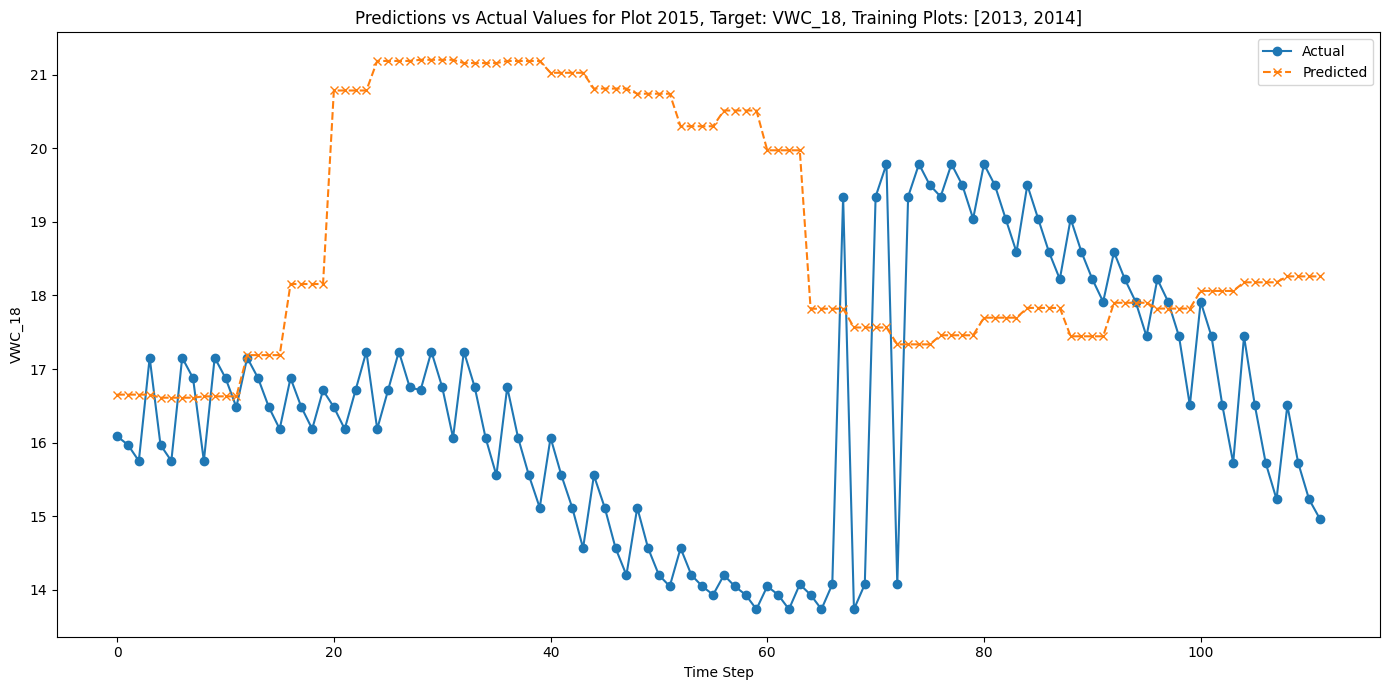

[[16.65298128 16.65298128 16.65298128 16.65298128]
 [16.61107349 16.61107349 16.61107349 16.61107349]
 [16.62936163 16.62936163 16.62936163 16.62936163]
 [17.18940306 17.18940306 17.18940306 17.18940306]
 [18.15545273 18.15545273 18.15545273 18.15545273]
 [20.78338432 20.78338432 20.78338432 20.78338432]
 [21.18483639 21.18483639 21.18483639 21.18483639]
 [21.20023346 21.20023346 21.20023346 21.20023346]
 [21.15569878 21.15569878 21.15569878 21.15569878]
 [21.18434811 21.18434811 21.18434811 21.18434811]
 [21.02423    21.02423    21.02423    21.02423   ]
 [20.80931568 20.80931568 20.80931568 20.80931568]
 [20.73962402 20.73962402 20.73962402 20.73962402]
 [20.29777622 20.29777622 20.29777622 20.29777622]
 [20.51169777 20.51169777 20.51169777 20.51169777]
 [19.97127914 19.97127914 19.97127914 19.97127914]
 [17.81964827 17.81964827 17.81964827 17.81964827]
 [17.56481075 17.56481075 17.56481075 17.56481075]
 [17.33559608 17.33559608 17.33559608 17.33559608]
 [17.45900393 17.45900393 17.45

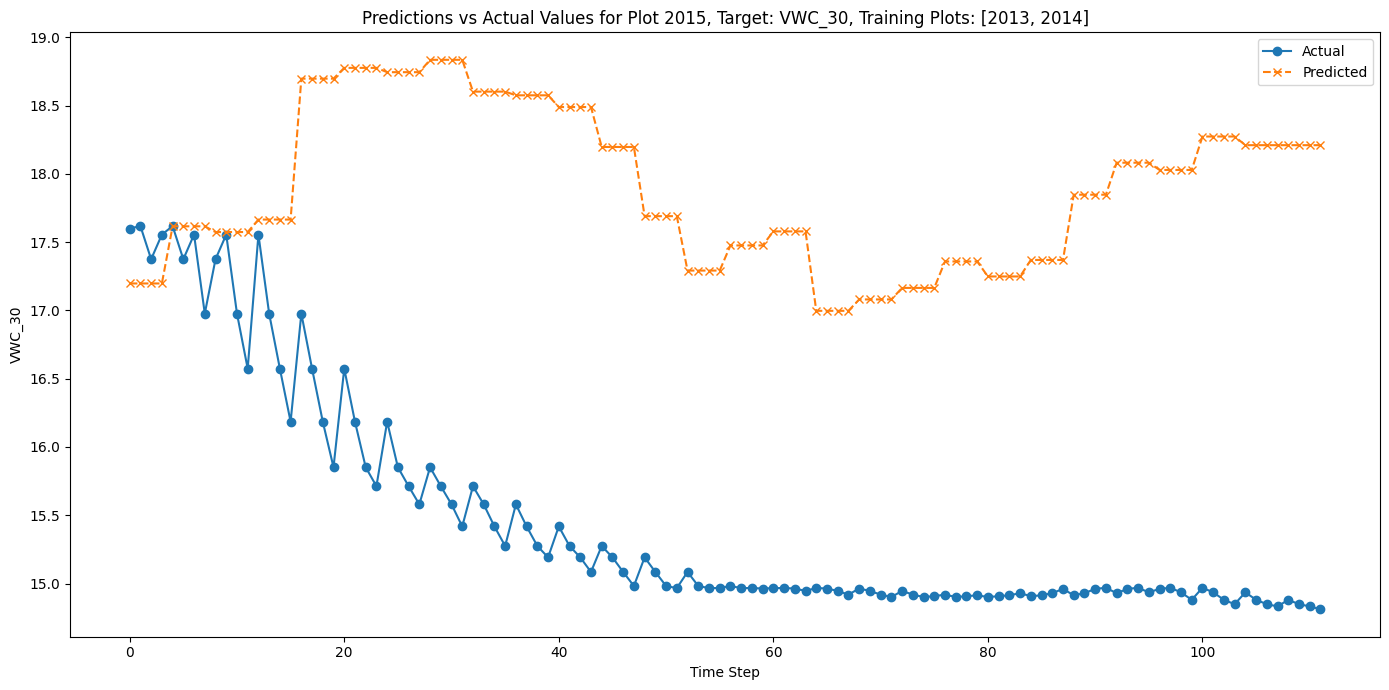

[[17.19747066 17.19747066 17.19747066 17.19747066]
 [17.61612892 17.61612892 17.61612892 17.61612892]
 [17.57404566 17.57404566 17.57404566 17.57404566]
 [17.66557741 17.66557741 17.66557741 17.66557741]
 [18.69751453 18.69751453 18.69751453 18.69751453]
 [18.77641392 18.77641392 18.77641392 18.77641392]
 [18.74488163 18.74488163 18.74488163 18.74488163]
 [18.83551502 18.83551502 18.83551502 18.83551502]
 [18.60254955 18.60254955 18.60254955 18.60254955]
 [18.5754714  18.5754714  18.5754714  18.5754714 ]
 [18.48972464 18.48972464 18.48972464 18.48972464]
 [18.19716597 18.19716597 18.19716597 18.19716597]
 [17.6904664  17.6904664  17.6904664  17.6904664 ]
 [17.29193449 17.29193449 17.29193449 17.29193449]
 [17.47598124 17.47598124 17.47598124 17.47598124]
 [17.5788722  17.5788722  17.5788722  17.5788722 ]
 [16.99712467 16.99712467 16.99712467 16.99712467]
 [17.08046436 17.08046436 17.08046436 17.08046436]
 [17.16495943 17.16495943 17.16495943 17.16495943]
 [17.35861063 17.35861063 17.35

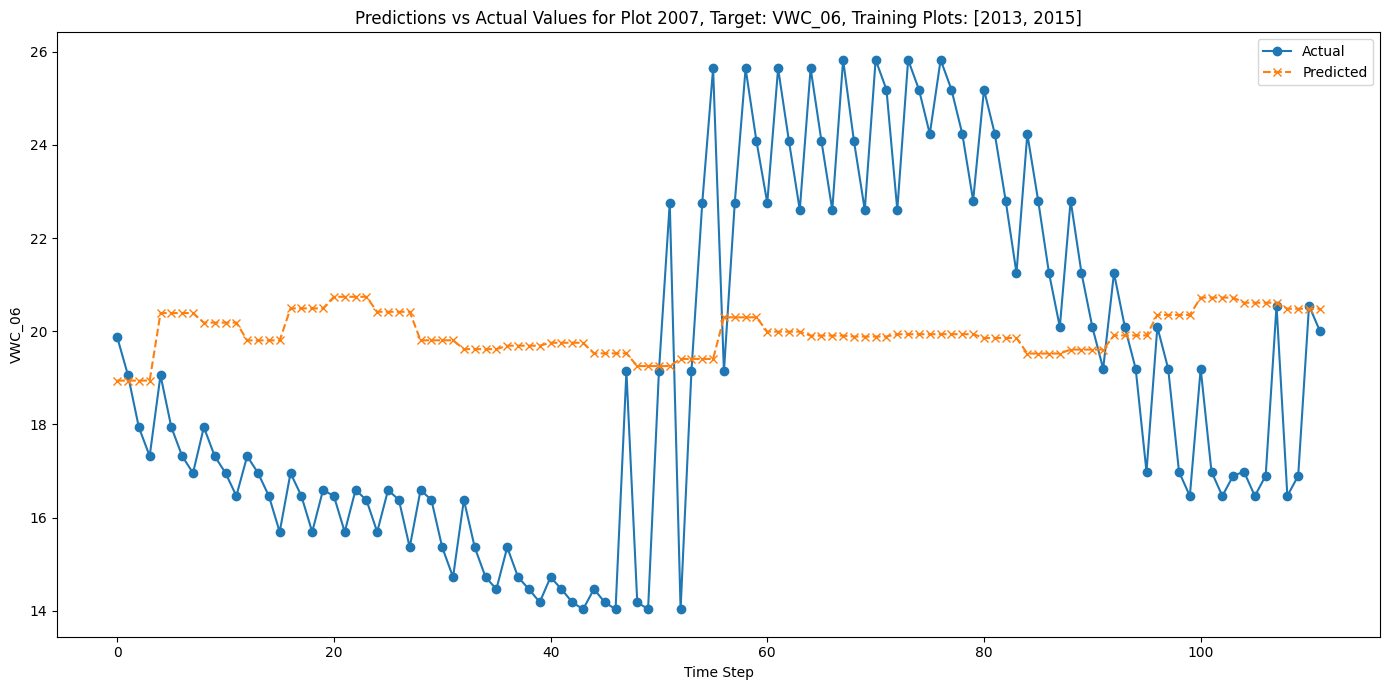

[[18.94148254 18.94148254 18.94148254 18.94148254]
 [20.38991737 20.38991737 20.38991737 20.38991737]
 [20.18553257 20.18553257 20.18553257 20.18553257]
 [19.80399323 19.80399323 19.80399323 19.80399323]
 [20.49072266 20.49072266 20.49072266 20.49072266]
 [20.73948383 20.73948383 20.73948383 20.73948383]
 [20.4173708  20.4173708  20.4173708  20.4173708 ]
 [19.80566406 19.80566406 19.80566406 19.80566406]
 [19.616292   19.616292   19.616292   19.616292  ]
 [19.69009781 19.69009781 19.69009781 19.69009781]
 [19.75298023 19.75298023 19.75298023 19.75298023]
 [19.52591228 19.52591228 19.52591228 19.52591228]
 [19.25288105 19.25288105 19.25288105 19.25288105]
 [19.40629292 19.40629292 19.40629292 19.40629292]
 [20.29887009 20.29887009 20.29887009 20.29887009]
 [19.99156284 19.99156284 19.99156284 19.99156284]
 [19.90620899 19.90620899 19.90620899 19.90620899]
 [19.88691902 19.88691902 19.88691902 19.88691902]
 [19.93627548 19.93627548 19.93627548 19.93627548]
 [19.93732834 19.93732834 19.93

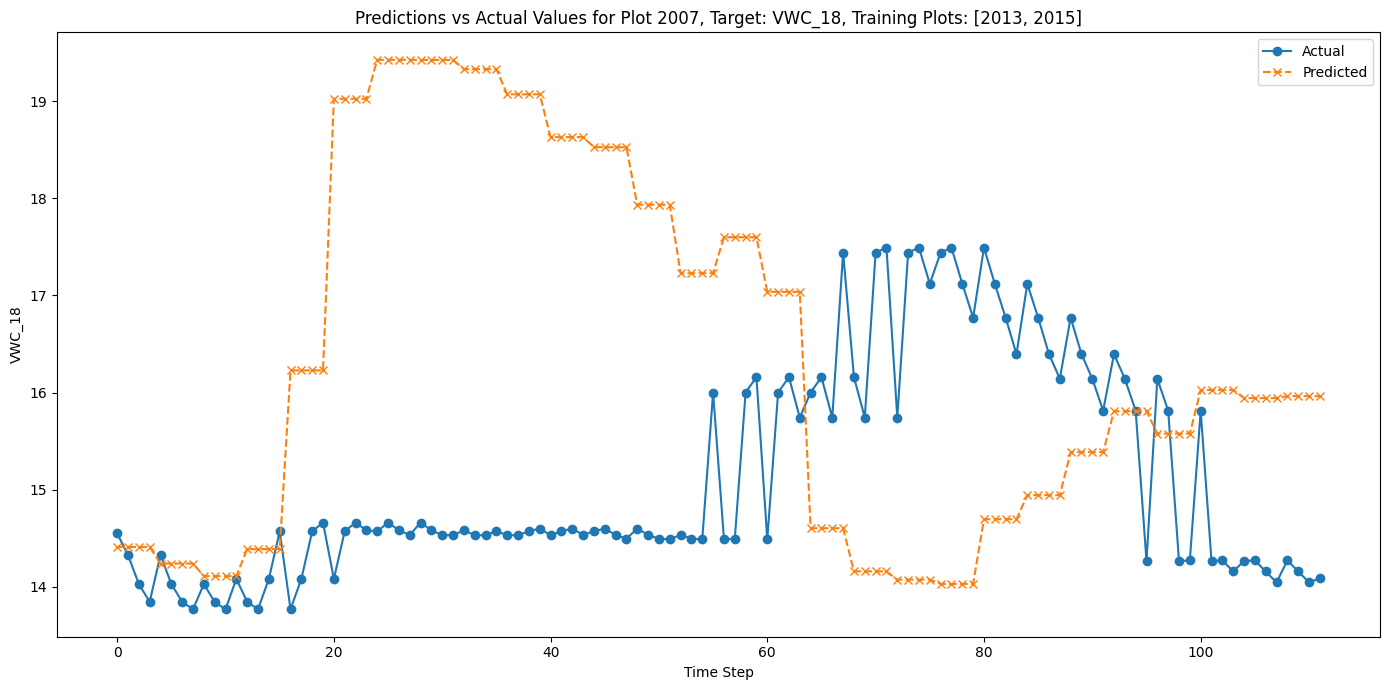

[[14.41179562 14.41179562 14.41179562 14.41179562]
 [14.24110222 14.24110222 14.24110222 14.24110222]
 [14.11145544 14.11145544 14.11145544 14.11145544]
 [14.39008617 14.39008617 14.39008617 14.39008617]
 [16.22813988 16.22813988 16.22813988 16.22813988]
 [19.0237484  19.0237484  19.0237484  19.0237484 ]
 [19.42457104 19.42457104 19.42457104 19.42457104]
 [19.4229517  19.4229517  19.4229517  19.4229517 ]
 [19.32882977 19.32882977 19.32882977 19.32882977]
 [19.06951523 19.06951523 19.06951523 19.06951523]
 [18.62914276 18.62914276 18.62914276 18.62914276]
 [18.5256834  18.5256834  18.5256834  18.5256834 ]
 [17.93355417 17.93355417 17.93355417 17.93355417]
 [17.22864103 17.22864103 17.22864103 17.22864103]
 [17.59938192 17.59938192 17.59938192 17.59938192]
 [17.03699112 17.03699112 17.03699112 17.03699112]
 [14.60477066 14.60477066 14.60477066 14.60477066]
 [14.16043758 14.16043758 14.16043758 14.16043758]
 [14.07556868 14.07556868 14.07556868 14.07556868]
 [14.03142071 14.03142071 14.03

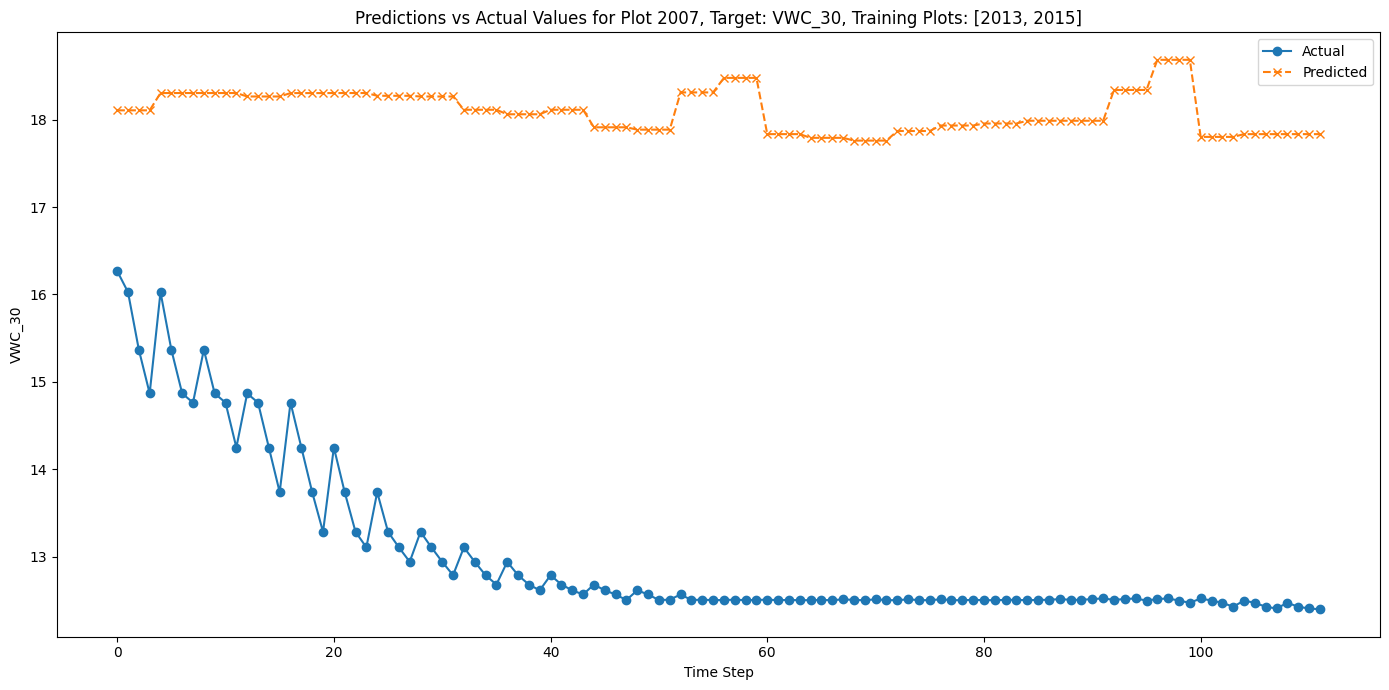

[[18.10686255 18.10686255 18.10686255 18.10686255]
 [18.304811   18.304811   18.304811   18.304811  ]
 [18.304811   18.304811   18.304811   18.304811  ]
 [18.26534319 18.26534319 18.26534319 18.26534319]
 [18.30422735 18.30422735 18.30422735 18.30422735]
 [18.304811   18.304811   18.304811   18.304811  ]
 [18.27327871 18.27327871 18.27327871 18.27327871]
 [18.26534319 18.26534319 18.26534319 18.26534319]
 [18.11346197 18.11346197 18.11346197 18.11346197]
 [18.06176996 18.06176996 18.06176996 18.06176996]
 [18.11346197 18.11346197 18.11346197 18.11346197]
 [17.91277647 17.91277647 17.91277647 17.91277647]
 [17.88585234 17.88585234 17.88585234 17.88585234]
 [18.31193018 18.31193018 18.31193018 18.31193018]
 [18.47827005 18.47827005 18.47827005 18.47827005]
 [17.83446074 17.83446074 17.83446074 17.83446074]
 [17.79204798 17.79204798 17.79204798 17.79204798]
 [17.76051569 17.76051569 17.76051569 17.76051569]
 [17.87036371 17.87036371 17.87036371 17.87036371]
 [17.93301535 17.93301535 17.93

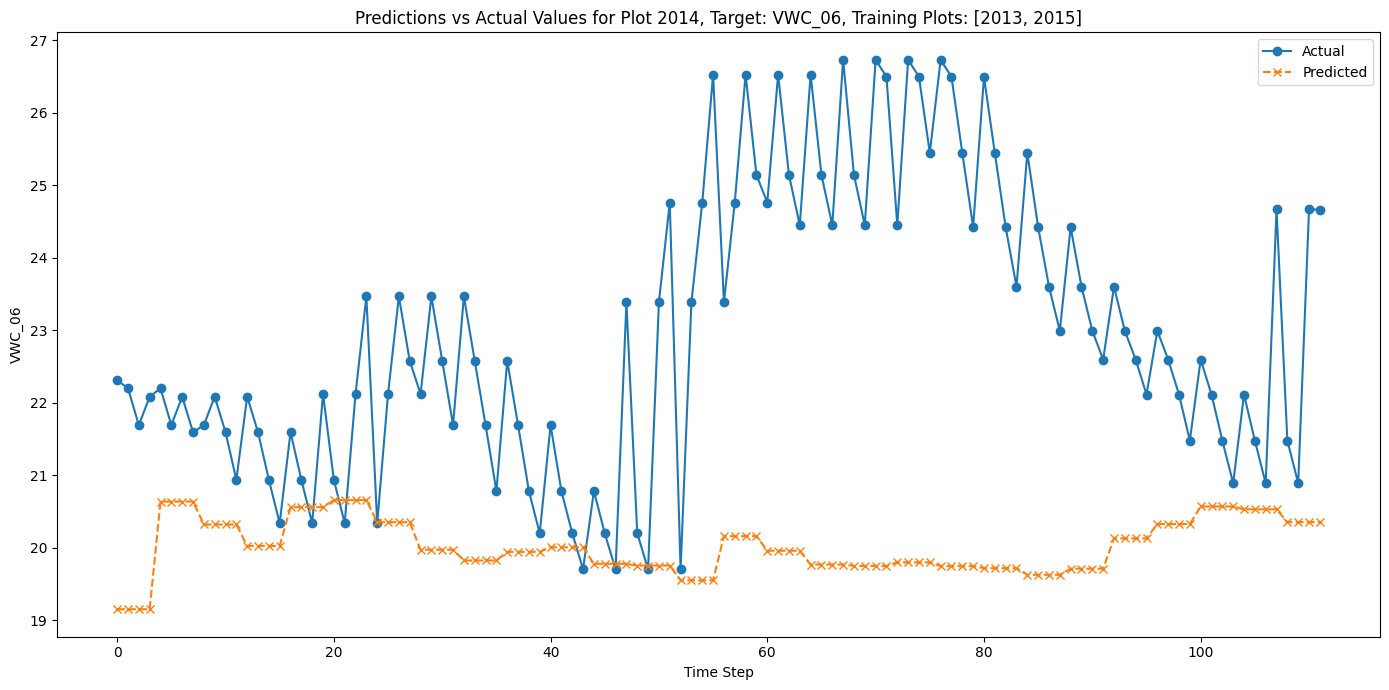

[[19.15108109 19.15108109 19.15108109 19.15108109]
 [20.63707161 20.63707161 20.63707161 20.63707161]
 [20.32099628 20.32099628 20.32099628 20.32099628]
 [20.02519608 20.02519608 20.02519608 20.02519608]
 [20.55916786 20.55916786 20.55916786 20.55916786]
 [20.65702343 20.65702343 20.65702343 20.65702343]
 [20.3523016  20.3523016  20.3523016  20.3523016 ]
 [19.97261047 19.97261047 19.97261047 19.97261047]
 [19.8240366  19.8240366  19.8240366  19.8240366 ]
 [19.94278336 19.94278336 19.94278336 19.94278336]
 [20.00566578 20.00566578 20.00566578 20.00566578]
 [19.77859783 19.77859783 19.77859783 19.77859783]
 [19.75385189 19.75385189 19.75385189 19.75385189]
 [19.55116177 19.55116177 19.55116177 19.55116177]
 [20.15991211 20.15991211 20.15991211 20.15991211]
 [19.958951   19.958951   19.958951   19.958951  ]
 [19.76823139 19.76823139 19.76823139 19.76823139]
 [19.74894142 19.74894142 19.74894142 19.74894142]
 [19.79829788 19.79829788 19.79829788 19.79829788]
 [19.74522209 19.74522209 19.74

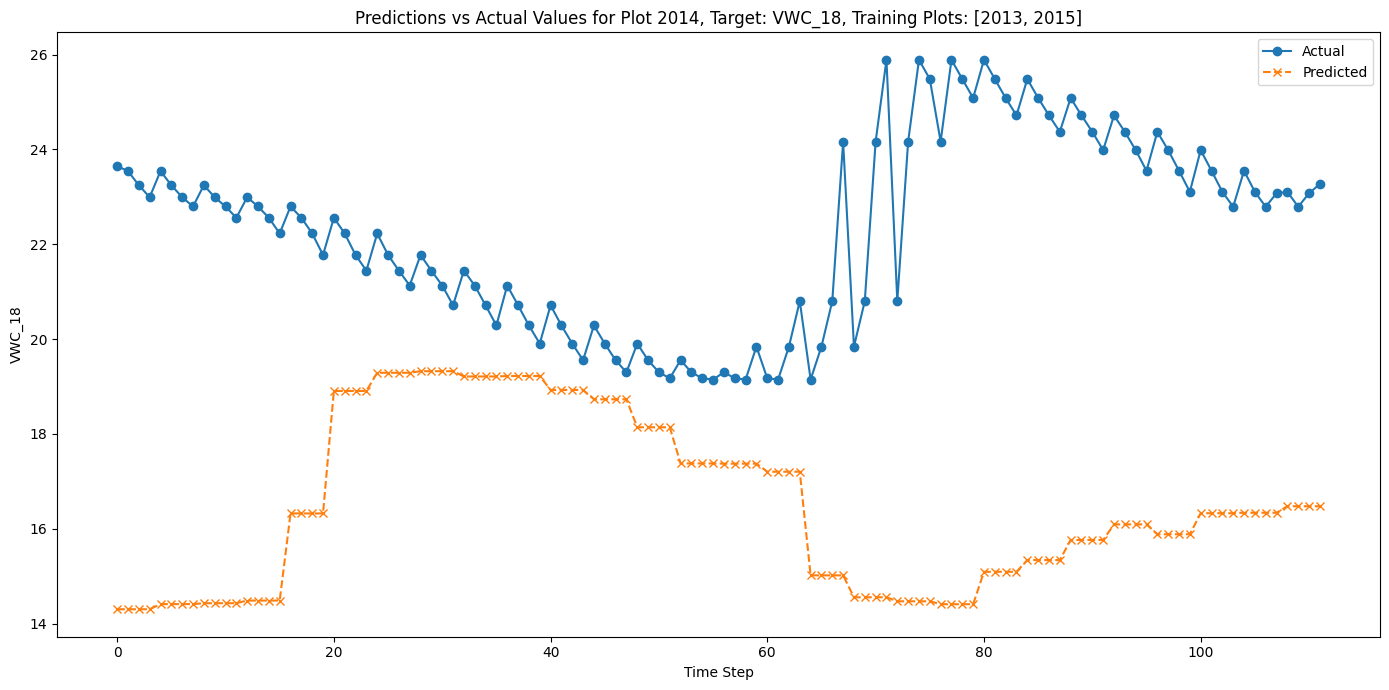

[[14.30244637 14.30244637 14.30244637 14.30244637]
 [14.41105127 14.41105127 14.41105127 14.41105127]
 [14.42973995 14.42973995 14.42973995 14.42973995]
 [14.48551369 14.48551369 14.48551369 14.48551369]
 [16.32356739 16.32356739 16.32356739 16.32356739]
 [18.90709496 18.90709496 18.90709496 18.90709496]
 [19.29027176 19.29027176 19.29027176 19.29027176]
 [19.32394409 19.32394409 19.32394409 19.32394409]
 [19.21217632 19.21217632 19.21217632 19.21217632]
 [19.2220192  19.2220192  19.2220192  19.2220192 ]
 [18.92849827 18.92849827 18.92849827 18.92849827]
 [18.73138142 18.73138142 18.73138142 18.73138142]
 [18.14076996 18.14076996 18.14076996 18.14076996]
 [17.37781048 17.37781048 17.37781048 17.37781048]
 [17.37351322 17.37351322 17.37351322 17.37351322]
 [17.20322418 17.20322418 17.20322418 17.20322418]
 [15.01719761 15.01719761 15.01719761 15.01719761]
 [14.55521917 14.55521917 14.55521917 14.55521917]
 [14.47035027 14.47035027 14.47035027 14.47035027]
 [14.40855598 14.40855598 14.40

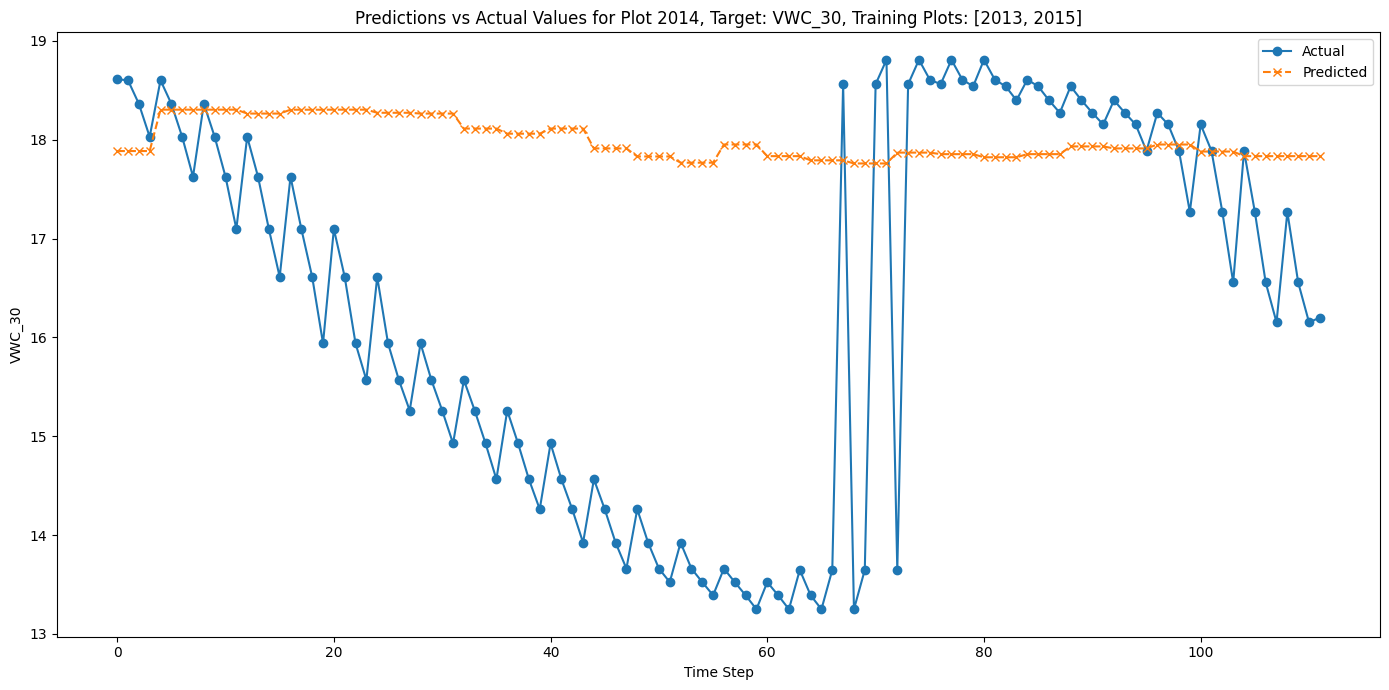

[[17.88615274 17.88615274 17.88615274 17.88615274]
 [18.304811   18.304811   18.304811   18.304811  ]
 [18.304811   18.304811   18.304811   18.304811  ]
 [18.26534319 18.26534319 18.26534319 18.26534319]
 [18.30422735 18.30422735 18.30422735 18.30422735]
 [18.304811   18.304811   18.304811   18.304811  ]
 [18.27327871 18.27327871 18.27327871 18.27327871]
 [18.26534319 18.26534319 18.26534319 18.26534319]
 [18.11346197 18.11346197 18.11346197 18.11346197]
 [18.06176996 18.06176996 18.06176996 18.06176996]
 [18.11346197 18.11346197 18.11346197 18.11346197]
 [17.91277647 17.91277647 17.91277647 17.91277647]
 [17.83118296 17.83118296 17.83118296 17.83118296]
 [17.76819754 17.76819754 17.76819754 17.76819754]
 [17.95224428 17.95224428 17.95224428 17.95224428]
 [17.83446074 17.83446074 17.83446074 17.83446074]
 [17.79204798 17.79204798 17.79204798 17.79204798]
 [17.76051569 17.76051569 17.76051569 17.76051569]
 [17.87036371 17.87036371 17.87036371 17.87036371]
 [17.85469961 17.85469961 17.85

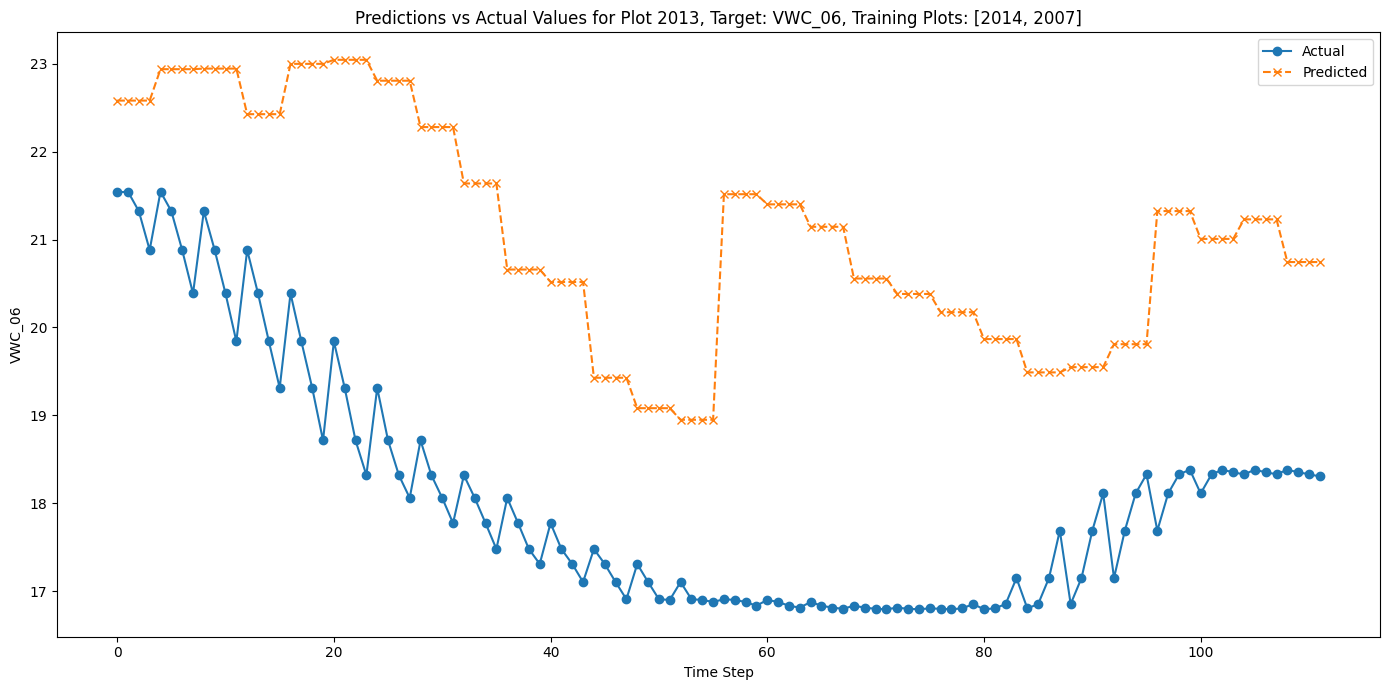

[[22.58096504 22.58096504 22.58096504 22.58096504]
 [22.93812466 22.93812466 22.93812466 22.93812466]
 [22.94487    22.94487    22.94487    22.94487   ]
 [22.42632294 22.42632294 22.42632294 22.42632294]
 [22.99889088 22.99889088 22.99889088 22.99889088]
 [23.04479122 23.04479122 23.04479122 23.04479122]
 [22.80706882 22.80706882 22.80706882 22.80706882]
 [22.27969742 22.27969742 22.27969742 22.27969742]
 [21.63834858 21.63834858 21.63834858 21.63834858]
 [20.6594162  20.6594162  20.6594162  20.6594162 ]
 [20.51770687 20.51770687 20.51770687 20.51770687]
 [19.42844582 19.42844582 19.42844582 19.42844582]
 [19.08225822 19.08225822 19.08225822 19.08225822]
 [18.95027828 18.95027828 18.95027828 18.95027828]
 [21.51609612 21.51609612 21.51609612 21.51609612]
 [21.40074158 21.40074158 21.40074158 21.40074158]
 [21.14543343 21.14543343 21.14543343 21.14543343]
 [20.55702877 20.55702877 20.55702877 20.55702877]
 [20.38155174 20.38155174 20.38155174 20.38155174]
 [20.17398262 20.17398262 20.17

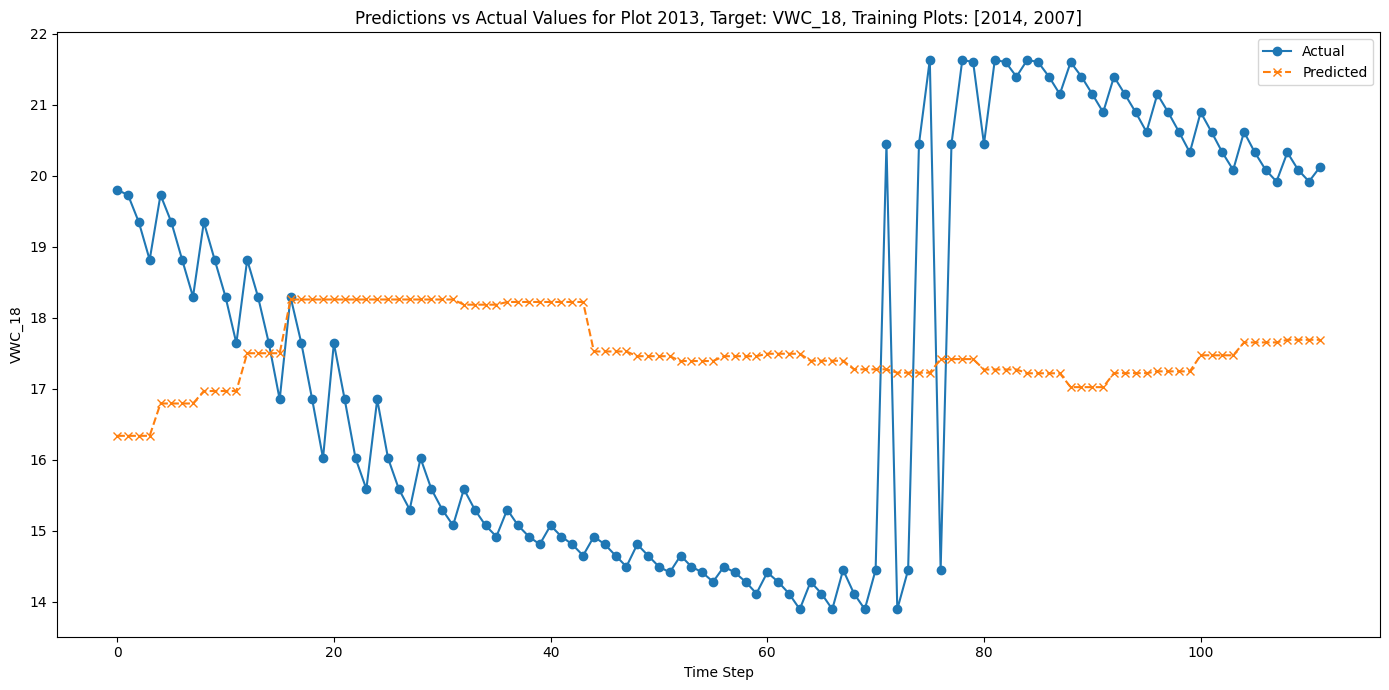

[[16.3351841  16.3351841  16.3351841  16.3351841 ]
 [16.79081535 16.79081535 16.79081535 16.79081535]
 [16.96648073 16.96648073 16.96648073 16.96648073]
 [17.49866819 17.49866819 17.49866819 17.49866819]
 [18.25564766 18.25564766 18.25564766 18.25564766]
 [18.25564766 18.25564766 18.25564766 18.25564766]
 [18.25564766 18.25564766 18.25564766 18.25564766]
 [18.25564766 18.25564766 18.25564766 18.25564766]
 [18.18277311 18.18277311 18.18277311 18.18277311]
 [18.22106743 18.22106743 18.22106743 18.22106743]
 [18.22106743 18.22106743 18.22106743 18.22106743]
 [17.52358389 17.52358389 17.52358389 17.52358389]
 [17.45695066 17.45695066 17.45695066 17.45695066]
 [17.3889513  17.3889513  17.3889513  17.3889513 ]
 [17.45695066 17.45695066 17.45695066 17.45695066]
 [17.4915309  17.4915309  17.4915309  17.4915309 ]
 [17.39292097 17.39292097 17.39292097 17.39292097]
 [17.27204561 17.27204561 17.27204561 17.27204561]
 [17.22425222 17.22425222 17.22425222 17.22425222]
 [17.41601467 17.41601467 17.41

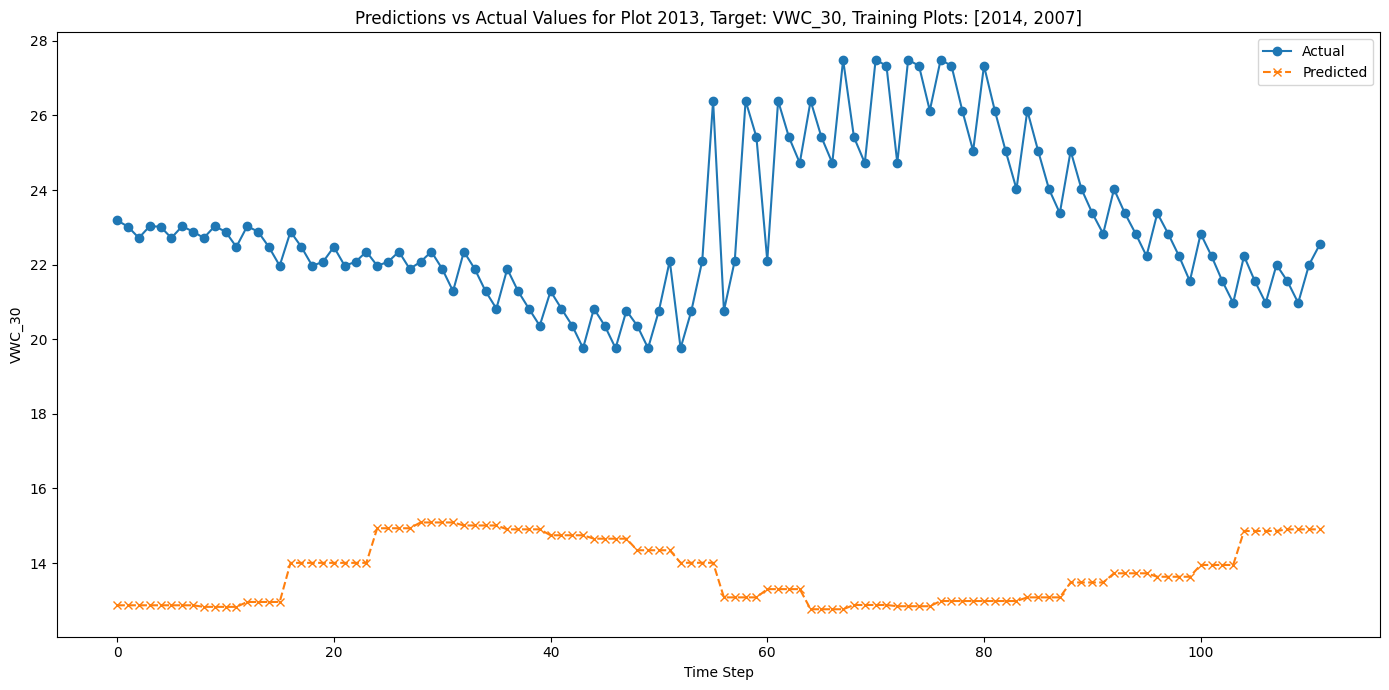

[[12.86712599 12.86712599 12.86712599 12.86712599]
 [12.86712599 12.86712599 12.86712599 12.86712599]
 [12.82504272 12.82504272 12.82504272 12.82504272]
 [12.95604229 12.95604229 12.95604229 12.95604229]
 [14.00484419 14.00484419 14.00484419 14.00484419]
 [14.00484419 14.00484419 14.00484419 14.00484419]
 [14.93257856 14.93257856 14.93257856 14.93257856]
 [15.08837652 15.08837652 15.08837652 15.08837652]
 [15.00729322 15.00729322 15.00729322 15.00729322]
 [14.90323305 14.90323305 14.90323305 14.90323305]
 [14.74450541 14.74450541 14.74450541 14.74450541]
 [14.65263033 14.65263033 14.65263033 14.65263033]
 [14.34282541 14.34282541 14.34282541 14.34282541]
 [14.0072813  14.0072813  14.0072813  14.0072813 ]
 [13.07954502 13.07954502 13.07954502 13.07954502]
 [13.30021954 13.30021954 13.30021954 13.30021954]
 [12.76088476 12.76088476 12.76088476 12.76088476]
 [12.87575674 12.87575674 12.87575674 12.87575674]
 [12.84177303 12.84177303 12.84177303 12.84177303]
 [12.98140335 12.98140335 12.98

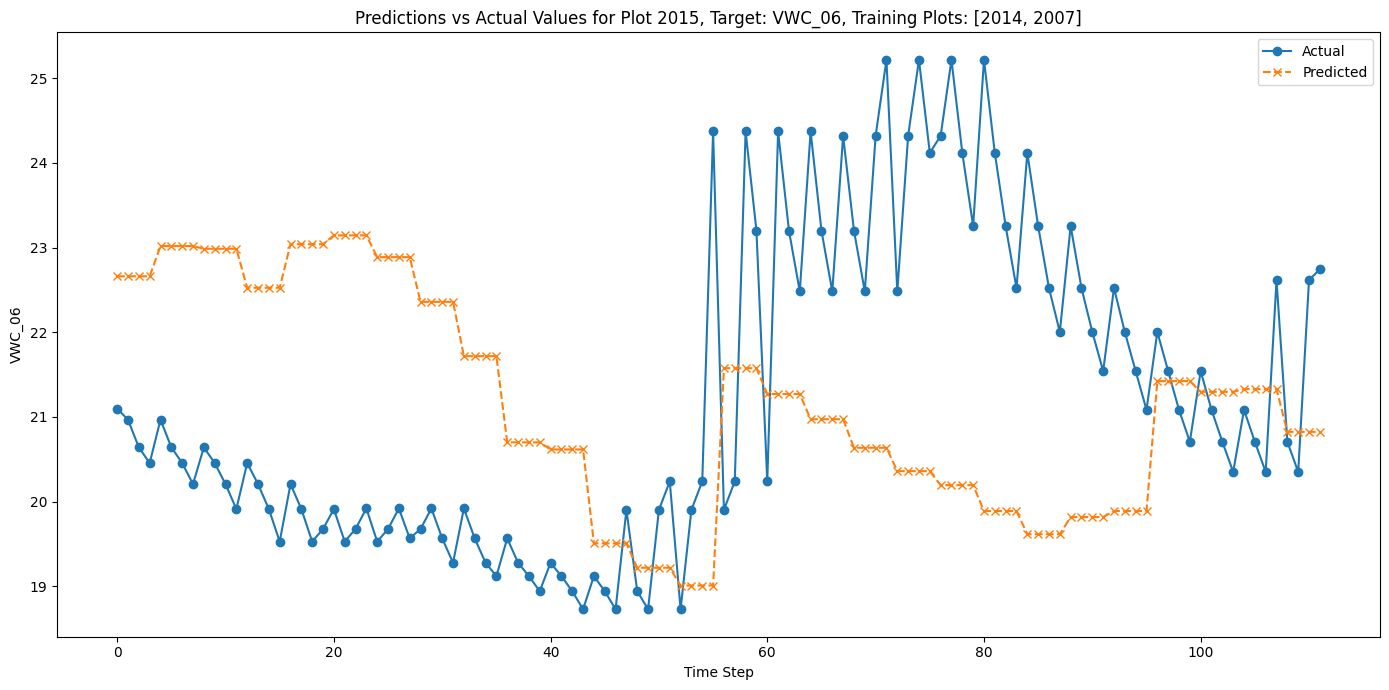

[[22.66087627 22.66087627 22.66087627 22.66087627]
 [23.01803589 23.01803589 23.01803589 23.01803589]
 [22.98596191 22.98596191 22.98596191 22.98596191]
 [22.52565384 22.52565384 22.52565384 22.52565384]
 [23.0399828  23.0399828  23.0399828  23.0399828 ]
 [23.14412212 23.14412212 23.14412212 23.14412212]
 [22.88698006 22.88698006 22.88698006 22.88698006]
 [22.35960865 22.35960865 22.35960865 22.35960865]
 [21.71825981 21.71825981 21.71825981 21.71825981]
 [20.70050812 20.70050812 20.70050812 20.70050812]
 [20.61703777 20.61703777 20.61703777 20.61703777]
 [19.50835705 19.50835705 19.50835705 19.50835705]
 [19.22040844 19.22040844 19.22040844 19.22040844]
 [19.01076984 19.01076984 19.01076984 19.01076984]
 [21.57658768 21.57658768 21.57658768 21.57658768]
 [21.27126789 21.27126789 21.27126789 21.27126789]
 [20.97371578 20.97371578 20.97371578 20.97371578]
 [20.63694    20.63694    20.63694    20.63694   ]
 [20.36098099 20.36098099 20.36098099 20.36098099]
 [20.19565487 20.19565487 20.19

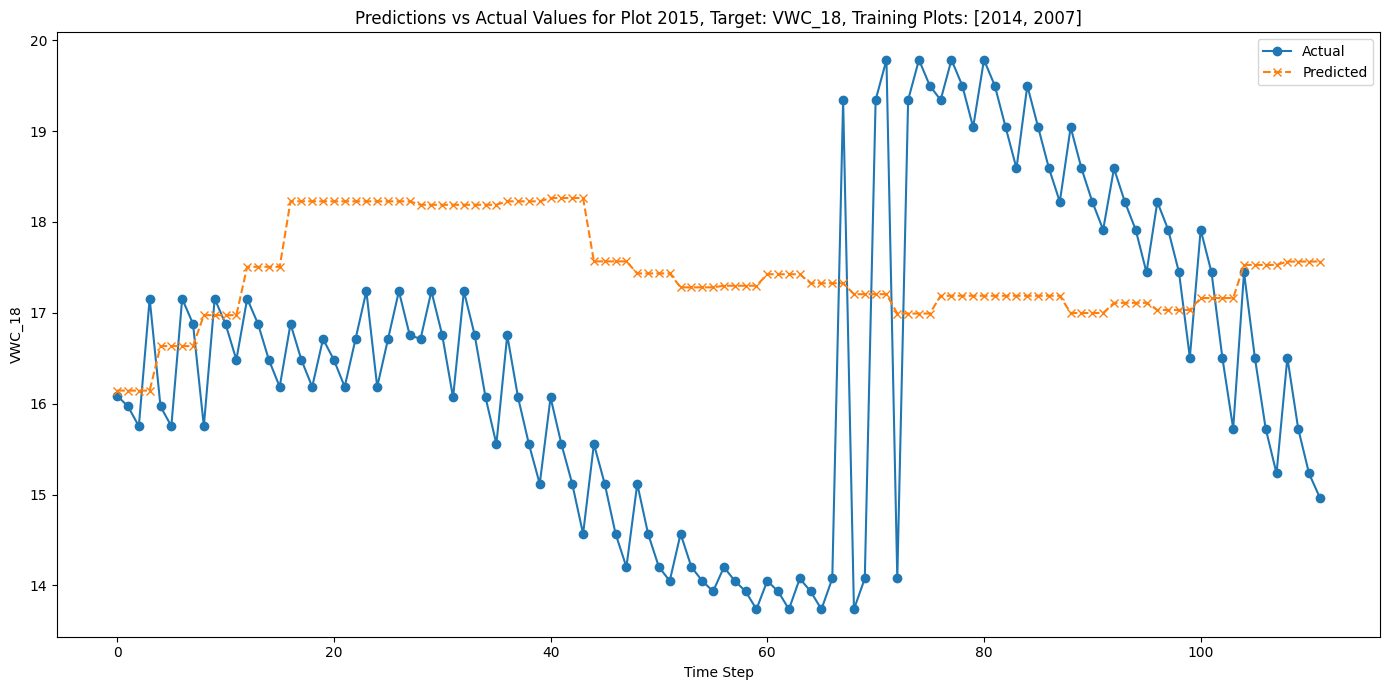

[[16.14404774 16.14404774 16.14404774 16.14404774]
 [16.63357782 16.63357782 16.63357782 16.63357782]
 [16.97408009 16.97408009 16.97408009 16.97408009]
 [17.50626755 17.50626755 17.50626755 17.50626755]
 [18.22679663 18.22679663 18.22679663 18.22679663]
 [18.22679663 18.22679663 18.22679663 18.22679663]
 [18.22679663 18.22679663 18.22679663 18.22679663]
 [18.18850231 18.18850231 18.18850231 18.18850231]
 [18.18850231 18.18850231 18.18850231 18.18850231]
 [18.22679663 18.22679663 18.22679663 18.22679663]
 [18.26324701 18.26324701 18.26324701 18.26324701]
 [17.56576347 17.56576347 17.56576347 17.56576347]
 [17.43370438 17.43370438 17.43370438 17.43370438]
 [17.28022194 17.28022194 17.28022194 17.28022194]
 [17.29784298 17.29784298 17.29784298 17.29784298]
 [17.42438555 17.42438555 17.42438555 17.42438555]
 [17.32577562 17.32577562 17.32577562 17.32577562]
 [17.20490026 17.20490026 17.20490026 17.20490026]
 [16.99195433 16.99195433 16.99195433 16.99195433]
 [17.18743086 17.18743086 17.18

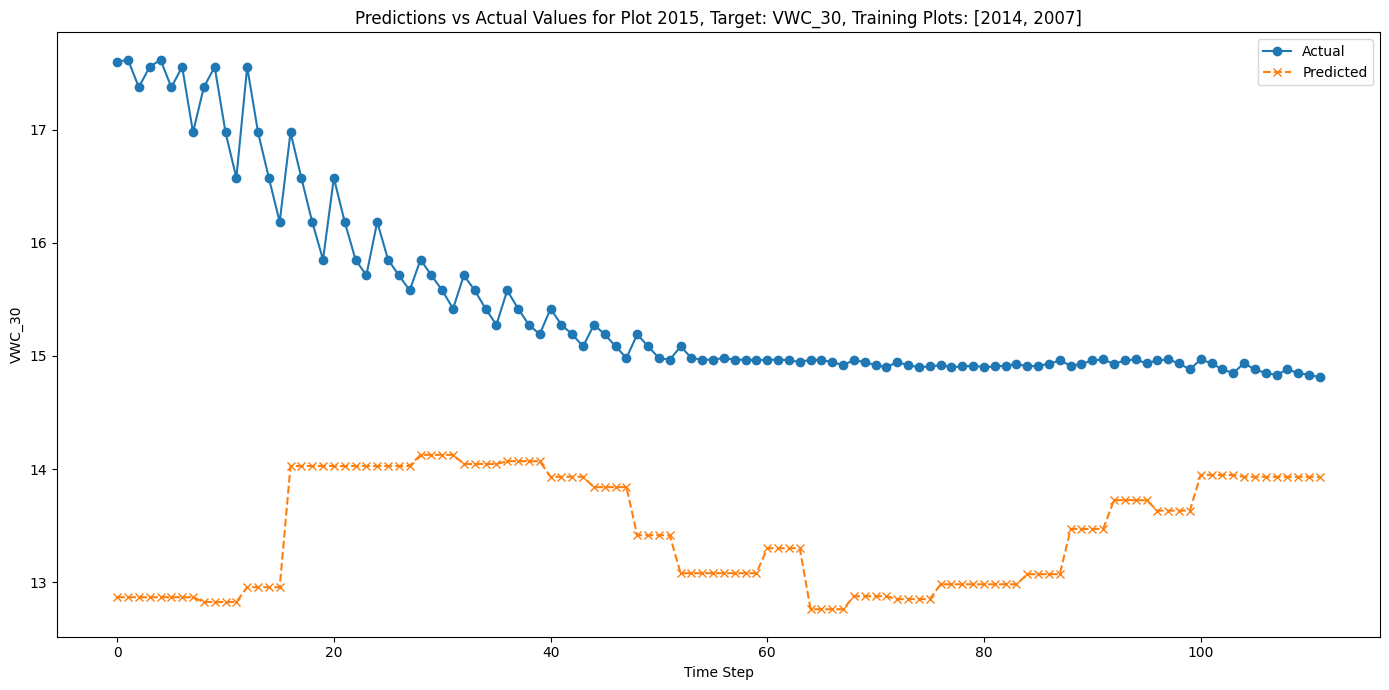

[[12.86712599 12.86712599 12.86712599 12.86712599]
 [12.86712599 12.86712599 12.86712599 12.86712599]
 [12.82504272 12.82504272 12.82504272 12.82504272]
 [12.95604229 12.95604229 12.95604229 12.95604229]
 [14.02741098 14.02741098 14.02741098 14.02741098]
 [14.02741098 14.02741098 14.02741098 14.02741098]
 [14.02741098 14.02741098 14.02741098 14.02741098]
 [14.1259799  14.1259799  14.1259799  14.1259799 ]
 [14.04489565 14.04489565 14.04489565 14.04489565]
 [14.06950951 14.06950951 14.06950951 14.06950951]
 [13.93207073 13.93207073 13.93207073 13.93207073]
 [13.84019756 13.84019756 13.84019756 13.84019756]
 [13.41509151 13.41509151 13.41509151 13.41509151]
 [13.07954502 13.07954502 13.07954502 13.07954502]
 [13.07954502 13.07954502 13.07954502 13.07954502]
 [13.30021954 13.30021954 13.30021954 13.30021954]
 [12.76088476 12.76088476 12.76088476 12.76088476]
 [12.87575674 12.87575674 12.87575674 12.87575674]
 [12.85040379 12.85040379 12.85040379 12.85040379]
 [12.98140335 12.98140335 12.98

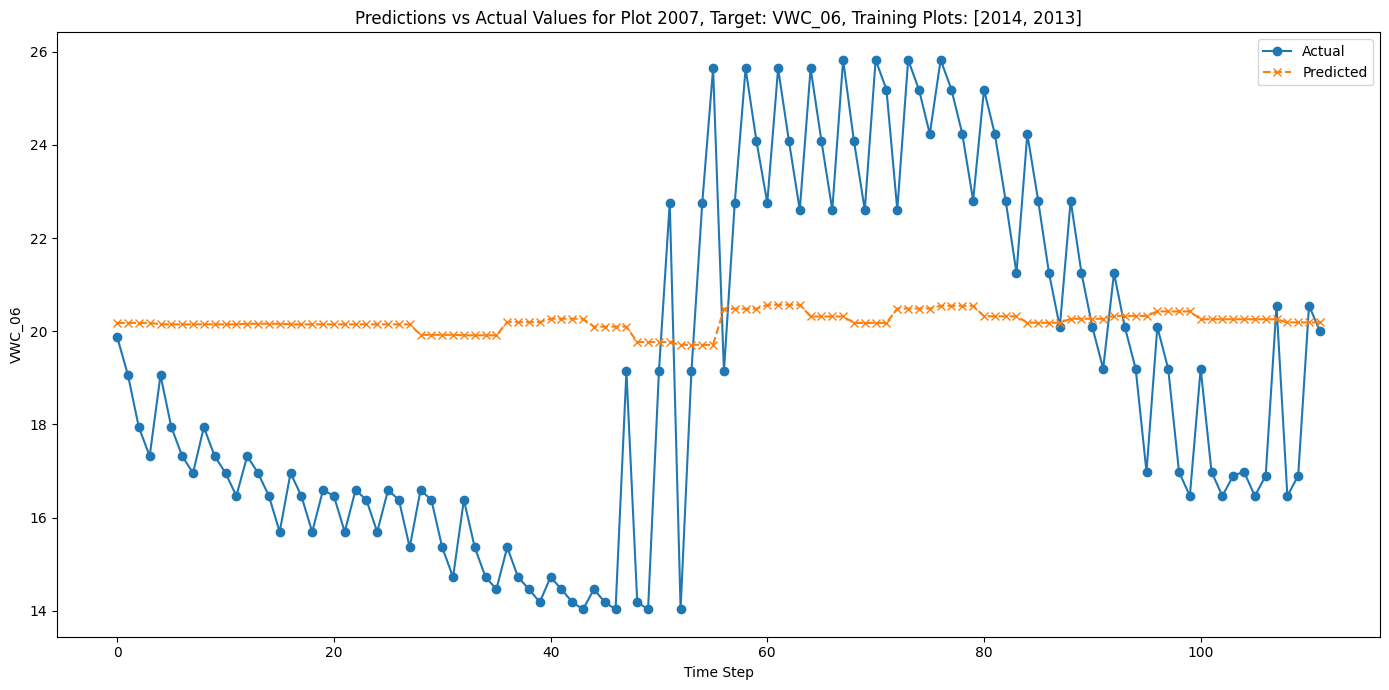

[[20.17885876 20.17885876 20.17885876 20.17885876]
 [20.14808369 20.14808369 20.14808369 20.14808369]
 [20.14808369 20.14808369 20.14808369 20.14808369]
 [20.16145611 20.16145611 20.16145611 20.16145611]
 [20.14808369 20.14808369 20.14808369 20.14808369]
 [20.14808369 20.14808369 20.14808369 20.14808369]
 [20.14808369 20.14808369 20.14808369 20.14808369]
 [19.92330742 19.92330742 19.92330742 19.92330742]
 [19.91332245 19.91332245 19.91332245 19.91332245]
 [20.1969099  20.1969099  20.1969099  20.1969099 ]
 [20.26831341 20.26831341 20.26831341 20.26831341]
 [20.09861851 20.09861851 20.09861851 20.09861851]
 [19.76752567 19.76752567 19.76752567 19.76752567]
 [19.70869637 19.70869637 19.70869637 19.70869637]
 [20.48227119 20.48227119 20.48227119 20.48227119]
 [20.56699467 20.56699467 20.56699467 20.56699467]
 [20.31678963 20.31678963 20.31678963 20.31678963]
 [20.17878532 20.17878532 20.17878532 20.17878532]
 [20.48770237 20.48770237 20.48770237 20.48770237]
 [20.54594135 20.54594135 20.54

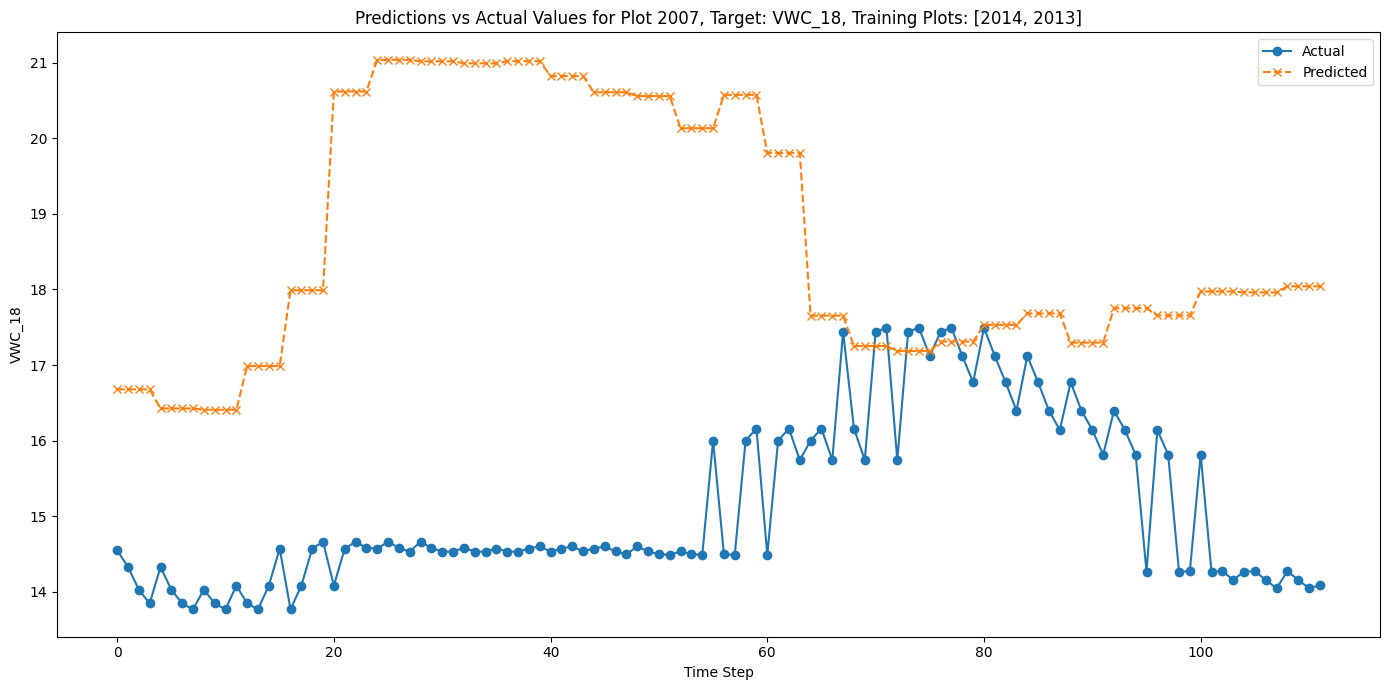

[[16.67810154 16.67810154 16.67810154 16.67810154]
 [16.42585897 16.42585897 16.42585897 16.42585897]
 [16.40885639 16.40885639 16.40885639 16.40885639]
 [16.98654222 16.98654222 16.98654222 16.98654222]
 [17.98904228 17.98904228 17.98904228 17.98904228]
 [20.61697388 20.61697388 20.61697388 20.61697388]
 [21.03607178 21.03607178 21.03607178 21.03607178]
 [21.01617718 21.01617718 21.01617718 21.01617718]
 [20.98928833 20.98928833 20.98928833 20.98928833]
 [21.01793766 21.01793766 21.01793766 21.01793766]
 [20.82136917 20.82136917 20.82136917 20.82136917]
 [20.60645485 20.60645485 20.60645485 20.60645485]
 [20.55556774 20.55556774 20.55556774 20.55556774]
 [20.13136578 20.13136578 20.13136578 20.13136578]
 [20.57326698 20.57326698 20.57326698 20.57326698]
 [19.8048687  19.8048687  19.8048687  19.8048687 ]
 [17.65323782 17.65323782 17.65323782 17.65323782]
 [17.25169468 17.25169468 17.25169468 17.25169468]
 [17.186831   17.186831   17.186831   17.186831  ]
 [17.31023884 17.31023884 17.31

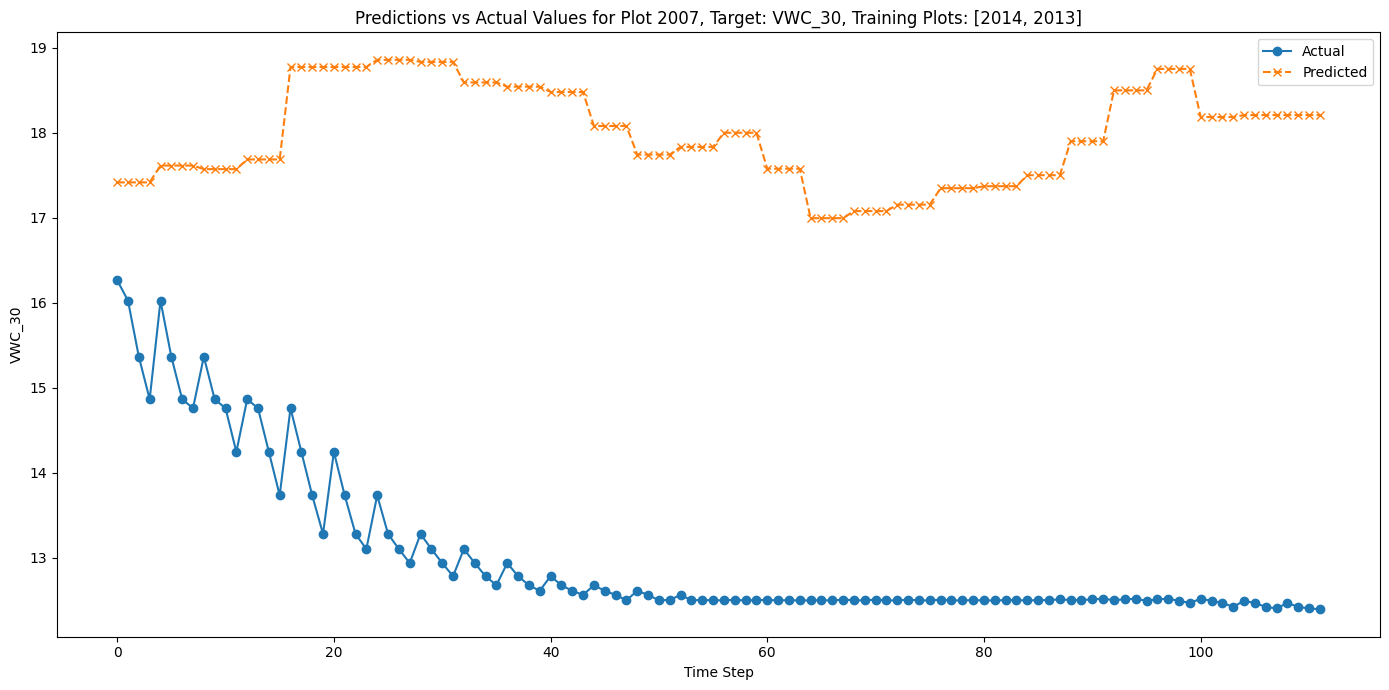

[[17.41818047 17.41818047 17.41818047 17.41818047]
 [17.61612892 17.61612892 17.61612892 17.61612892]
 [17.57404566 17.57404566 17.57404566 17.57404566]
 [17.68814421 17.68814421 17.68814421 17.68814421]
 [18.77583027 18.77583027 18.77583027 18.77583027]
 [18.77641392 18.77641392 18.77641392 18.77641392]
 [18.86018181 18.86018181 18.86018181 18.86018181]
 [18.83551502 18.83551502 18.83551502 18.83551502]
 [18.5939188  18.5939188  18.5939188  18.5939188 ]
 [18.54427385 18.54427385 18.54427385 18.54427385]
 [18.48109388 18.48109388 18.48109388 18.48109388]
 [18.08186626 18.08186626 18.08186626 18.08186626]
 [17.74513578 17.74513578 17.74513578 17.74513578]
 [17.83566713 17.83566713 17.83566713 17.83566713]
 [18.00200701 18.00200701 18.00200701 18.00200701]
 [17.5788722  17.5788722  17.5788722  17.5788722 ]
 [16.99712467 16.99712467 16.99712467 16.99712467]
 [17.08046436 17.08046436 17.08046436 17.08046436]
 [17.15632868 17.15632868 17.15632868 17.15632868]
 [17.34997988 17.34997988 17.34

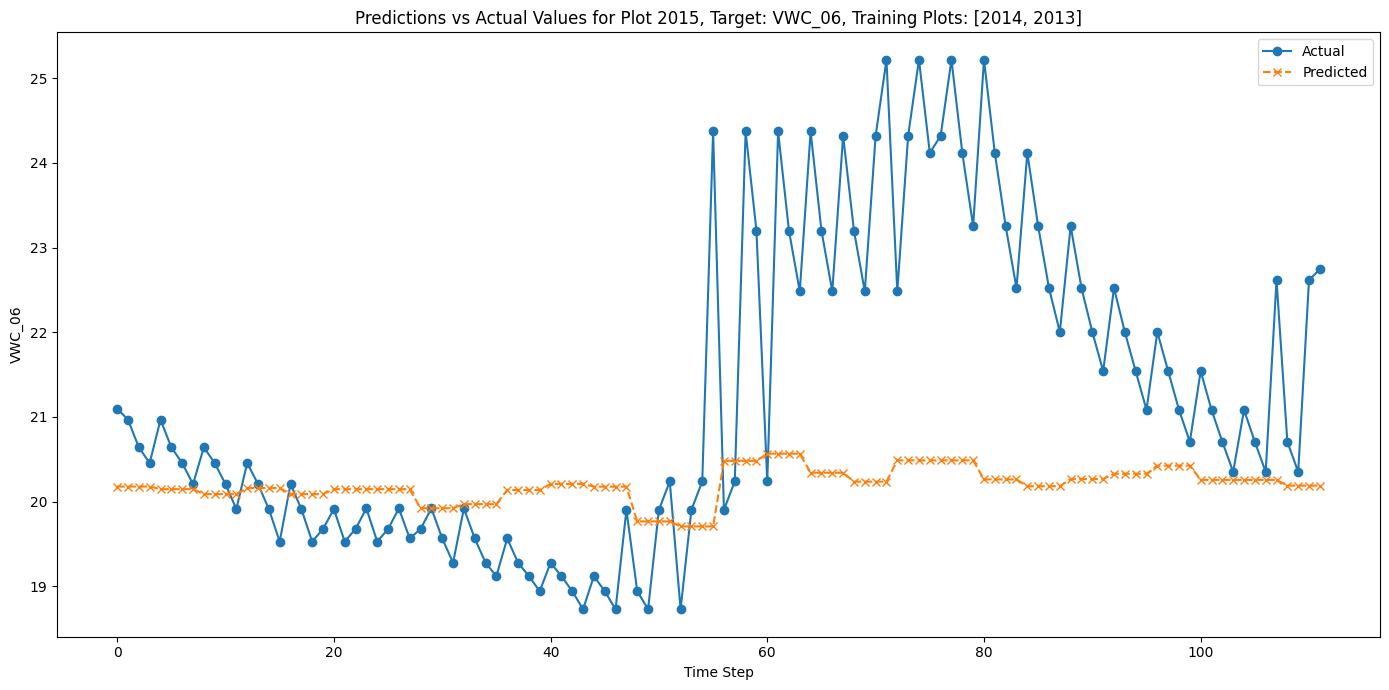

[[20.17885876 20.17885876 20.17885876 20.17885876]
 [20.14808369 20.14808369 20.14808369 20.14808369]
 [20.0898447  20.0898447  20.0898447  20.0898447 ]
 [20.16145611 20.16145611 20.16145611 20.16145611]
 [20.0898447  20.0898447  20.0898447  20.0898447 ]
 [20.14808369 20.14808369 20.14808369 20.14808369]
 [20.14808369 20.14808369 20.14808369 20.14808369]
 [19.92330742 19.92330742 19.92330742 19.92330742]
 [19.97156143 19.97156143 19.97156143 19.97156143]
 [20.13867092 20.13867092 20.13867092 20.13867092]
 [20.21007442 20.21007442 20.21007442 20.21007442]
 [20.17733192 20.17733192 20.17733192 20.17733192]
 [19.76752567 19.76752567 19.76752567 19.76752567]
 [19.70869637 19.70869637 19.70869637 19.70869637]
 [20.48227119 20.48227119 20.48227119 20.48227119]
 [20.56699467 20.56699467 20.56699467 20.56699467]
 [20.3422184  20.3422184  20.3422184  20.3422184 ]
 [20.23702431 20.23702431 20.23702431 20.23702431]
 [20.48770237 20.48770237 20.48770237 20.48770237]
 [20.48770237 20.48770237 20.48

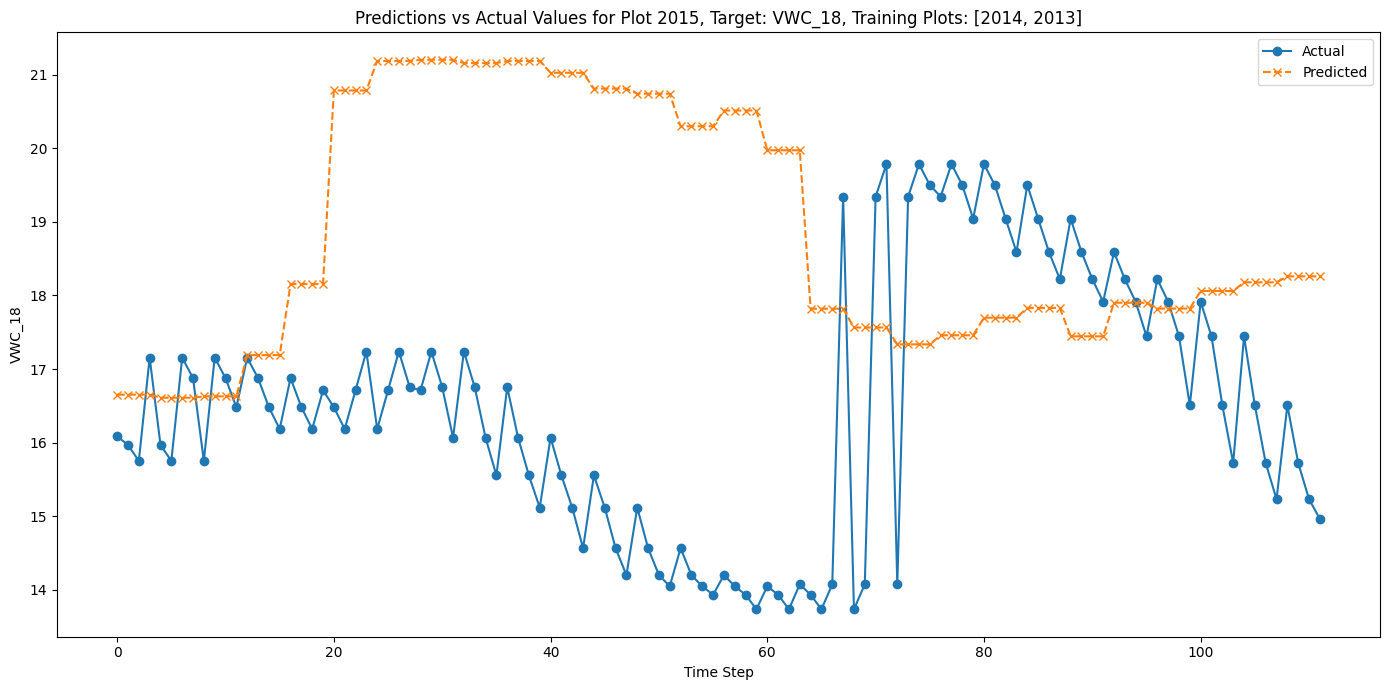

[[16.65298128 16.65298128 16.65298128 16.65298128]
 [16.61107349 16.61107349 16.61107349 16.61107349]
 [16.62936163 16.62936163 16.62936163 16.62936163]
 [17.18940306 17.18940306 17.18940306 17.18940306]
 [18.15545273 18.15545273 18.15545273 18.15545273]
 [20.78338432 20.78338432 20.78338432 20.78338432]
 [21.18483639 21.18483639 21.18483639 21.18483639]
 [21.20023346 21.20023346 21.20023346 21.20023346]
 [21.15569878 21.15569878 21.15569878 21.15569878]
 [21.18434811 21.18434811 21.18434811 21.18434811]
 [21.02423    21.02423    21.02423    21.02423   ]
 [20.80931568 20.80931568 20.80931568 20.80931568]
 [20.73962402 20.73962402 20.73962402 20.73962402]
 [20.29777622 20.29777622 20.29777622 20.29777622]
 [20.51169777 20.51169777 20.51169777 20.51169777]
 [19.97127914 19.97127914 19.97127914 19.97127914]
 [17.81964827 17.81964827 17.81964827 17.81964827]
 [17.56481075 17.56481075 17.56481075 17.56481075]
 [17.33559608 17.33559608 17.33559608 17.33559608]
 [17.45900393 17.45900393 17.45

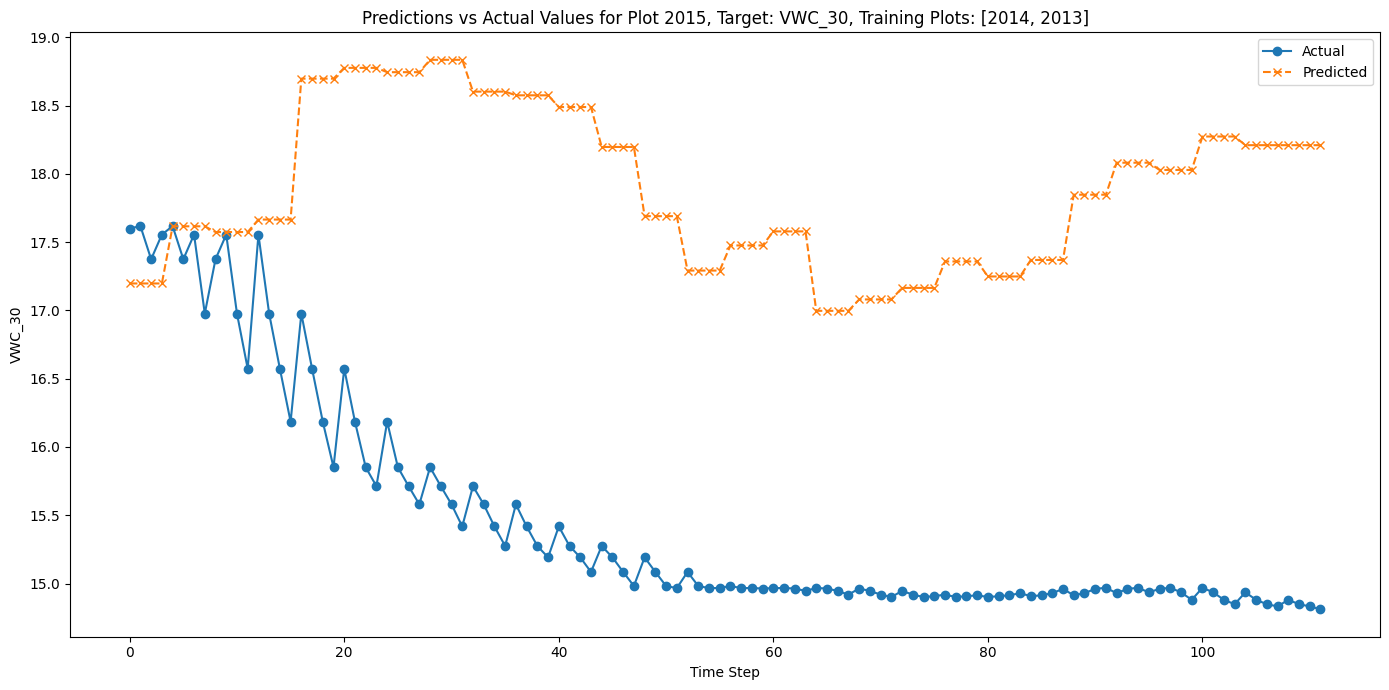

[[17.19747066 17.19747066 17.19747066 17.19747066]
 [17.61612892 17.61612892 17.61612892 17.61612892]
 [17.57404566 17.57404566 17.57404566 17.57404566]
 [17.66557741 17.66557741 17.66557741 17.66557741]
 [18.69751453 18.69751453 18.69751453 18.69751453]
 [18.77641392 18.77641392 18.77641392 18.77641392]
 [18.74488163 18.74488163 18.74488163 18.74488163]
 [18.83551502 18.83551502 18.83551502 18.83551502]
 [18.60254955 18.60254955 18.60254955 18.60254955]
 [18.5754714  18.5754714  18.5754714  18.5754714 ]
 [18.48972464 18.48972464 18.48972464 18.48972464]
 [18.19716597 18.19716597 18.19716597 18.19716597]
 [17.6904664  17.6904664  17.6904664  17.6904664 ]
 [17.29193449 17.29193449 17.29193449 17.29193449]
 [17.47598124 17.47598124 17.47598124 17.47598124]
 [17.5788722  17.5788722  17.5788722  17.5788722 ]
 [16.99712467 16.99712467 16.99712467 16.99712467]
 [17.08046436 17.08046436 17.08046436 17.08046436]
 [17.16495943 17.16495943 17.16495943 17.16495943]
 [17.35861063 17.35861063 17.35

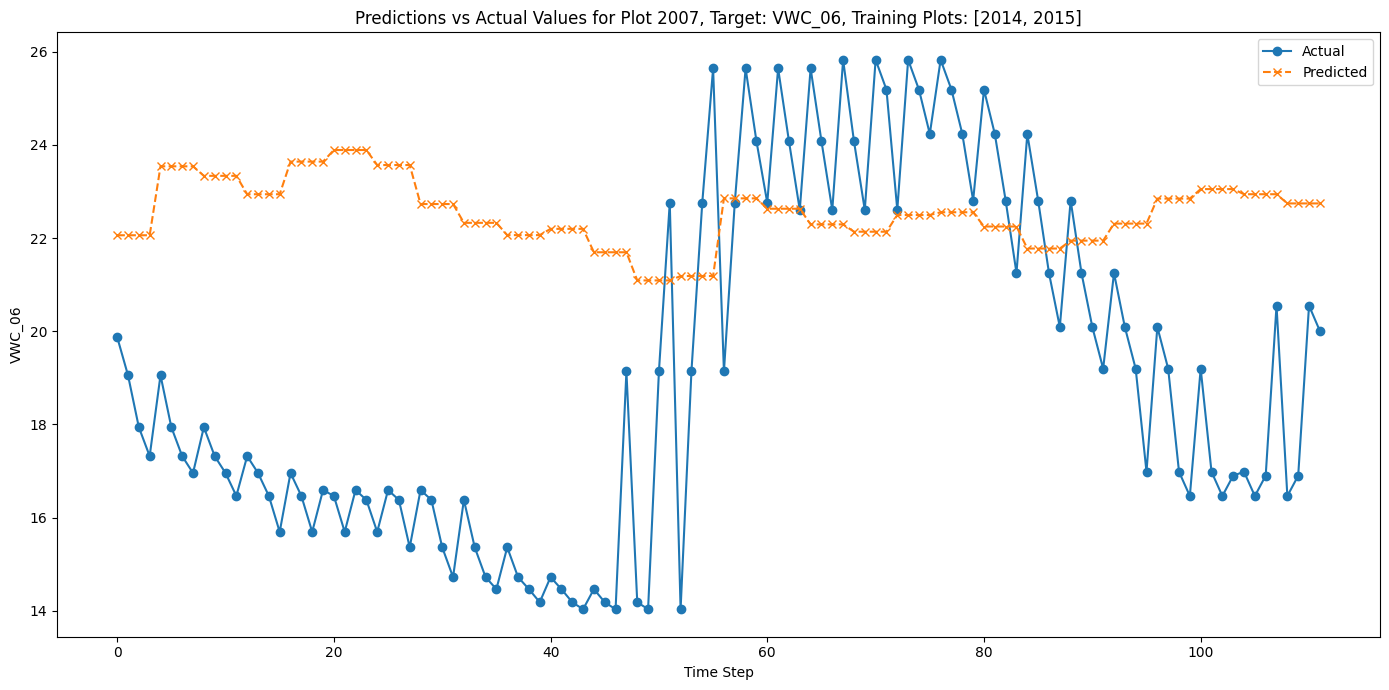

[[22.05963612 22.05963612 22.05963612 22.05963612]
 [23.53884602 23.53884602 23.53884602 23.53884602]
 [23.33446121 23.33446121 23.33446121 23.33446121]
 [22.93954945 22.93954945 22.93954945 22.93954945]
 [23.6396513  23.6396513  23.6396513  23.6396513 ]
 [23.88841248 23.88841248 23.88841248 23.88841248]
 [23.56629944 23.56629944 23.56629944 23.56629944]
 [22.72981644 22.72981644 22.72981644 22.72981644]
 [22.32626629 22.32626629 22.32626629 22.32626629]
 [22.06276798 22.06276798 22.06276798 22.06276798]
 [22.19705391 22.19705391 22.19705391 22.19705391]
 [21.69458771 21.69458771 21.69458771 21.69458771]
 [21.09046364 21.09046364 21.09046364 21.09046364]
 [21.1850462  21.1850462  21.1850462  21.1850462 ]
 [22.8511982  22.8511982  22.8511982  22.8511982 ]
 [22.62861443 22.62861443 22.62861443 22.62861443]
 [22.29305553 22.29305553 22.29305553 22.29305553]
 [22.13576126 22.13576126 22.13576126 22.13576126]
 [22.49403477 22.49403477 22.49403477 22.49403477]
 [22.55332661 22.55332661 22.55

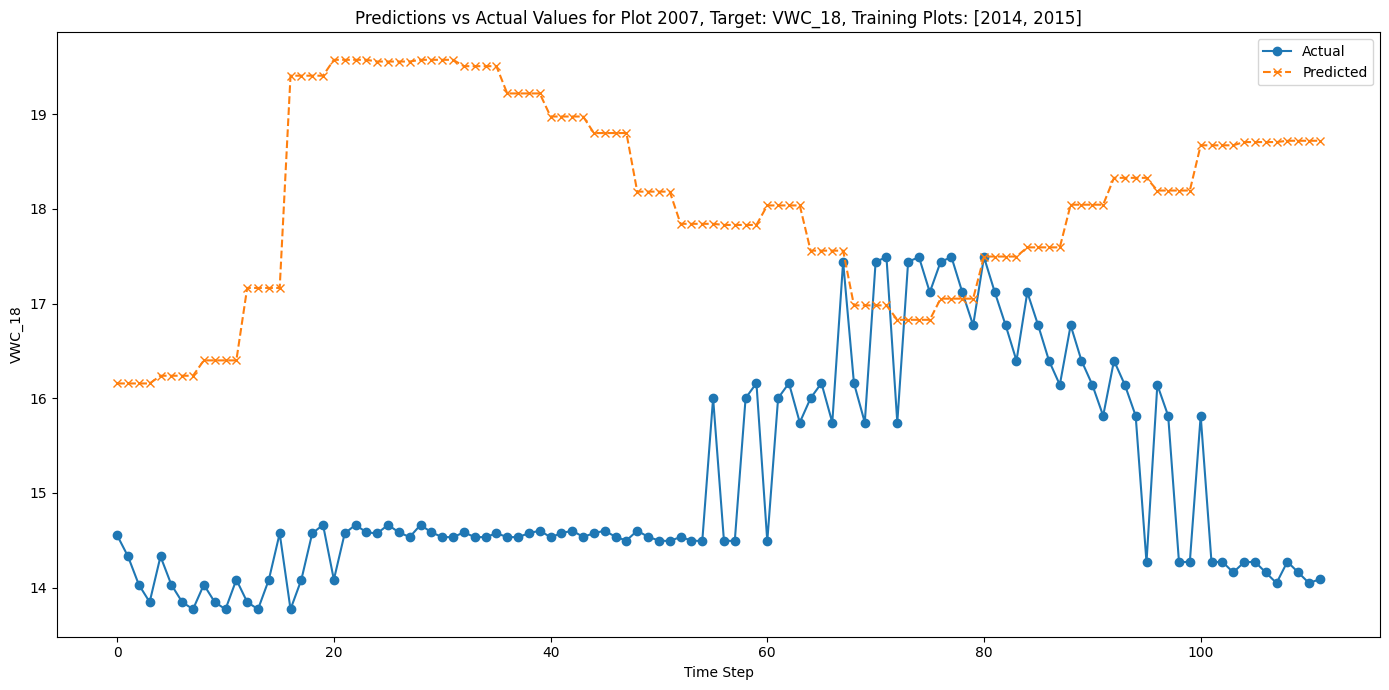

[[16.15633202 16.15633202 16.15633202 16.15633202]
 [16.23788118 16.23788118 16.23788118 16.23788118]
 [16.39997911 16.39997911 16.39997911 16.39997911]
 [17.16529703 17.16529703 17.16529703 17.16529703]
 [19.40785408 19.40785408 19.40785408 19.40785408]
 [19.57553101 19.57553101 19.57553101 19.57553101]
 [19.55725574 19.55725574 19.55725574 19.55725574]
 [19.57553101 19.57553101 19.57553101 19.57553101]
 [19.50829792 19.50829792 19.50829792 19.50829792]
 [19.22033405 19.22033405 19.22033405 19.22033405]
 [18.97653008 18.97653008 18.97653008 18.97653008]
 [18.80167294 18.80167294 18.80167294 18.80167294]
 [18.18290854 18.18290854 18.18290854 18.18290854]
 [17.84278727 17.84278727 17.84278727 17.84278727]
 [17.83103704 17.83103704 17.83103704 17.83103704]
 [18.03704453 18.03704453 18.03704453 18.03704453]
 [17.5592351  17.5592351  17.5592351  17.5592351 ]
 [16.98128319 16.98128319 16.98128319 16.98128319]
 [16.82879734 16.82879734 16.82879734 16.82879734]
 [17.0521946  17.0521946  17.05

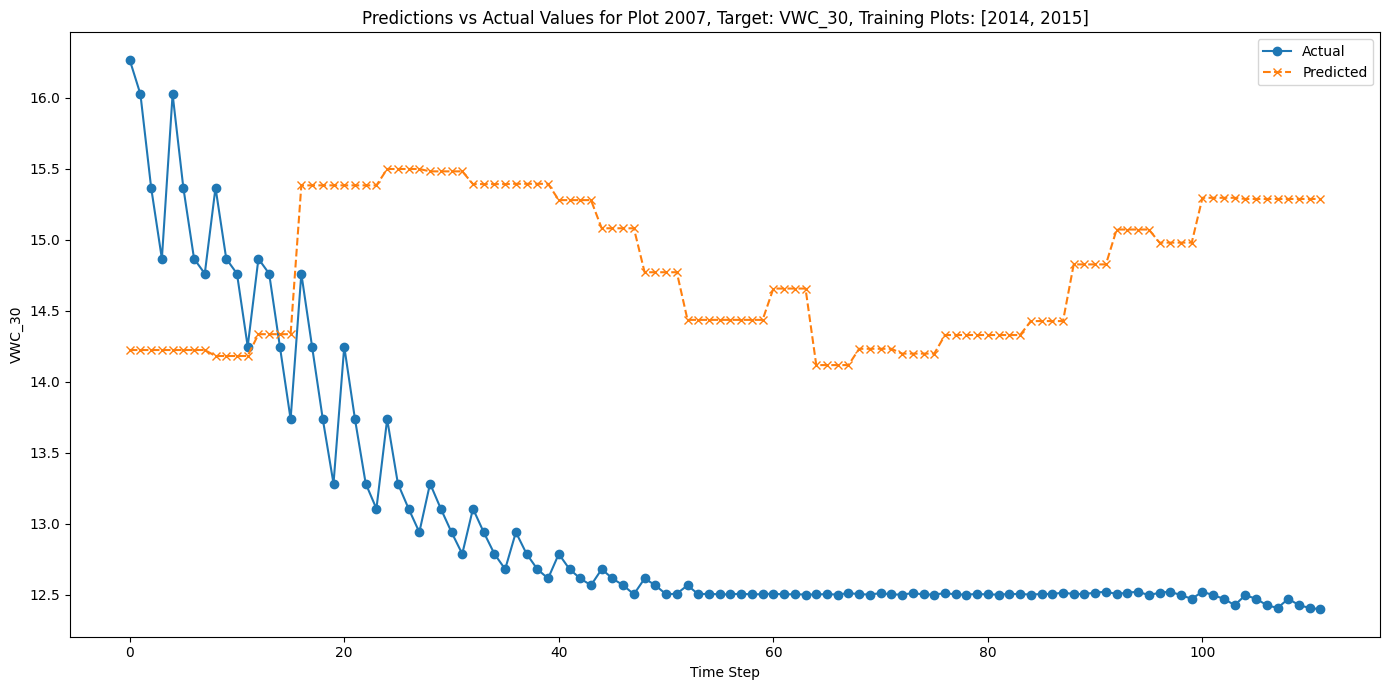

[[14.22347403 14.22347403 14.22347403 14.22347403]
 [14.22347403 14.22347403 14.22347403 14.22347403]
 [14.18139076 14.18139076 14.18139076 14.18139076]
 [14.33495712 14.33495712 14.33495712 14.33495712]
 [15.38375902 15.38375902 15.38375902 15.38375902]
 [15.38375902 15.38375902 15.38375902 15.38375902]
 [15.4990592  15.4990592  15.4990592  15.4990592 ]
 [15.48232794 15.48232794 15.48232794 15.48232794]
 [15.39261293 15.39261293 15.39261293 15.39261293]
 [15.39466    15.39466    15.39466    15.39466   ]
 [15.27978802 15.27978802 15.27978802 15.27978802]
 [15.0812459  15.0812459  15.0812459  15.0812459 ]
 [14.77143955 14.77143955 14.77143955 14.77143955]
 [14.43589306 14.43589306 14.43589306 14.43589306]
 [14.43589306 14.43589306 14.43589306 14.43589306]
 [14.65656757 14.65656757 14.65656757 14.65656757]
 [14.1172328  14.1172328  14.1172328  14.1172328 ]
 [14.23210478 14.23210478 14.23210478 14.23210478]
 [14.19812107 14.19812107 14.19812107 14.19812107]
 [14.32912064 14.32912064 14.32

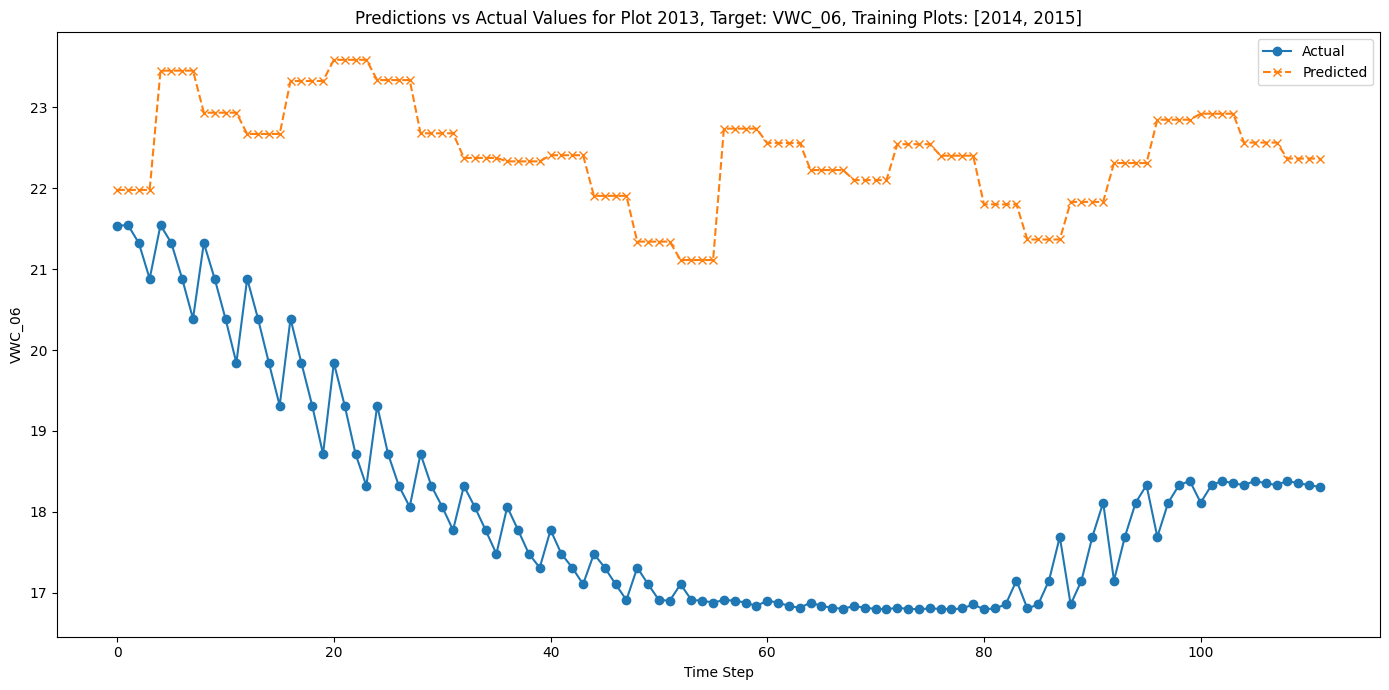

[[21.97972488 21.97972488 21.97972488 21.97972488]
 [23.45433617 23.45433617 23.45433617 23.45433617]
 [22.93464756 22.93464756 22.93464756 22.93464756]
 [22.67177773 22.67177773 22.67177773 22.67177773]
 [23.32693863 23.32693863 23.32693863 23.32693863]
 [23.58842945 23.58842945 23.58842945 23.58842945]
 [23.33792686 23.33792686 23.33792686 23.33792686]
 [22.67989922 22.67989922 22.67989922 22.67989922]
 [22.37538624 22.37538624 22.37538624 22.37538624]
 [22.33275318 22.33275318 22.33275318 22.33275318]
 [22.40880013 22.40880013 22.40880013 22.40880013]
 [21.90633392 21.90633392 21.90633392 21.90633392]
 [21.3405571  21.3405571  21.3405571  21.3405571 ]
 [21.11305141 21.11305141 21.11305141 21.11305141]
 [22.73758698 22.73758698 22.73758698 22.73758698]
 [22.55956841 22.55956841 22.55956841 22.55956841]
 [22.22548008 22.22548008 22.22548008 22.22548008]
 [22.10099602 22.10099602 22.10099602 22.10099602]
 [22.54500866 22.54500866 22.54500866 22.54500866]
 [22.40314007 22.40314007 22.40

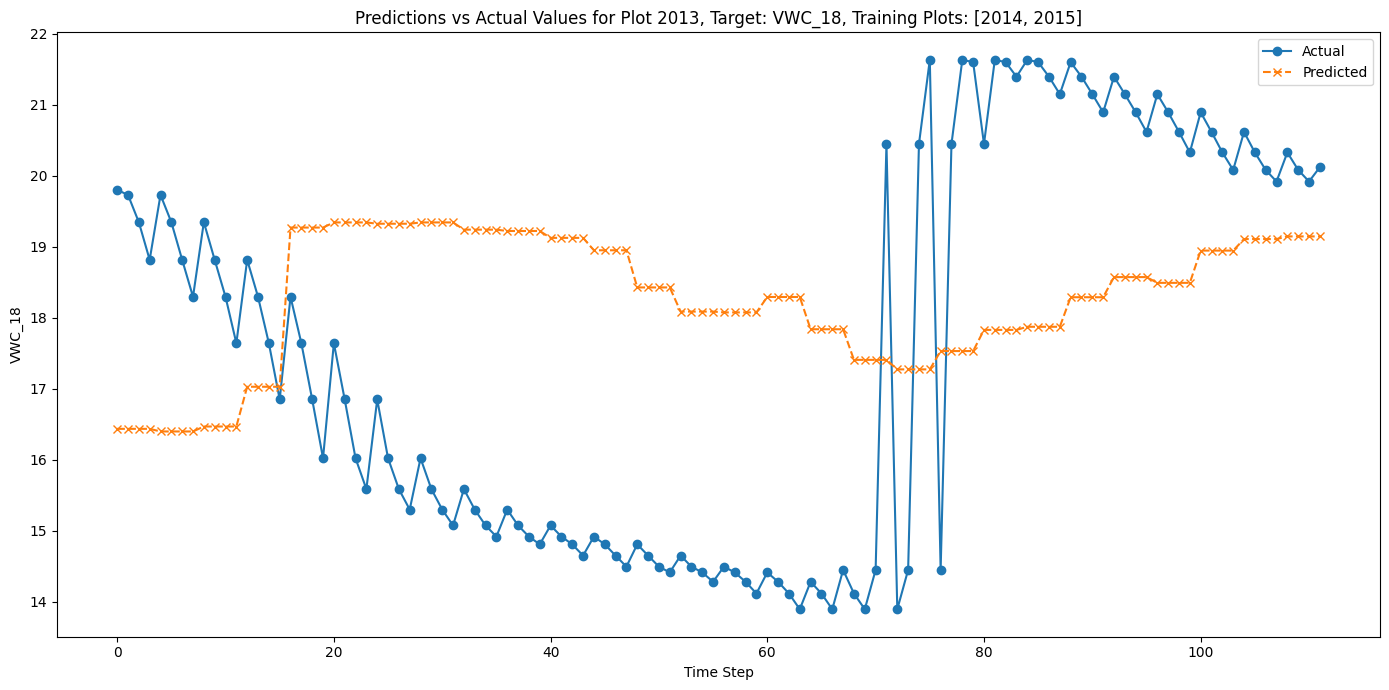

[[16.43367386 16.43367386 16.43367386 16.43367386]
 [16.39659214 16.39659214 16.39659214 16.39659214]
 [16.46652412 16.46652412 16.46652412 16.46652412]
 [17.02663231 17.02663231 17.02663231 17.02663231]
 [19.26918697 19.26918697 19.26918697 19.26918697]
 [19.34143639 19.34143639 19.34143639 19.34143639]
 [19.32316113 19.32316113 19.32316113 19.32316113]
 [19.34143639 19.34143639 19.34143639 19.34143639]
 [19.23962307 19.23962307 19.23962307 19.23962307]
 [19.22081661 19.22081661 19.22081661 19.22081661]
 [19.12386608 19.12386608 19.12386608 19.12386608]
 [18.9490099  18.9490099  18.9490099  18.9490099 ]
 [18.4256711  18.4256711  18.4256711  18.4256711 ]
 [18.08554983 18.08554983 18.08554983 18.08554983]
 [18.07379961 18.07379961 18.07379961 18.07379961]
 [18.29104948 18.29104948 18.29104948 18.29104948]
 [17.83657789 17.83657789 17.83657789 17.83657789]
 [17.40533161 17.40533161 17.40533161 17.40533161]
 [17.27129269 17.27129269 17.27129269 17.27129269]
 [17.52927017 17.52927017 17.52

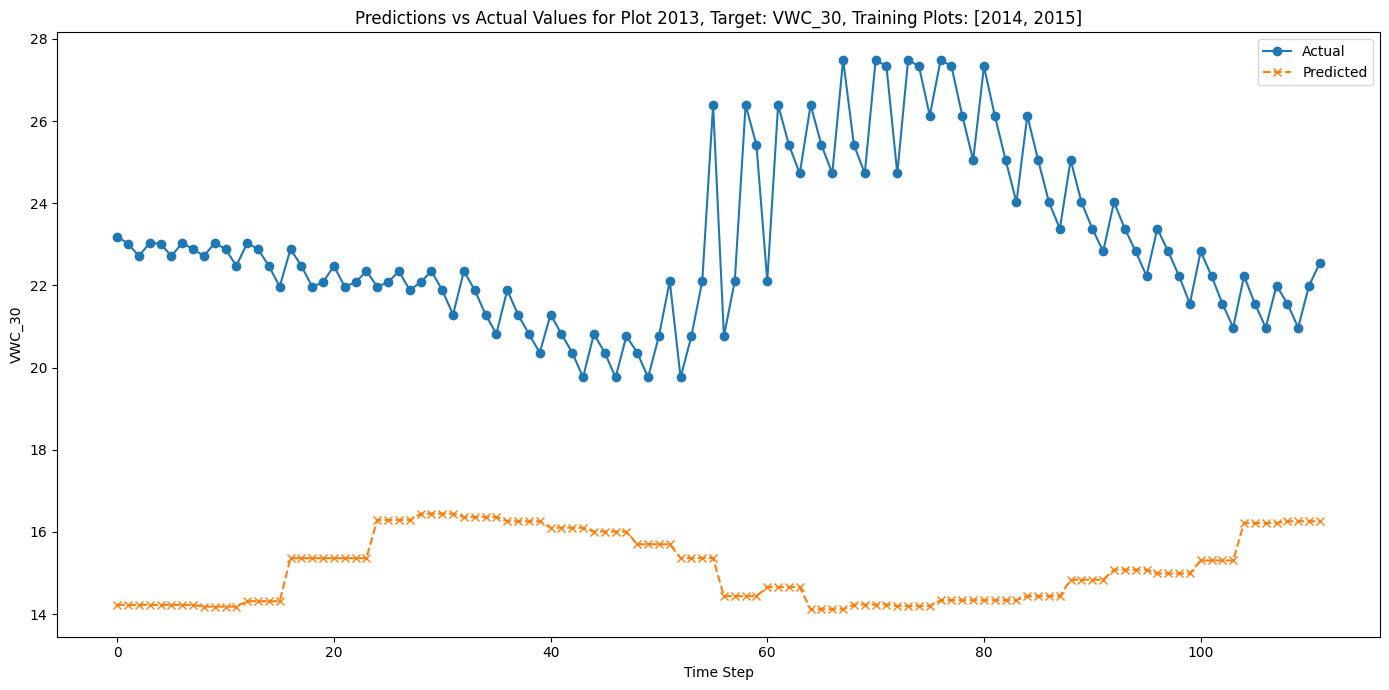

[[14.22347403 14.22347403 14.22347403 14.22347403]
 [14.22347403 14.22347403 14.22347403 14.22347403]
 [14.18139076 14.18139076 14.18139076 14.18139076]
 [14.31239033 14.31239033 14.31239033 14.31239033]
 [15.36119223 15.36119223 15.36119223 15.36119223]
 [15.36119223 15.36119223 15.36119223 15.36119223]
 [16.2889266  16.2889266  16.2889266  16.2889266 ]
 [16.44472456 16.44472456 16.44472456 16.44472456]
 [16.36364126 16.36364126 16.36364126 16.36364126]
 [16.25958109 16.25958109 16.25958109 16.25958109]
 [16.10085344 16.10085344 16.10085344 16.10085344]
 [16.00897837 16.00897837 16.00897837 16.00897837]
 [15.69917345 15.69917345 15.69917345 15.69917345]
 [15.36362934 15.36362934 15.36362934 15.36362934]
 [14.43589306 14.43589306 14.43589306 14.43589306]
 [14.65656757 14.65656757 14.65656757 14.65656757]
 [14.1172328  14.1172328  14.1172328  14.1172328 ]
 [14.23210478 14.23210478 14.23210478 14.23210478]
 [14.19812107 14.19812107 14.19812107 14.19812107]
 [14.33775139 14.33775139 14.33

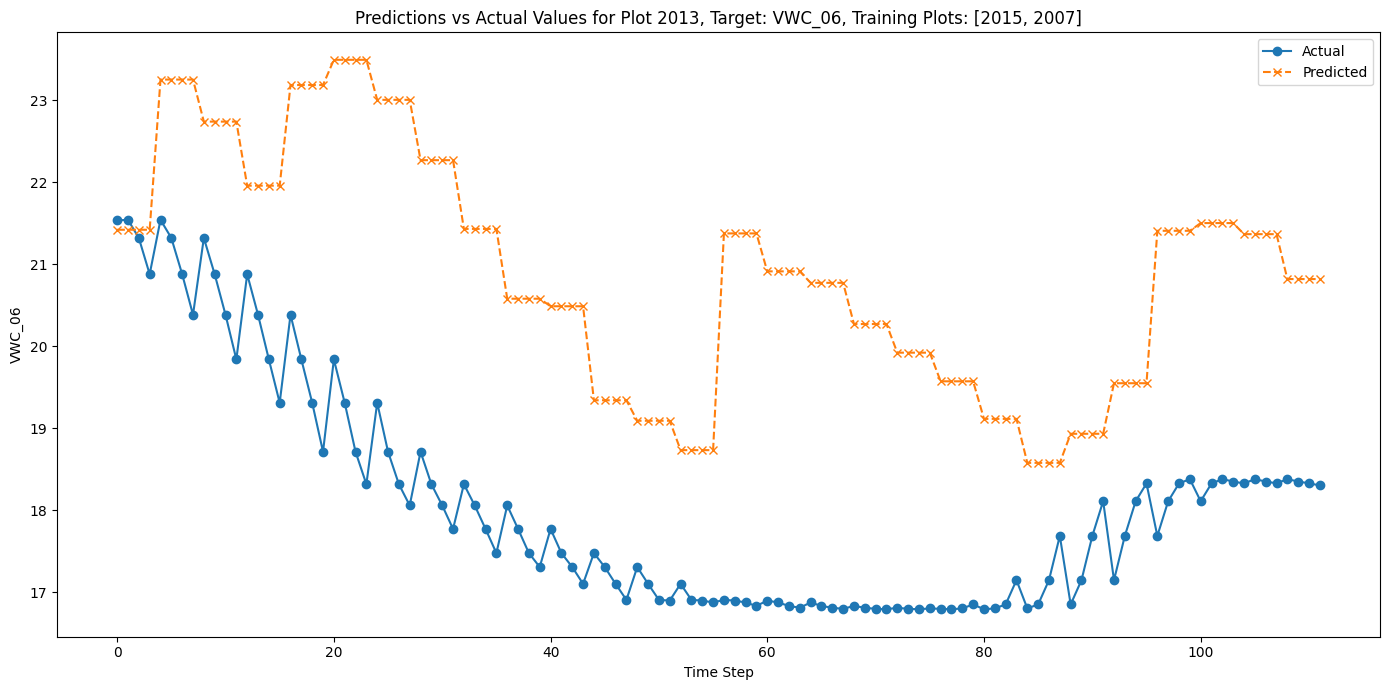

[[21.42350006 21.42350006 21.42350006 21.42350006]
 [23.25527096 23.25527096 23.25527096 23.25527096]
 [22.74232769 22.74232769 22.74232769 22.74232769]
 [21.9609108  21.9609108  21.9609108  21.9609108 ]
 [23.18863964 23.18863964 23.18863964 23.18863964]
 [23.49603081 23.49603081 23.49603081 23.49603081]
 [23.00780582 23.00780582 23.00780582 23.00780582]
 [22.2719593  22.2719593  22.2719593  22.2719593 ]
 [21.43378258 21.43378258 21.43378258 21.43378258]
 [20.58241177 20.58241177 20.58241177 20.58241177]
 [20.49042034 20.49042034 20.49042034 20.49042034]
 [19.34378624 19.34378624 19.34378624 19.34378624]
 [19.09400749 19.09400749 19.09400749 19.09400749]
 [18.73570251 18.73570251 18.73570251 18.73570251]
 [21.37890625 21.37890625 21.37890625 21.37890625]
 [20.9160862  20.9160862  20.9160862  20.9160862 ]
 [20.77624226 20.77624226 20.77624226 20.77624226]
 [20.27374172 20.27374172 20.27374172 20.27374172]
 [19.92444324 19.92444324 19.92444324 19.92444324]
 [19.57500553 19.57500553 19.57

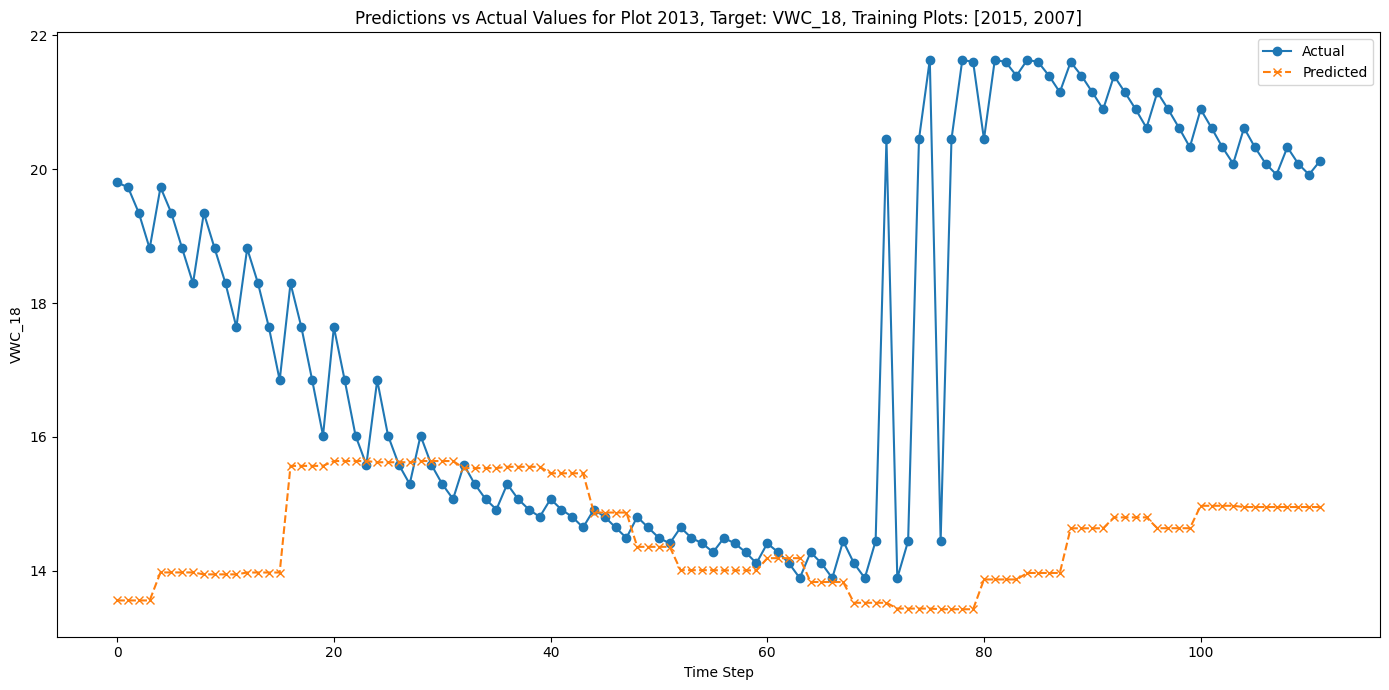

[[13.55822754 13.55822754 13.55822754 13.55822754]
 [13.97677708 13.97677708 13.97677708 13.97677708]
 [13.94763231 13.94763231 13.94763231 13.94763231]
 [13.97555304 13.97555304 13.97555304 13.97555304]
 [15.56808376 15.56808376 15.56808376 15.56808376]
 [15.64033318 15.64033318 15.64033318 15.64033318]
 [15.62205791 15.62205791 15.62205791 15.62205791]
 [15.64033318 15.64033318 15.64033318 15.64033318]
 [15.53480577 15.53480577 15.53480577 15.53480577]
 [15.55429363 15.55429363 15.55429363 15.55429363]
 [15.4573431  15.4573431  15.4573431  15.4573431 ]
 [14.87131548 14.87131548 14.87131548 14.87131548]
 [14.35886574 14.35886574 14.35886574 14.35886574]
 [14.0101552  14.0101552  14.0101552  14.0101552 ]
 [14.00699425 14.00699425 14.00699425 14.00699425]
 [14.18966389 14.18966389 14.18966389 14.18966389]
 [13.83380222 13.83380222 13.83380222 13.83380222]
 [13.5234313  13.5234313  13.5234313  13.5234313 ]
 [13.43718576 13.43718576 13.43718576 13.43718576]
 [13.42681217 13.42681217 13.42

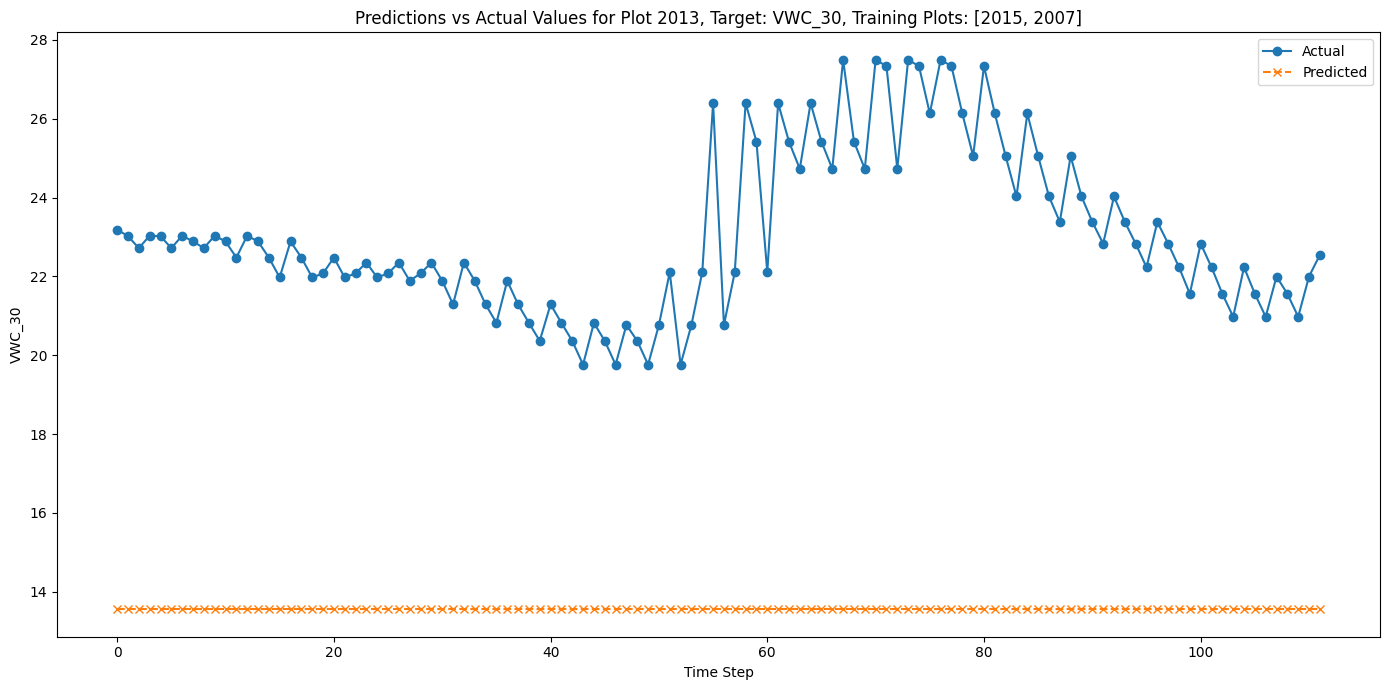

[[13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55

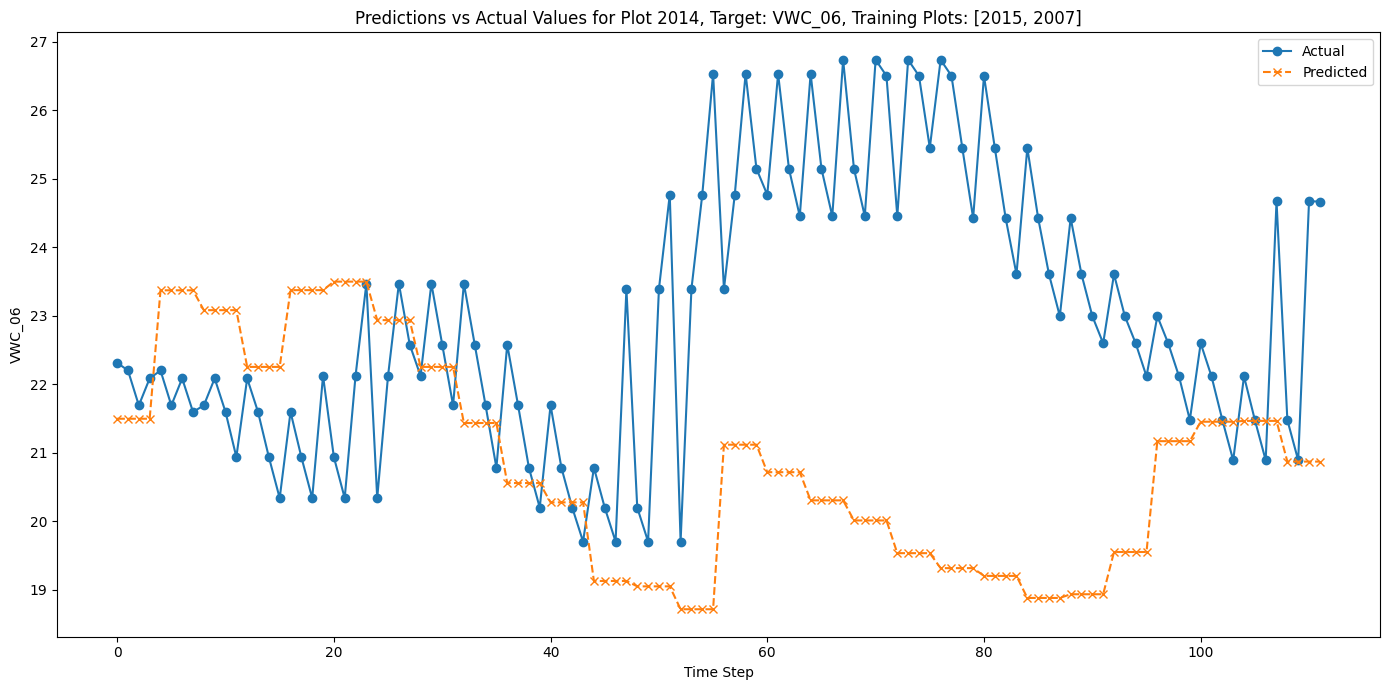

[[21.4961462  21.4961462  21.4961462  21.4961462 ]
 [23.37007141 23.37007141 23.37007141 23.37007141]
 [23.08016109 23.08016109 23.08016109 23.08016109]
 [22.25244141 22.25244141 22.25244141 22.25244141]
 [23.37235355 23.37235355 23.37235355 23.37235355]
 [23.4966898  23.4966898  23.4966898  23.4966898 ]
 [22.9348259  22.9348259  22.9348259  22.9348259 ]
 [22.25253963 22.25253963 22.25253963 22.25253963]
 [21.43378258 21.43378258 21.43378258 21.43378258]
 [20.5576334  20.5576334  20.5576334  20.5576334 ]
 [20.27567673 20.27567673 20.27567673 20.27567673]
 [19.12904263 19.12904263 19.12904263 19.12904263]
 [19.05036259 19.05036259 19.05036259 19.05036259]
 [18.71628284 18.71628284 18.71628284 18.71628284]
 [21.11727619 21.11727619 21.11727619 21.11727619]
 [20.71623707 20.71623707 20.71623707 20.71623707]
 [20.30502033 20.30502033 20.30502033 20.30502033]
 [20.01190472 20.01190472 20.01190472 20.01190472]
 [19.5346241  19.5346241  19.5346241  19.5346241 ]
 [19.31622219 19.31622219 19.31

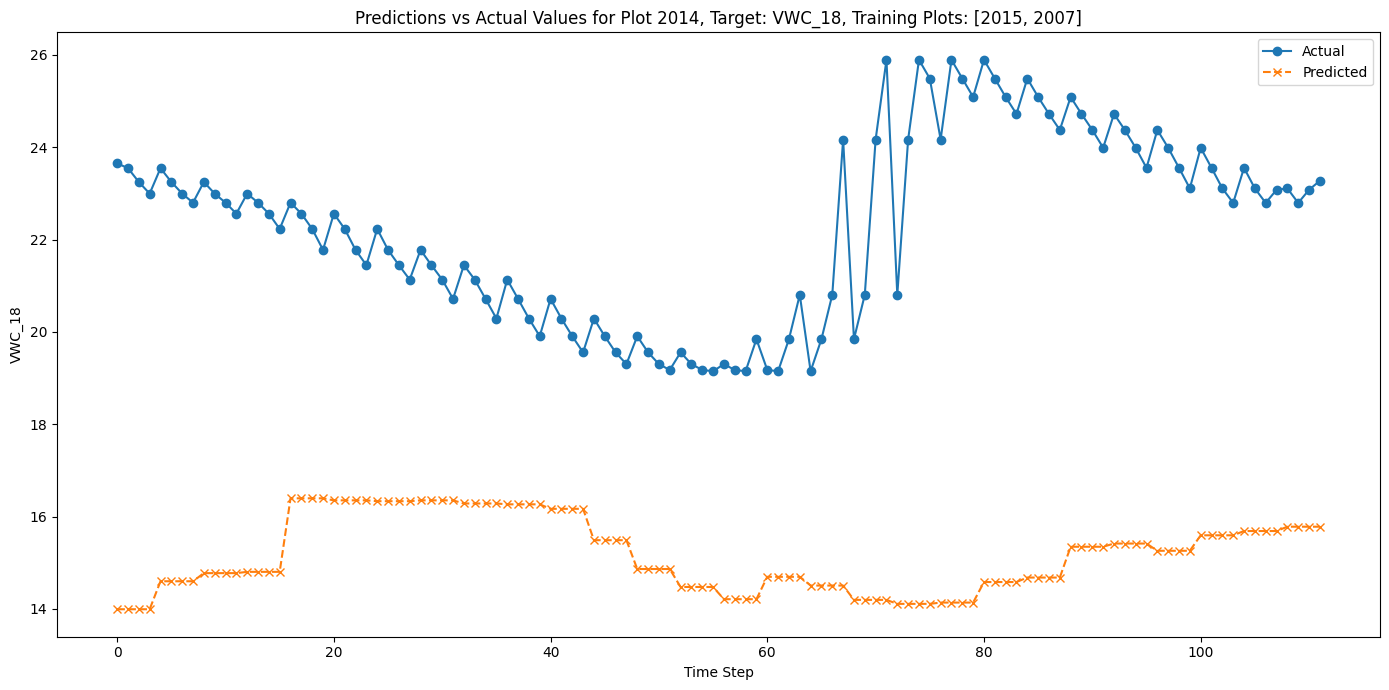

[[13.99224854 13.99224854 13.99224854 13.99224854]
 [14.59839249 14.59839249 14.59839249 14.59839249]
 [14.77445841 14.77445841 14.77445841 14.77445841]
 [14.80237818 14.80237818 14.80237818 14.80237818]
 [16.39491129 16.39491129 16.39491129 16.39491129]
 [16.35050726 16.35050726 16.35050726 16.35050726]
 [16.332232   16.332232   16.332232   16.332232  ]
 [16.35050726 16.35050726 16.35050726 16.35050726]
 [16.28327417 16.28327417 16.28327417 16.28327417]
 [16.26446772 16.26446772 16.26446772 16.26446772]
 [16.16751528 16.16751528 16.16751528 16.16751528]
 [15.48782921 15.48782921 15.48782921 15.48782921]
 [14.8638258  14.8638258  14.8638258  14.8638258 ]
 [14.47471476 14.47471476 14.47471476 14.47471476]
 [14.21003675 14.21003675 14.21003675 14.21003675]
 [14.6946249  14.6946249  14.6946249  14.6946249 ]
 [14.50567961 14.50567961 14.50567961 14.50567961]
 [14.19530869 14.19530869 14.19530869 14.19530869]
 [14.10906315 14.10906315 14.10906315 14.10906315]
 [14.13698292 14.13698292 14.13

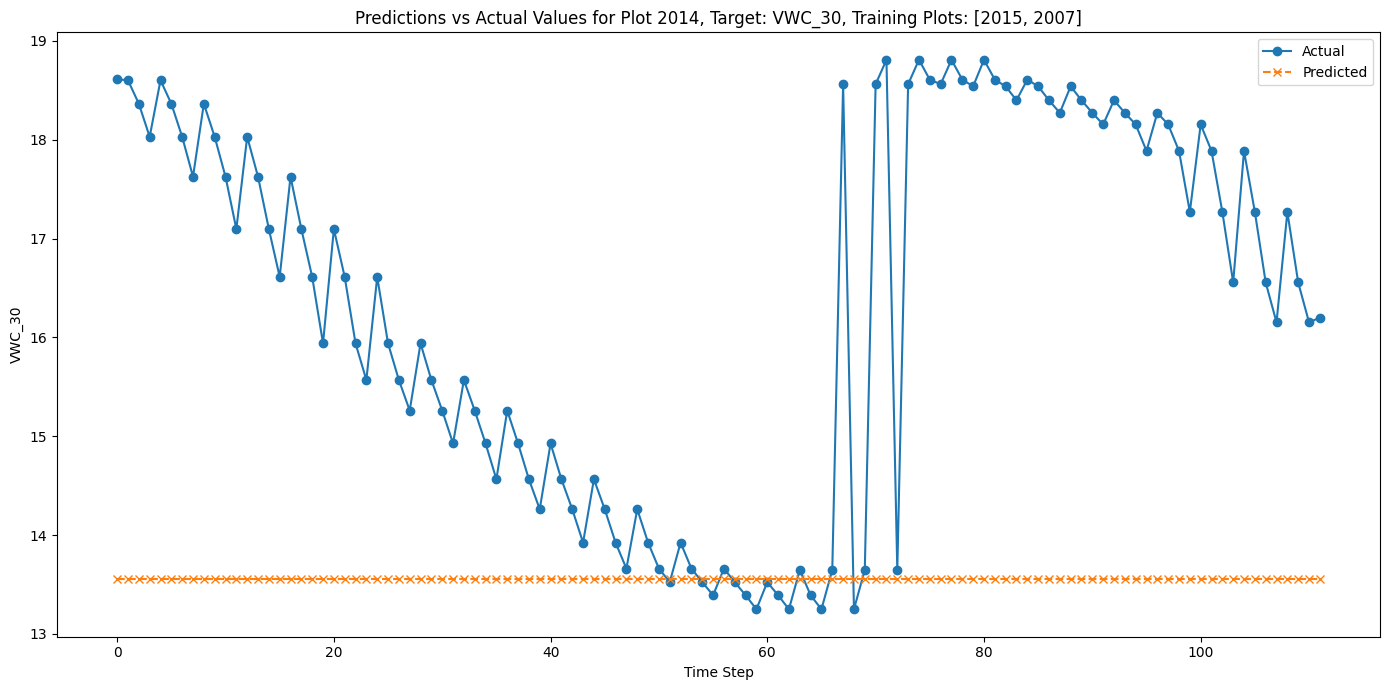

[[13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55580807 13.55580807]
 [13.55580807 13.55580807 13.55

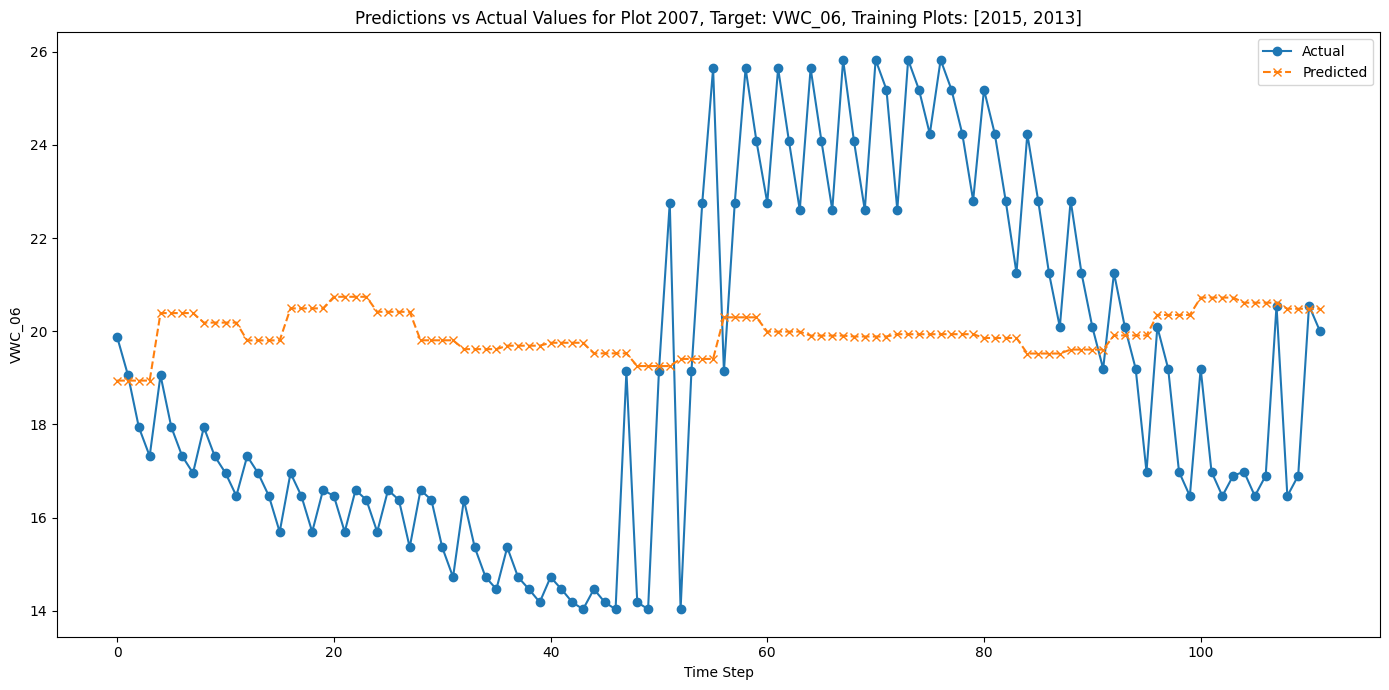

[[18.94148254 18.94148254 18.94148254 18.94148254]
 [20.38991737 20.38991737 20.38991737 20.38991737]
 [20.18553257 20.18553257 20.18553257 20.18553257]
 [19.80399323 19.80399323 19.80399323 19.80399323]
 [20.49072266 20.49072266 20.49072266 20.49072266]
 [20.73948383 20.73948383 20.73948383 20.73948383]
 [20.4173708  20.4173708  20.4173708  20.4173708 ]
 [19.80566406 19.80566406 19.80566406 19.80566406]
 [19.616292   19.616292   19.616292   19.616292  ]
 [19.69009781 19.69009781 19.69009781 19.69009781]
 [19.75298023 19.75298023 19.75298023 19.75298023]
 [19.52591228 19.52591228 19.52591228 19.52591228]
 [19.25288105 19.25288105 19.25288105 19.25288105]
 [19.40629292 19.40629292 19.40629292 19.40629292]
 [20.29887009 20.29887009 20.29887009 20.29887009]
 [19.99156284 19.99156284 19.99156284 19.99156284]
 [19.90620899 19.90620899 19.90620899 19.90620899]
 [19.88691902 19.88691902 19.88691902 19.88691902]
 [19.93627548 19.93627548 19.93627548 19.93627548]
 [19.93732834 19.93732834 19.93

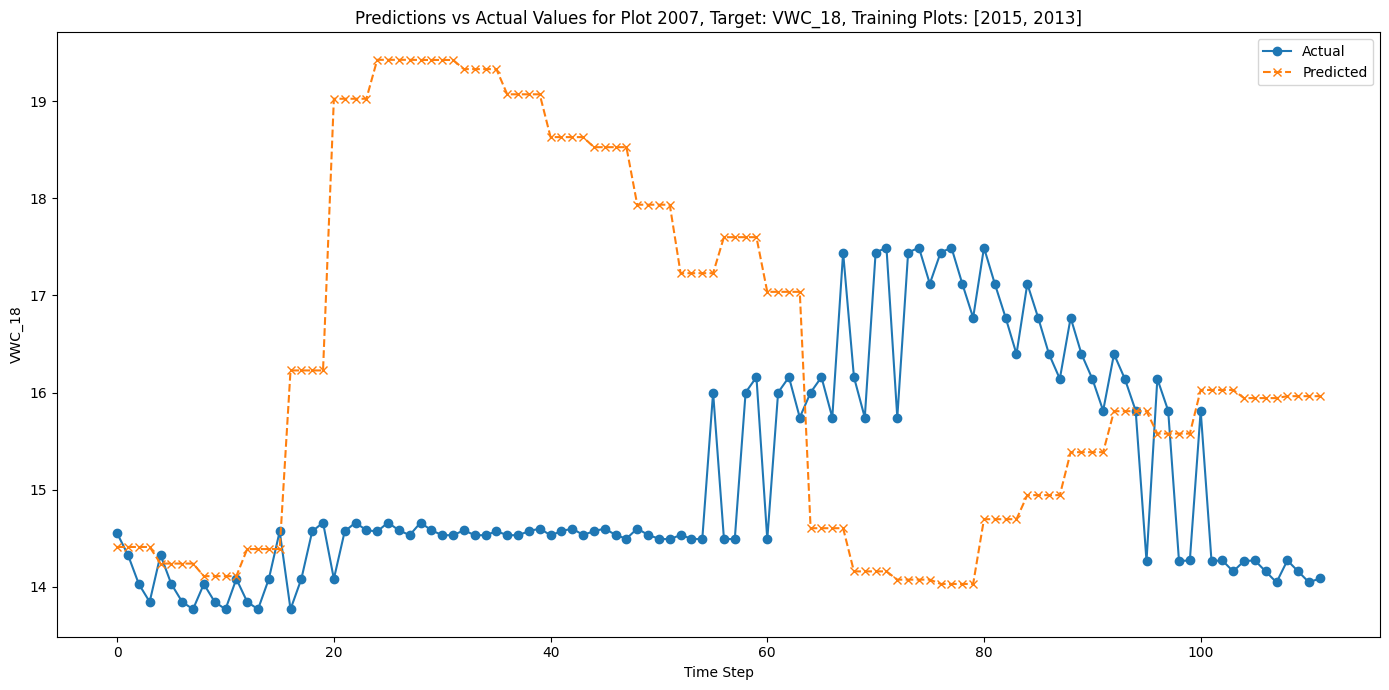

[[14.41179562 14.41179562 14.41179562 14.41179562]
 [14.24110222 14.24110222 14.24110222 14.24110222]
 [14.11145544 14.11145544 14.11145544 14.11145544]
 [14.39008617 14.39008617 14.39008617 14.39008617]
 [16.22813988 16.22813988 16.22813988 16.22813988]
 [19.0237484  19.0237484  19.0237484  19.0237484 ]
 [19.42457104 19.42457104 19.42457104 19.42457104]
 [19.4229517  19.4229517  19.4229517  19.4229517 ]
 [19.32882977 19.32882977 19.32882977 19.32882977]
 [19.06951523 19.06951523 19.06951523 19.06951523]
 [18.62914276 18.62914276 18.62914276 18.62914276]
 [18.5256834  18.5256834  18.5256834  18.5256834 ]
 [17.93355417 17.93355417 17.93355417 17.93355417]
 [17.22864103 17.22864103 17.22864103 17.22864103]
 [17.59938192 17.59938192 17.59938192 17.59938192]
 [17.03699112 17.03699112 17.03699112 17.03699112]
 [14.60477066 14.60477066 14.60477066 14.60477066]
 [14.16043758 14.16043758 14.16043758 14.16043758]
 [14.07556868 14.07556868 14.07556868 14.07556868]
 [14.03142071 14.03142071 14.03

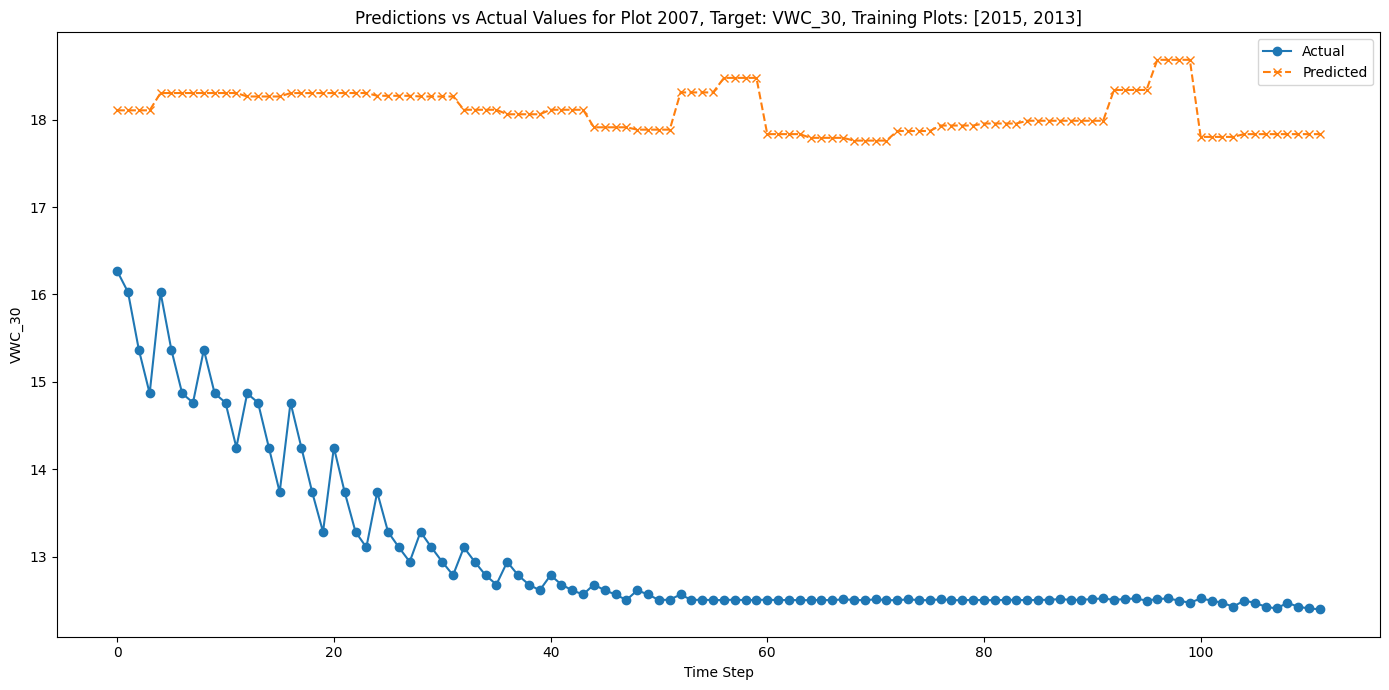

[[18.10686255 18.10686255 18.10686255 18.10686255]
 [18.304811   18.304811   18.304811   18.304811  ]
 [18.304811   18.304811   18.304811   18.304811  ]
 [18.26534319 18.26534319 18.26534319 18.26534319]
 [18.30422735 18.30422735 18.30422735 18.30422735]
 [18.304811   18.304811   18.304811   18.304811  ]
 [18.27327871 18.27327871 18.27327871 18.27327871]
 [18.26534319 18.26534319 18.26534319 18.26534319]
 [18.11346197 18.11346197 18.11346197 18.11346197]
 [18.06176996 18.06176996 18.06176996 18.06176996]
 [18.11346197 18.11346197 18.11346197 18.11346197]
 [17.91277647 17.91277647 17.91277647 17.91277647]
 [17.88585234 17.88585234 17.88585234 17.88585234]
 [18.31193018 18.31193018 18.31193018 18.31193018]
 [18.47827005 18.47827005 18.47827005 18.47827005]
 [17.83446074 17.83446074 17.83446074 17.83446074]
 [17.79204798 17.79204798 17.79204798 17.79204798]
 [17.76051569 17.76051569 17.76051569 17.76051569]
 [17.87036371 17.87036371 17.87036371 17.87036371]
 [17.93301535 17.93301535 17.93

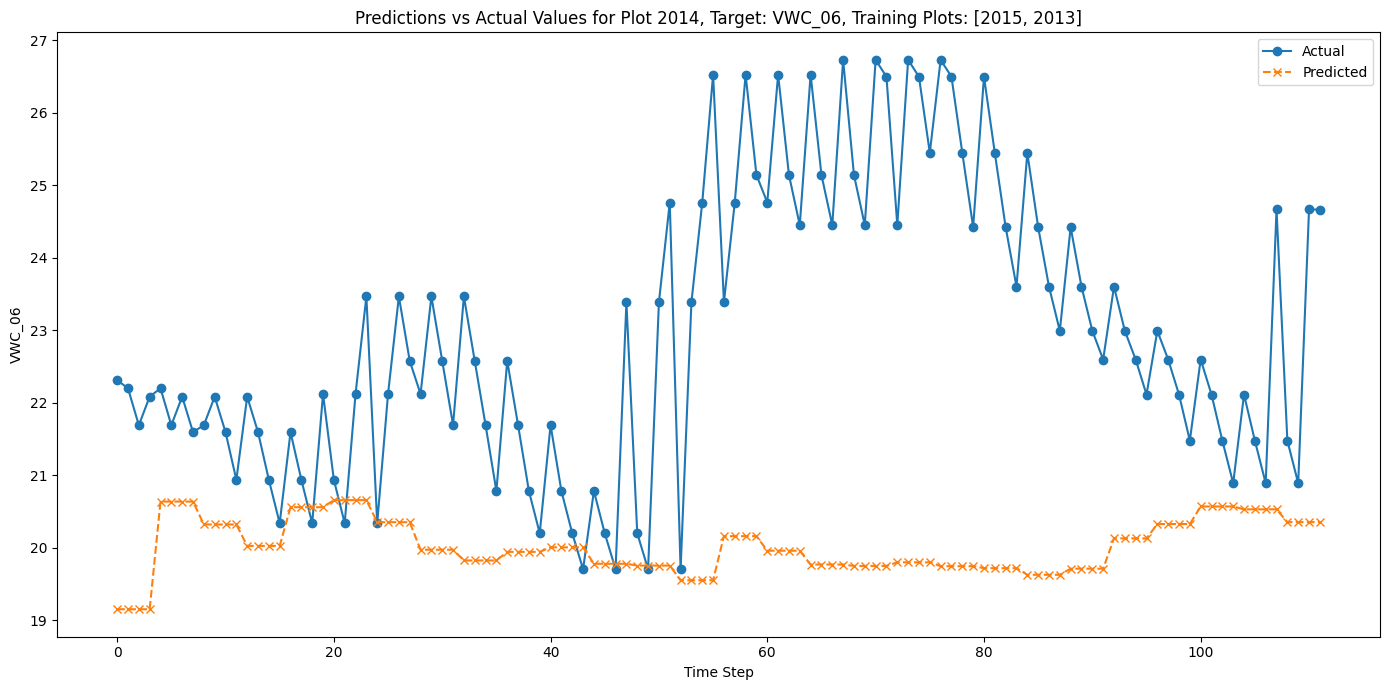

[[19.15108109 19.15108109 19.15108109 19.15108109]
 [20.63707161 20.63707161 20.63707161 20.63707161]
 [20.32099628 20.32099628 20.32099628 20.32099628]
 [20.02519608 20.02519608 20.02519608 20.02519608]
 [20.55916786 20.55916786 20.55916786 20.55916786]
 [20.65702343 20.65702343 20.65702343 20.65702343]
 [20.3523016  20.3523016  20.3523016  20.3523016 ]
 [19.97261047 19.97261047 19.97261047 19.97261047]
 [19.8240366  19.8240366  19.8240366  19.8240366 ]
 [19.94278336 19.94278336 19.94278336 19.94278336]
 [20.00566578 20.00566578 20.00566578 20.00566578]
 [19.77859783 19.77859783 19.77859783 19.77859783]
 [19.75385189 19.75385189 19.75385189 19.75385189]
 [19.55116177 19.55116177 19.55116177 19.55116177]
 [20.15991211 20.15991211 20.15991211 20.15991211]
 [19.958951   19.958951   19.958951   19.958951  ]
 [19.76823139 19.76823139 19.76823139 19.76823139]
 [19.74894142 19.74894142 19.74894142 19.74894142]
 [19.79829788 19.79829788 19.79829788 19.79829788]
 [19.74522209 19.74522209 19.74

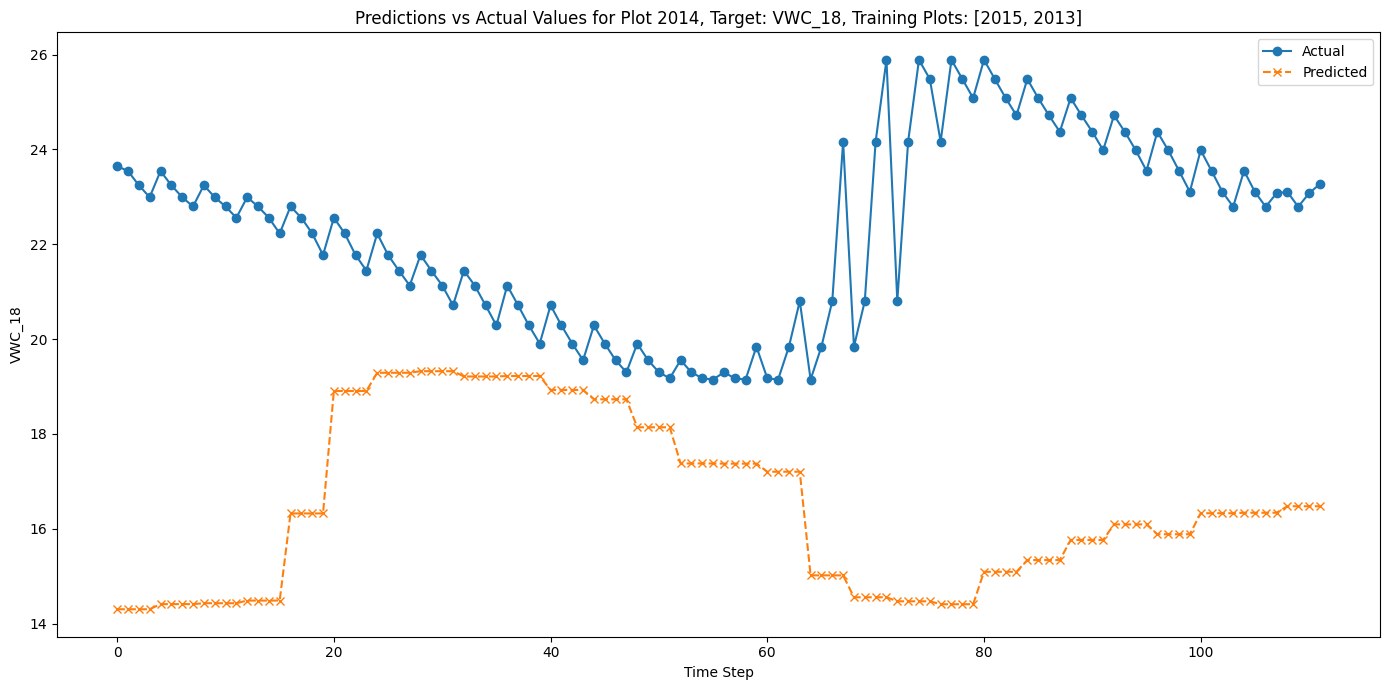

[[14.30244637 14.30244637 14.30244637 14.30244637]
 [14.41105127 14.41105127 14.41105127 14.41105127]
 [14.42973995 14.42973995 14.42973995 14.42973995]
 [14.48551369 14.48551369 14.48551369 14.48551369]
 [16.32356739 16.32356739 16.32356739 16.32356739]
 [18.90709496 18.90709496 18.90709496 18.90709496]
 [19.29027176 19.29027176 19.29027176 19.29027176]
 [19.32394409 19.32394409 19.32394409 19.32394409]
 [19.21217632 19.21217632 19.21217632 19.21217632]
 [19.2220192  19.2220192  19.2220192  19.2220192 ]
 [18.92849827 18.92849827 18.92849827 18.92849827]
 [18.73138142 18.73138142 18.73138142 18.73138142]
 [18.14076996 18.14076996 18.14076996 18.14076996]
 [17.37781048 17.37781048 17.37781048 17.37781048]
 [17.37351322 17.37351322 17.37351322 17.37351322]
 [17.20322418 17.20322418 17.20322418 17.20322418]
 [15.01719761 15.01719761 15.01719761 15.01719761]
 [14.55521917 14.55521917 14.55521917 14.55521917]
 [14.47035027 14.47035027 14.47035027 14.47035027]
 [14.40855598 14.40855598 14.40

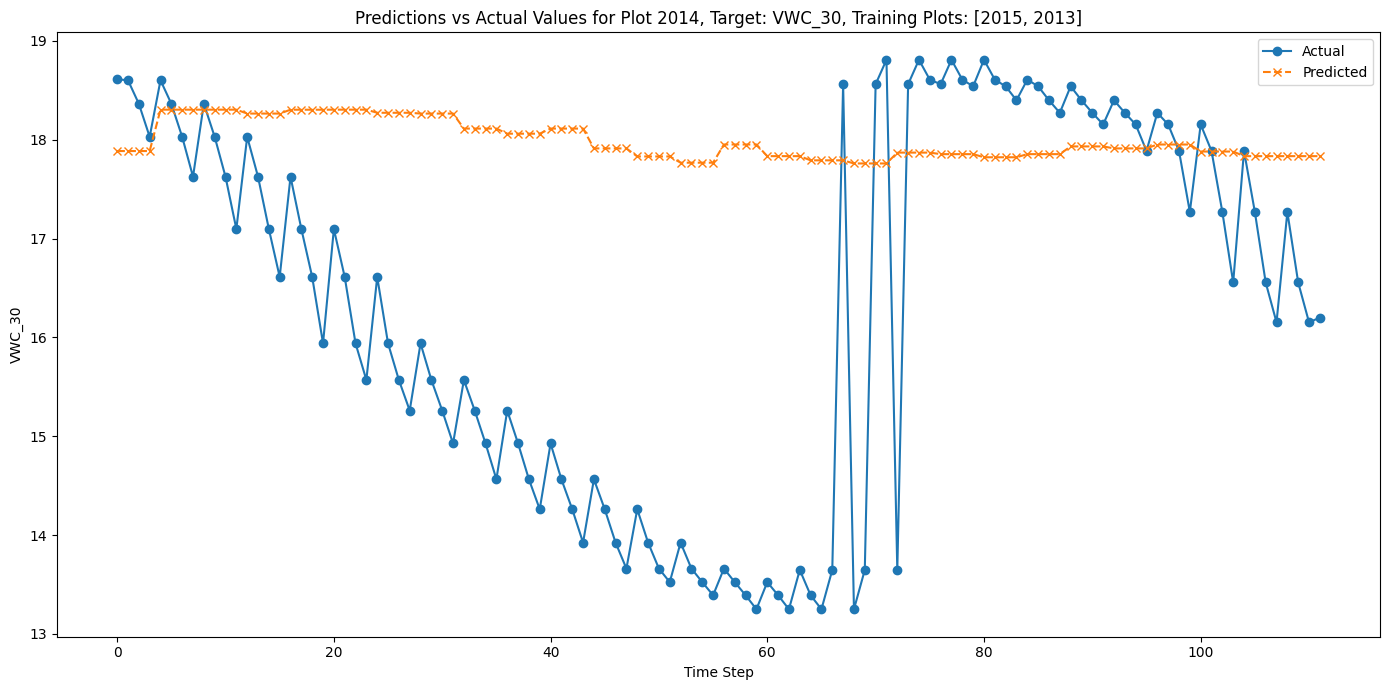

[[17.88615274 17.88615274 17.88615274 17.88615274]
 [18.304811   18.304811   18.304811   18.304811  ]
 [18.304811   18.304811   18.304811   18.304811  ]
 [18.26534319 18.26534319 18.26534319 18.26534319]
 [18.30422735 18.30422735 18.30422735 18.30422735]
 [18.304811   18.304811   18.304811   18.304811  ]
 [18.27327871 18.27327871 18.27327871 18.27327871]
 [18.26534319 18.26534319 18.26534319 18.26534319]
 [18.11346197 18.11346197 18.11346197 18.11346197]
 [18.06176996 18.06176996 18.06176996 18.06176996]
 [18.11346197 18.11346197 18.11346197 18.11346197]
 [17.91277647 17.91277647 17.91277647 17.91277647]
 [17.83118296 17.83118296 17.83118296 17.83118296]
 [17.76819754 17.76819754 17.76819754 17.76819754]
 [17.95224428 17.95224428 17.95224428 17.95224428]
 [17.83446074 17.83446074 17.83446074 17.83446074]
 [17.79204798 17.79204798 17.79204798 17.79204798]
 [17.76051569 17.76051569 17.76051569 17.76051569]
 [17.87036371 17.87036371 17.87036371 17.87036371]
 [17.85469961 17.85469961 17.85

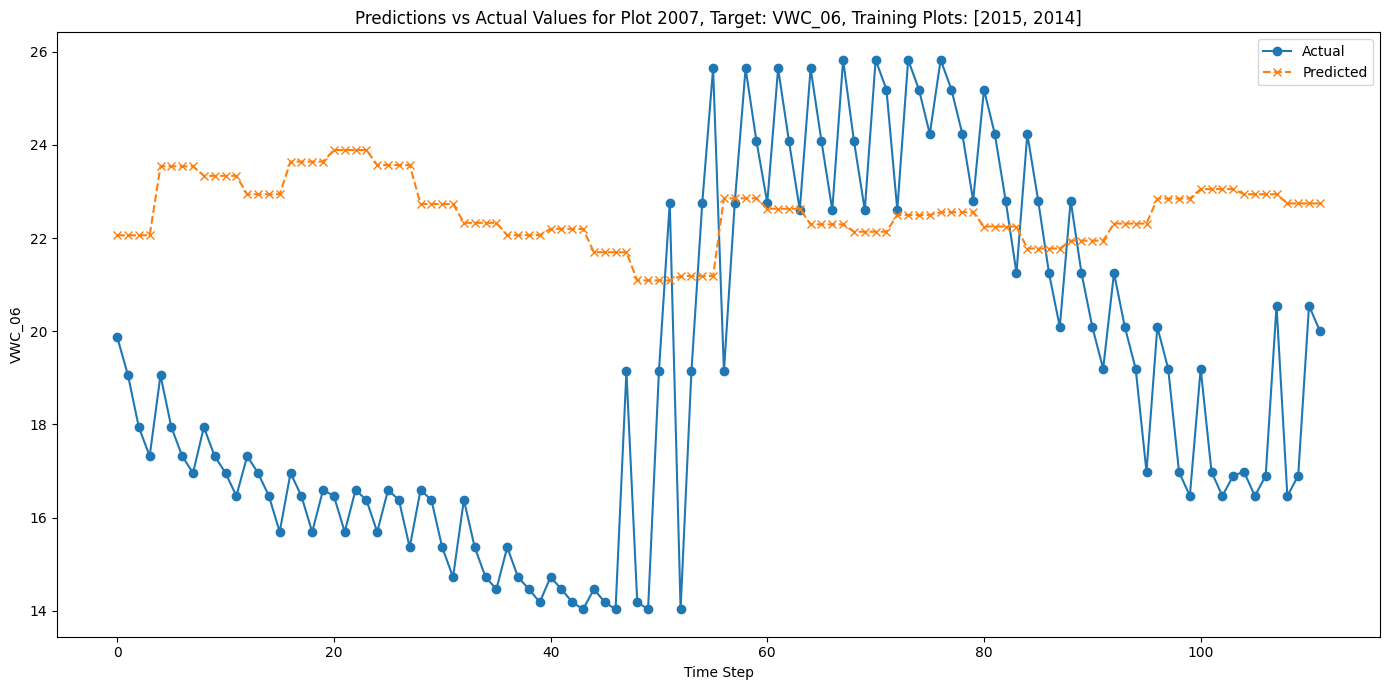

[[22.05963612 22.05963612 22.05963612 22.05963612]
 [23.53884602 23.53884602 23.53884602 23.53884602]
 [23.33446121 23.33446121 23.33446121 23.33446121]
 [22.93954945 22.93954945 22.93954945 22.93954945]
 [23.6396513  23.6396513  23.6396513  23.6396513 ]
 [23.88841248 23.88841248 23.88841248 23.88841248]
 [23.56629944 23.56629944 23.56629944 23.56629944]
 [22.72981644 22.72981644 22.72981644 22.72981644]
 [22.32626629 22.32626629 22.32626629 22.32626629]
 [22.06276798 22.06276798 22.06276798 22.06276798]
 [22.19705391 22.19705391 22.19705391 22.19705391]
 [21.69458771 21.69458771 21.69458771 21.69458771]
 [21.09046364 21.09046364 21.09046364 21.09046364]
 [21.1850462  21.1850462  21.1850462  21.1850462 ]
 [22.8511982  22.8511982  22.8511982  22.8511982 ]
 [22.62861443 22.62861443 22.62861443 22.62861443]
 [22.29305553 22.29305553 22.29305553 22.29305553]
 [22.13576126 22.13576126 22.13576126 22.13576126]
 [22.49403477 22.49403477 22.49403477 22.49403477]
 [22.55332661 22.55332661 22.55

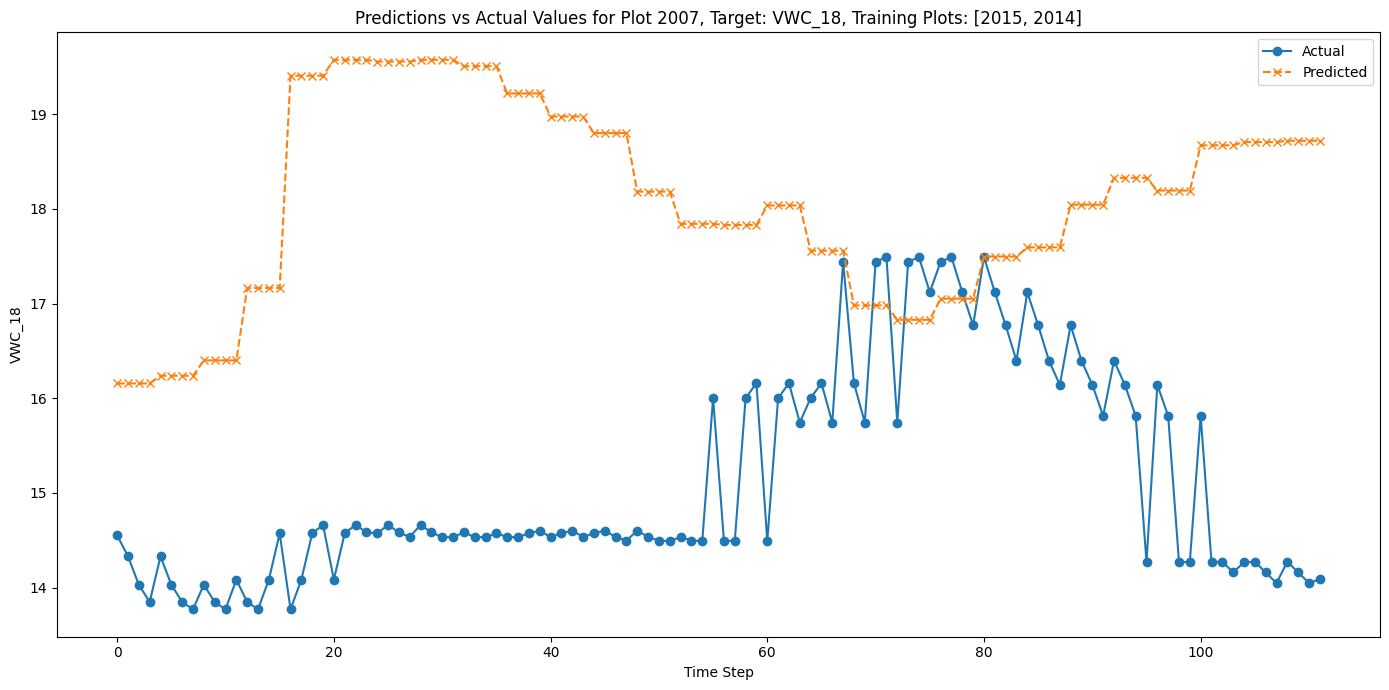

[[16.15633202 16.15633202 16.15633202 16.15633202]
 [16.23788118 16.23788118 16.23788118 16.23788118]
 [16.39997911 16.39997911 16.39997911 16.39997911]
 [17.16529703 17.16529703 17.16529703 17.16529703]
 [19.40785408 19.40785408 19.40785408 19.40785408]
 [19.57553101 19.57553101 19.57553101 19.57553101]
 [19.55725574 19.55725574 19.55725574 19.55725574]
 [19.57553101 19.57553101 19.57553101 19.57553101]
 [19.50829792 19.50829792 19.50829792 19.50829792]
 [19.22033405 19.22033405 19.22033405 19.22033405]
 [18.97653008 18.97653008 18.97653008 18.97653008]
 [18.80167294 18.80167294 18.80167294 18.80167294]
 [18.18290854 18.18290854 18.18290854 18.18290854]
 [17.84278727 17.84278727 17.84278727 17.84278727]
 [17.83103704 17.83103704 17.83103704 17.83103704]
 [18.03704453 18.03704453 18.03704453 18.03704453]
 [17.5592351  17.5592351  17.5592351  17.5592351 ]
 [16.98128319 16.98128319 16.98128319 16.98128319]
 [16.82879734 16.82879734 16.82879734 16.82879734]
 [17.0521946  17.0521946  17.05

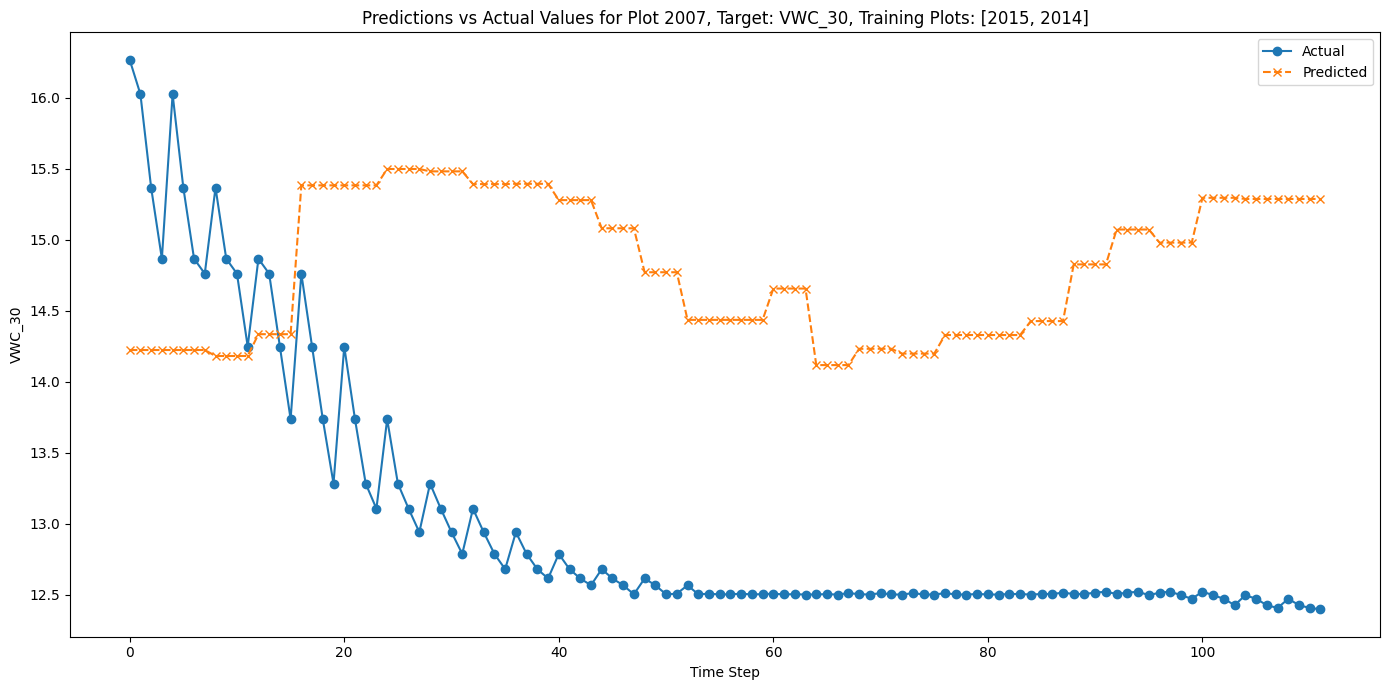

[[14.22347403 14.22347403 14.22347403 14.22347403]
 [14.22347403 14.22347403 14.22347403 14.22347403]
 [14.18139076 14.18139076 14.18139076 14.18139076]
 [14.33495712 14.33495712 14.33495712 14.33495712]
 [15.38375902 15.38375902 15.38375902 15.38375902]
 [15.38375902 15.38375902 15.38375902 15.38375902]
 [15.4990592  15.4990592  15.4990592  15.4990592 ]
 [15.48232794 15.48232794 15.48232794 15.48232794]
 [15.39261293 15.39261293 15.39261293 15.39261293]
 [15.39466    15.39466    15.39466    15.39466   ]
 [15.27978802 15.27978802 15.27978802 15.27978802]
 [15.0812459  15.0812459  15.0812459  15.0812459 ]
 [14.77143955 14.77143955 14.77143955 14.77143955]
 [14.43589306 14.43589306 14.43589306 14.43589306]
 [14.43589306 14.43589306 14.43589306 14.43589306]
 [14.65656757 14.65656757 14.65656757 14.65656757]
 [14.1172328  14.1172328  14.1172328  14.1172328 ]
 [14.23210478 14.23210478 14.23210478 14.23210478]
 [14.19812107 14.19812107 14.19812107 14.19812107]
 [14.32912064 14.32912064 14.32

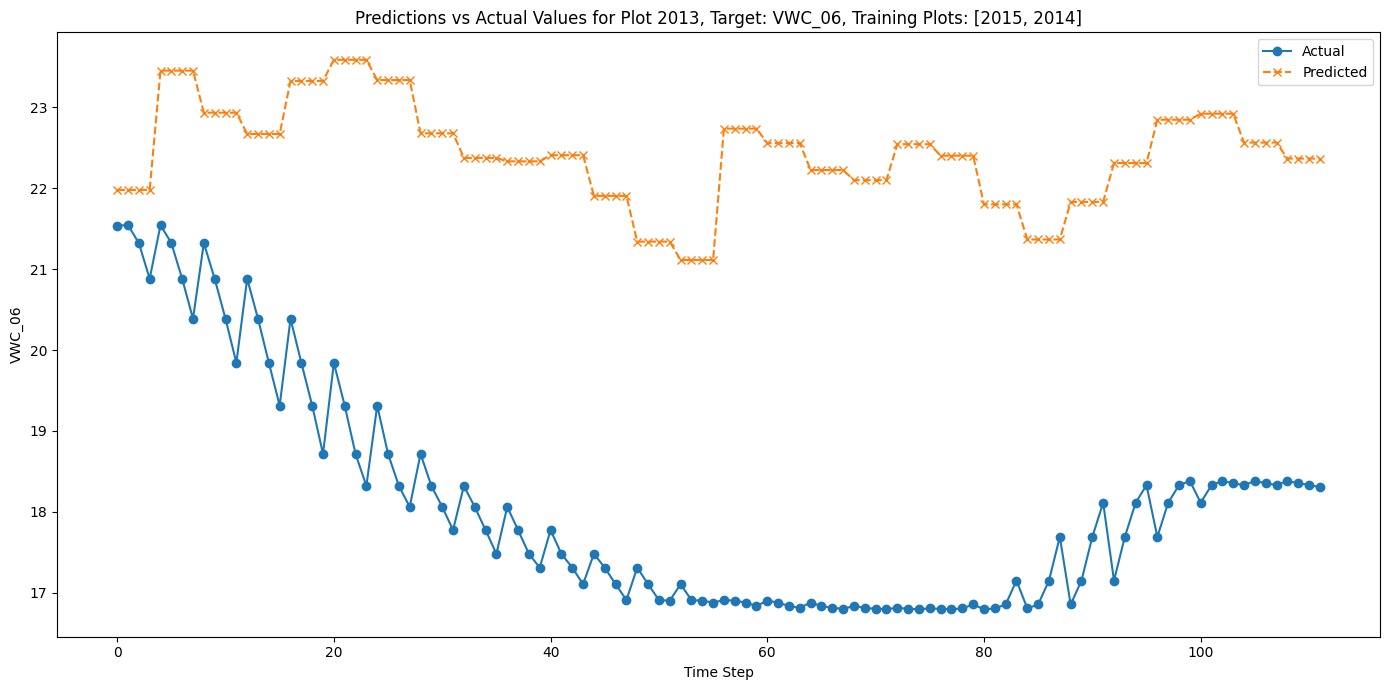

[[21.97972488 21.97972488 21.97972488 21.97972488]
 [23.45433617 23.45433617 23.45433617 23.45433617]
 [22.93464756 22.93464756 22.93464756 22.93464756]
 [22.67177773 22.67177773 22.67177773 22.67177773]
 [23.32693863 23.32693863 23.32693863 23.32693863]
 [23.58842945 23.58842945 23.58842945 23.58842945]
 [23.33792686 23.33792686 23.33792686 23.33792686]
 [22.67989922 22.67989922 22.67989922 22.67989922]
 [22.37538624 22.37538624 22.37538624 22.37538624]
 [22.33275318 22.33275318 22.33275318 22.33275318]
 [22.40880013 22.40880013 22.40880013 22.40880013]
 [21.90633392 21.90633392 21.90633392 21.90633392]
 [21.3405571  21.3405571  21.3405571  21.3405571 ]
 [21.11305141 21.11305141 21.11305141 21.11305141]
 [22.73758698 22.73758698 22.73758698 22.73758698]
 [22.55956841 22.55956841 22.55956841 22.55956841]
 [22.22548008 22.22548008 22.22548008 22.22548008]
 [22.10099602 22.10099602 22.10099602 22.10099602]
 [22.54500866 22.54500866 22.54500866 22.54500866]
 [22.40314007 22.40314007 22.40

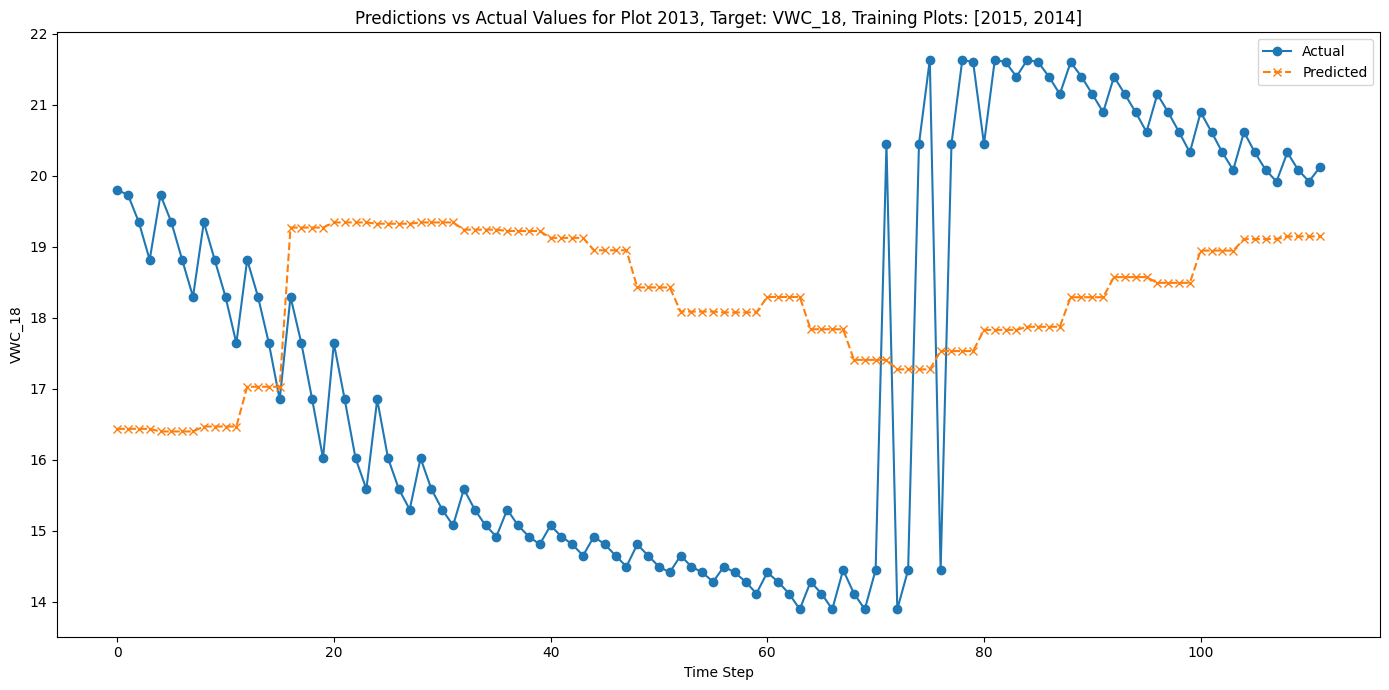

[[16.43367386 16.43367386 16.43367386 16.43367386]
 [16.39659214 16.39659214 16.39659214 16.39659214]
 [16.46652412 16.46652412 16.46652412 16.46652412]
 [17.02663231 17.02663231 17.02663231 17.02663231]
 [19.26918697 19.26918697 19.26918697 19.26918697]
 [19.34143639 19.34143639 19.34143639 19.34143639]
 [19.32316113 19.32316113 19.32316113 19.32316113]
 [19.34143639 19.34143639 19.34143639 19.34143639]
 [19.23962307 19.23962307 19.23962307 19.23962307]
 [19.22081661 19.22081661 19.22081661 19.22081661]
 [19.12386608 19.12386608 19.12386608 19.12386608]
 [18.9490099  18.9490099  18.9490099  18.9490099 ]
 [18.4256711  18.4256711  18.4256711  18.4256711 ]
 [18.08554983 18.08554983 18.08554983 18.08554983]
 [18.07379961 18.07379961 18.07379961 18.07379961]
 [18.29104948 18.29104948 18.29104948 18.29104948]
 [17.83657789 17.83657789 17.83657789 17.83657789]
 [17.40533161 17.40533161 17.40533161 17.40533161]
 [17.27129269 17.27129269 17.27129269 17.27129269]
 [17.52927017 17.52927017 17.52

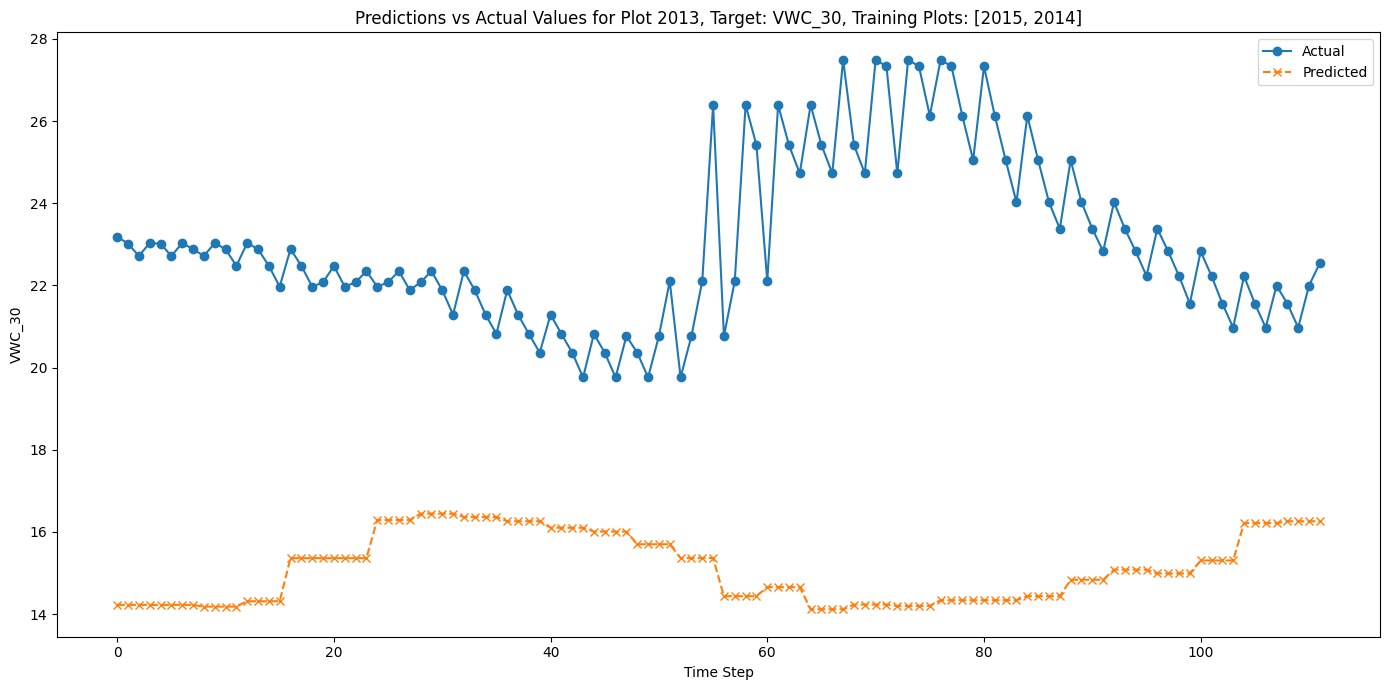

[[14.22347403 14.22347403 14.22347403 14.22347403]
 [14.22347403 14.22347403 14.22347403 14.22347403]
 [14.18139076 14.18139076 14.18139076 14.18139076]
 [14.31239033 14.31239033 14.31239033 14.31239033]
 [15.36119223 15.36119223 15.36119223 15.36119223]
 [15.36119223 15.36119223 15.36119223 15.36119223]
 [16.2889266  16.2889266  16.2889266  16.2889266 ]
 [16.44472456 16.44472456 16.44472456 16.44472456]
 [16.36364126 16.36364126 16.36364126 16.36364126]
 [16.25958109 16.25958109 16.25958109 16.25958109]
 [16.10085344 16.10085344 16.10085344 16.10085344]
 [16.00897837 16.00897837 16.00897837 16.00897837]
 [15.69917345 15.69917345 15.69917345 15.69917345]
 [15.36362934 15.36362934 15.36362934 15.36362934]
 [14.43589306 14.43589306 14.43589306 14.43589306]
 [14.65656757 14.65656757 14.65656757 14.65656757]
 [14.1172328  14.1172328  14.1172328  14.1172328 ]
 [14.23210478 14.23210478 14.23210478 14.23210478]
 [14.19812107 14.19812107 14.19812107 14.19812107]
 [14.33775139 14.33775139 14.33

In [6]:
import pandas as pd
import numpy as np
import os
import sqlite3
import pickle
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Assuming the necessary functions are defined as provided: 
# trim_start_end_nans, process_data_for_plot, subtract_mean, create_derivative_columns, transform_and_scale_data




def prepare_and_train_model(plot_number, target_column, continuous_columns, forecast_horizon, model_save_path):
    """
    Prepare data, train a single model for the specified forecast horizon, and save the model.
    """
    # Process and transform data
    df = process_data_for_plot(plot_number, [target_column], continuous_columns)
    df = trim_start_end_nans(df)
    df_transformed = transform_and_scale_data(df, [target_column], continuous_columns)

    # Define training data
    X = df_transformed.drop(columns=[target_column]).values
    y = df_transformed[target_column].values

    # Train and save model for the specified forecast horizon
    train_and_save_models_with_time_series_validation(X, y, plot_number, target_column, model_save_path, df_transformed.drop(columns=[target_column]).columns)

def predict_with_model(model_path, X):
    """
    Load a model from a file and make predictions.
    """
    
    with open(model_path, 'rb') as file:
        model = pickle.load(file)
        
    return model.predict(X)

def linear_extrap(first_pred, last_actual, forecast_horizon):
    # Calculate the slope (change per step)
    slope = first_pred - last_actual
    # Initialize an array to hold the extrapolated values
    extrapolated_values = np.zeros(forecast_horizon)
    # Set the first value to the first prediction
    extrapolated_values[0] = first_pred
    # Calculate the remaining values based on the slope
    for i in range(1, forecast_horizon):
        #extrapolated_values[i] = first_pred + slope * i
        extrapolated_values[i] = first_pred
    return extrapolated_values



def plot_predictions(plot_number, predictions, target_column, forecast_horizon, updated_continuous_columns, training_plot_numbers):
    # Assuming process_data_for_plot and other dependencies are defined elsewhere
    plt.figure(figsize=(14, 7))
    flat_predictions = predictions.flatten()
    adjusted_length = len(flat_predictions) // forecast_horizon
    y_actual = process_data_for_plot(plot_number, [target_column], updated_continuous_columns)[target_column].values
    y_actual = y_actual[:adjusted_length * forecast_horizon]
    flat_actuals = np.array([y_actual[i:i + forecast_horizon] for i in range(adjusted_length)]).flatten()

    plt.plot(flat_actuals, label='Actual', linestyle='-', marker='o')
    plt.plot(flat_predictions, label='Predicted', linestyle='--', marker='x')

    # Modified title to include target column
    plt.title(f'Predictions vs Actual Values for Plot {plot_number}, Target: {target_column}, Training Plots: {training_plot_numbers}')

    plt.xlabel('Time Step')
    plt.ylabel(target_column)
    plt.legend()
    plt.tight_layout()
    plt.show()

def weighted_average_predictions(all_predictions, inference_plot_number):
    """
    Averages predictions with equal weights for all models.
    """
    # Assign equal weights to all models
    weights = [1 / len(all_predictions)] * len(all_predictions)

    # Calculate weighted average (which is now just a simple average)
    averaged_predictions = np.average(list(all_predictions.values()), axis=0, weights=weights)
    return averaged_predictions

def run_inference(models_path, plot_number, training_plot_numbers, target_column, updated_continuous_columns, forecast_horizon):
    all_predictions = {}

    for trained_plot_number in training_plot_numbers:
        # Process and transform data for inference
        df = process_data_for_plot(plot_number, [target_column], updated_continuous_columns)
        df = trim_start_end_nans(df)
        df_transformed = transform_and_scale_data(df, [target_column], updated_continuous_columns)
        X = df_transformed.drop(columns=[target_column]).values
        y_actual = df_transformed[target_column].values

        predictions = np.zeros((len(X) - forecast_horizon + 1, forecast_horizon))

        # Perform prediction only for the first day of each forecast horizon
        model_path = os.path.join(models_path, f"best_model_{target_column}_{trained_plot_number}.pkl")
        day_1_pred = predict_with_model(model_path, X[:-forecast_horizon + 1])

        for i in range(min(len(day_1_pred), len(predictions))):
            predictions[i, 0] = day_1_pred[i]

        # Use linear extrapolation for the remaining days
        for i in range(min(len(day_1_pred), len(predictions))):
            last_actual = y_actual[i] if i < len(y_actual) else y_actual[-1]
            extrapolated_values = linear_extrap(day_1_pred[i], last_actual, forecast_horizon)
            predictions[i, 1:] = extrapolated_values[1:]  # Skip the first value as it's already predicted

        # Filter out rows where all values are zero (assuming zero predictions are not expected)
        predictions = predictions[~np.all(predictions == 0, axis=1)]

        all_predictions[trained_plot_number] = predictions
        
    # Average predictions with weights based on plot number matching (third digit)
    averaged_predictions = weighted_average_predictions(all_predictions, plot_number)

    # Plotting
    plot_predictions(plot_number, averaged_predictions, target_column, forecast_horizon, updated_continuous_columns, training_plot_numbers)

    return averaged_predictions



def process_plots(all_plot_numbers, target_columns, continuous_columns, forecast_horizon):
    model_save_path = os.path.join(os.getcwd(), "models")

    # Generate unique combinations of two training plots and one inference plot
    for training_plot1, training_plot2, inference_plot in itertools.permutations(all_plot_numbers, 3):
        training_plot_numbers = [training_plot1, training_plot2]  # Convert tuple to list
        
        # Create subfolder for this combination
        subfolder_name = f"training_{training_plot_numbers[0]}_{training_plot_numbers[1]}_inference_{inference_plot}"
        subfolder_path = os.path.join(model_save_path, subfolder_name)
        os.makedirs(subfolder_path, exist_ok=True)

        # Train models for each plot and target column
        for target_column in target_columns:
            # Update continuous columns
            updated_continuous_columns = [col for col in continuous_columns if col not in target_columns] + [col for col in target_columns if col != target_column]
            for plot_number in training_plot_numbers:
                prepare_and_train_model(plot_number, target_column, updated_continuous_columns, forecast_horizon, subfolder_path)  # Save models in subfolder

        # Inference for the inference plot and target column
        for target_column in target_columns:
            # Update continuous columns
            updated_continuous_columns = [col for col in continuous_columns if col not in target_columns] + [col for col in target_columns if col != target_column]
            predictions = run_inference(subfolder_path, inference_plot, training_plot_numbers, target_column, updated_continuous_columns, forecast_horizon)
            print(predictions)

# Example usage parameters
all_plot_numbers = [2007, 2013, 2014, 2015]

target_columns = ["VWC_06","VWC_18", "VWC_30"]
continuous_columns = [
    "Ta_2m_Avg", "RH_2m_Avg", "Solar_2m_Avg", "WndAveSpd_3m", "Rain_1m_Tot",
    "Dp_2m_Avg", "TaMax_2m", "TaMin_2m", "RHMax_2m", "RHMin_2m",
    "HeatIndex_2m_Avg", "irrigation", "precip_irrig", "canopy_temp"
]
forecast_horizon = 4

# Call the function with the provided parameters
process_plots(all_plot_numbers, target_columns, continuous_columns, forecast_horizon)

